In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from jupyterthemes import jtplot
jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False) #for dark mode

## DATA PREPARATION

In the following project we focused on classification of military vehicle, based on images. Dataset is mixed of https://www.kaggle.com/datasets/antoreepjana/military-tanks-dataset-images - mainly tanks. In our case we focused on using Convolutional Neural Network, and Keras library. Dataset contains 1295 images, in 4 classes (tanks, armored tracked vehicle, armored wheeled vehicle, self-propelled artillery). Classes are not perfectly balanced, but handling with it is part of the problem.

In [2]:
from keras.preprocessing.image import smart_resize
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import load_img


filenames = os.listdir('Data')
categories = []
for filename in filenames:
    category = filename.split(' ')[0]
    if category == 'Tank':
        categories.append(0)
    elif category == 'Tracked':
        categories.append(1)
    elif category == 'Wheeled':
        categories.append(2)
    else: 
        categories.append(3)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

X_list = []
for k in df.filename:
    path = 'Data//'
    img = load_img(path + k)
    img = smart_resize(img, (64, 64))
    array = img_to_array(img)
    array = np.resize(array, (12288,))
    array = array/255
    X_list.append(array)

y = df.category
X = df.filename

X = pd.DataFrame(np.vstack(X_list))

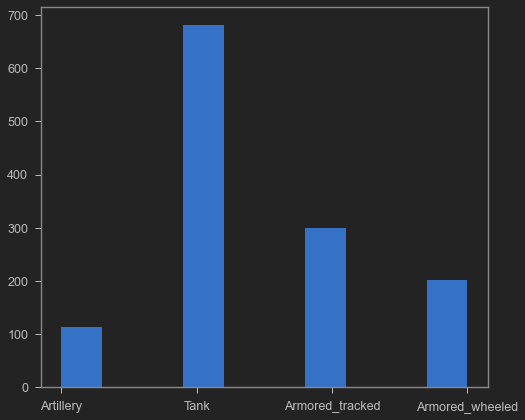

In [3]:
vehicle_dict = {0:'Tank', 1:'Armored_tracked', 2:'Armored_wheeled', 3:'Artillery'}

vehicles = pd.Series(y).map(vehicle_dict)
plt.hist(vehicles)
plt.show()


As we can see, dataset is not perfectly balanced hence, we will use some techniques for handling this problem - oversampling and data augmentation. 

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [5]:
data_to_transform = np.array(X_train)
data_to_transform_test = np.array(X_test)
X_train = np.reshape(data_to_transform, (data_to_transform.shape[0], 64, 64, 3))
X_test = np.reshape(data_to_transform_test, (data_to_transform_test.shape[0], 64, 64, 3))

In [6]:
from keras.utils import np_utils
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
target_names = ['Tank', 'Armored_tracked', 'Armored_wheeled', 'Artillery']

## MODELS

### 0. BASELINE MODEL - CNN

Baseline model is simple convolutional network, with ReLU activation, valid padding. We use 2 convolutional layers. In case of dense layers we using heuristcs from Matthew Kirk book 'Thoughtful Machine Learning with Python' - 2 dense layers, the second layer is two-thirds the size of the first layer.

In [7]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.callbacks import EarlyStopping
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import MaxPool2D
from keras.layers import Flatten
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

In [8]:
baseline_model_0 = Sequential()

baseline_model_0.add(Conv2D(64, kernel_size=(4, 4), activation='relu',
                          input_shape=(64, 64, 3)))
baseline_model_0.add(MaxPool2D(pool_size=(2, 2)))

baseline_model_0.add(Conv2D(128, kernel_size=(4, 4), activation='relu'))
baseline_model_0.add(MaxPool2D(pool_size=(2, 2)))

baseline_model_0.add(Flatten())
baseline_model_0.add(Dense(3200, activation='relu'))
baseline_model_0.add(Dropout(0.25))
baseline_model_0.add(Dense(2400, activation='relu'))
baseline_model_0.add(Dropout(0.25))
baseline_model_0.add(Dense(4, activation='softmax'))

es = EarlyStopping(patience=3, verbose=3, monitor='loss')
baseline_model_0.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

baseline_model_0.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 61, 61, 64)        3136      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 30, 30, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 27, 27, 128)       131200    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 13, 13, 128)      0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 21632)             0         
                                                                 
 dense (Dense)               (None, 3200)              6

In [9]:
history0 = baseline_model_0.fit(X_train, y_train, epochs=100, batch_size=200, callbacks=es)

Epoch 1/100
6/6 [==============================] - 13s 2s/step - loss: 4.0256 - accuracy: 0.2780
Epoch 2/100
6/6 [==============================] - 11s 2s/step - loss: 1.2496 - accuracy: 0.5261
Epoch 3/100
6/6 [==============================] - 12s 2s/step - loss: 1.1967 - accuracy: 0.5261
Epoch 4/100
6/6 [==============================] - 11s 2s/step - loss: 1.1786 - accuracy: 0.5261
Epoch 5/100
6/6 [==============================] - 11s 2s/step - loss: 1.1840 - accuracy: 0.5261
Epoch 6/100
6/6 [==============================] - 11s 2s/step - loss: 1.1570 - accuracy: 0.5261
Epoch 7/100
6/6 [==============================] - 11s 2s/step - loss: 1.1119 - accuracy: 0.5261
Epoch 8/100
6/6 [==============================] - 11s 2s/step - loss: 1.0523 - accuracy: 0.5512
Epoch 9/100
6/6 [==============================] - 11s 2s/step - loss: 0.9929 - accuracy: 0.5859
Epoch 10/100
6/6 [==============================] - 11s 2s/step - loss: 0.9362 - accuracy: 0.6149
Epoch 11/100
6/6 [===========

dict_keys(['loss', 'accuracy'])


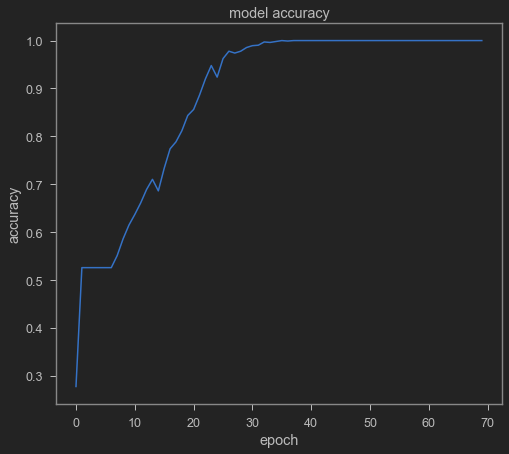

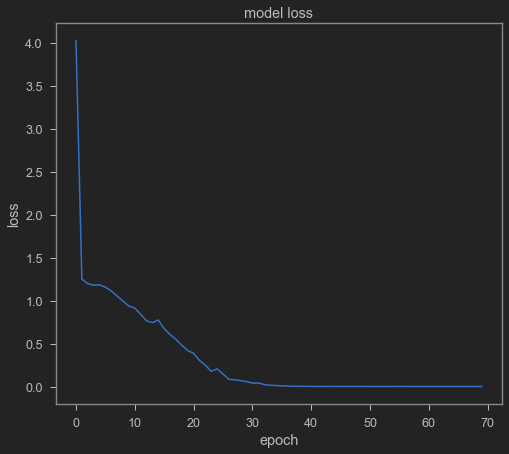

In [10]:
print(history0.history.keys())
# summarize history for accuracy
plt.plot(history0.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()
# summarize history for loss
plt.plot(history0.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

Accuracy: 0.6640926640926641
                 precision    recall  f1-score   support

           Tank       0.74      0.79      0.76       136
Armored_tracked       0.59      0.60      0.60        60
Armored_wheeled       0.57      0.53      0.55        40
      Artillery       0.57      0.35      0.43        23

      micro avg       0.67      0.66      0.67       259
      macro avg       0.62      0.56      0.58       259
   weighted avg       0.67      0.66      0.66       259
    samples avg       0.66      0.66      0.66       259



C:\Users\PC\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


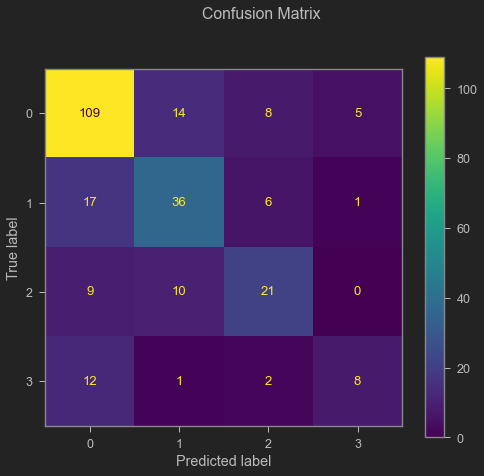

In [11]:
y_pred = baseline_model_0.predict(X_test).round()

print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(classification_report(y_test, y_pred, target_names=target_names))

conf_test = np.argmax(y_test, axis=1)
conf_pred = np.argmax(y_pred, axis=1)
disp = ConfusionMatrixDisplay.from_predictions(conf_test, conf_pred)
disp.figure_.suptitle("Confusion Matrix")

plt.show()

### 1. IMPROVED MODEL - more parameters by same padding

We improved baseline model - adding more parameters by changing padding technique.

In [12]:
baseline_model_1 = Sequential()

baseline_model_1.add(Conv2D(64, kernel_size=(4, 4), activation='relu',
                          input_shape=(64, 64, 3), padding='same'))
baseline_model_1.add(MaxPool2D(pool_size=(2, 2)))

baseline_model_1.add(Conv2D(128, kernel_size=(4, 4), activation='relu', padding='same'))
baseline_model_1.add(MaxPool2D(pool_size=(2, 2)))

baseline_model_1.add(Flatten())
baseline_model_1.add(Dense(3200, activation='relu'))
baseline_model_1.add(Dropout(0.25))
baseline_model_1.add(Dense(2400, activation='relu'))
baseline_model_1.add(Dropout(0.25))
baseline_model_1.add(Dense(4, activation='softmax'))

es = EarlyStopping(patience=3, verbose=3, monitor='loss')
baseline_model_1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

baseline_model_1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 64, 64, 64)        3136      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 32, 32, 128)       131200    
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 16, 16, 128)      0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 32768)             0         
                                                                 
 dense_3 (Dense)             (None, 3200)             

In [13]:
history1 = baseline_model_1.fit(X_train, y_train, epochs=100, batch_size=200, callbacks=es)

Epoch 1/100
6/6 [==============================] - 21s 3s/step - loss: 5.5911 - accuracy: 0.3427
Epoch 2/100
6/6 [==============================] - 19s 3s/step - loss: 1.2726 - accuracy: 0.5261
Epoch 3/100
6/6 [==============================] - 17s 3s/step - loss: 1.1930 - accuracy: 0.5261
Epoch 4/100
6/6 [==============================] - 16s 3s/step - loss: 1.1814 - accuracy: 0.5261
Epoch 5/100
6/6 [==============================] - 16s 3s/step - loss: 1.1946 - accuracy: 0.5261
Epoch 6/100
6/6 [==============================] - 16s 3s/step - loss: 1.1654 - accuracy: 0.5261
Epoch 7/100
6/6 [==============================] - 16s 3s/step - loss: 1.1502 - accuracy: 0.5261
Epoch 8/100
6/6 [==============================] - 16s 3s/step - loss: 1.1382 - accuracy: 0.5261
Epoch 9/100
6/6 [==============================] - 16s 3s/step - loss: 1.1065 - accuracy: 0.5261
Epoch 10/100
6/6 [==============================] - 16s 3s/step - loss: 1.0307 - accuracy: 0.5425
Epoch 11/100
6/6 [===========

dict_keys(['loss', 'accuracy'])


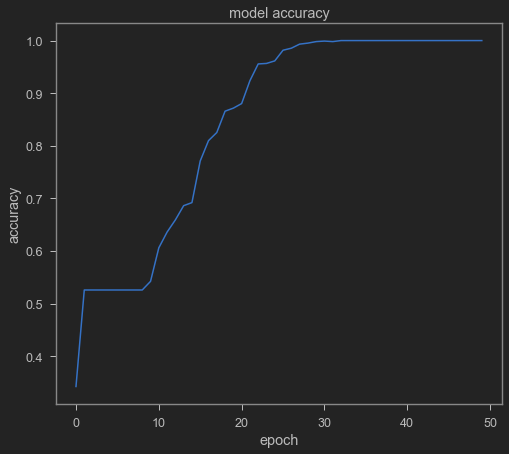

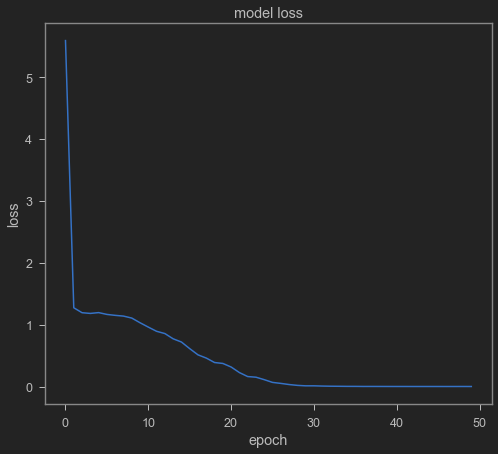

In [14]:
print(history1.history.keys())
# summarize history for accuracy
plt.plot(history1.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()
# summarize history for loss
plt.plot(history1.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

Accuracy: 0.640926640926641
                 precision    recall  f1-score   support

           Tank       0.76      0.79      0.78       136
Armored_tracked       0.49      0.58      0.53        60
Armored_wheeled       0.51      0.47      0.49        40
      Artillery       0.67      0.17      0.28        23

      micro avg       0.65      0.64      0.64       259
      macro avg       0.61      0.51      0.52       259
   weighted avg       0.65      0.64      0.63       259
    samples avg       0.64      0.64      0.64       259



C:\Users\PC\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


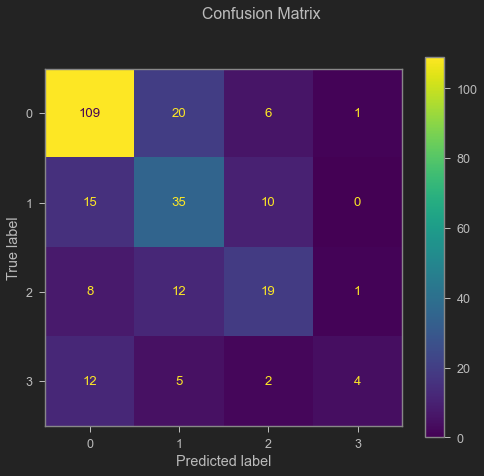

In [15]:
y_pred = baseline_model_1.predict(X_test).round()

print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(classification_report(y_test, y_pred, target_names=target_names))

conf_test = np.argmax(y_test, axis=1)
conf_pred = np.argmax(y_pred, axis=1)
disp = ConfusionMatrixDisplay.from_predictions(conf_test, conf_pred)
disp.figure_.suptitle("Confusion Matrix")

plt.show()

### 2. IMPROVED MODEL - add more conv2d layer

In next model we add more convolutional layers for better feature extractions and we return to valid padding.

In [16]:
baseline_model_2 = Sequential()

baseline_model_2.add(Conv2D(64, kernel_size=(4, 4), activation='relu',
                          input_shape=(64, 64, 3), padding='valid'))
baseline_model_2.add(Conv2D(64, kernel_size=(4, 4), activation='relu', padding='valid'))
baseline_model_2.add(MaxPool2D(pool_size=(2, 2)))

baseline_model_2.add(Conv2D(128, kernel_size=(4, 4), activation='relu', padding='valid'))
baseline_model_2.add(Conv2D(128, kernel_size=(4, 4), activation='relu', padding='valid'))
baseline_model_2.add(MaxPool2D(pool_size=(2, 2)))

baseline_model_2.add(Flatten())
baseline_model_2.add(Dense(3200, activation='relu'))
baseline_model_2.add(Dropout(0.25))
baseline_model_2.add(Dense(2400, activation='relu'))
baseline_model_2.add(Dropout(0.25))
baseline_model_2.add(Dense(4, activation='softmax'))

es = EarlyStopping(patience=4, verbose=3, monitor='loss')
baseline_model_2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

baseline_model_2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 61, 61, 64)        3136      
                                                                 
 conv2d_5 (Conv2D)           (None, 58, 58, 64)        65600     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 29, 29, 64)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 26, 26, 128)       131200    
                                                                 
 conv2d_7 (Conv2D)           (None, 23, 23, 128)       262272    
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 11, 11, 128)      0         
 2D)                                                  

In [17]:
history2 = baseline_model_2.fit(X_train, y_train, epochs=100, batch_size=200, callbacks=es)

Epoch 1/100
6/6 [==============================] - 33s 5s/step - loss: 2.9988 - accuracy: 0.3031
Epoch 2/100
6/6 [==============================] - 32s 5s/step - loss: 1.2407 - accuracy: 0.5261
Epoch 3/100
6/6 [==============================] - 32s 5s/step - loss: 1.2025 - accuracy: 0.5261
Epoch 4/100
6/6 [==============================] - 30s 5s/step - loss: 1.1869 - accuracy: 0.5261
Epoch 5/100
6/6 [==============================] - 32s 5s/step - loss: 1.1869 - accuracy: 0.5261
Epoch 6/100
6/6 [==============================] - 33s 5s/step - loss: 1.1638 - accuracy: 0.5261
Epoch 7/100
6/6 [==============================] - 31s 5s/step - loss: 1.1458 - accuracy: 0.5261
Epoch 8/100
6/6 [==============================] - 34s 5s/step - loss: 1.0996 - accuracy: 0.5261
Epoch 9/100
6/6 [==============================] - 37s 6s/step - loss: 1.0344 - accuracy: 0.5463
Epoch 10/100
6/6 [==============================] - 35s 6s/step - loss: 0.9876 - accuracy: 0.5849
Epoch 11/100
6/6 [===========

dict_keys(['loss', 'accuracy'])


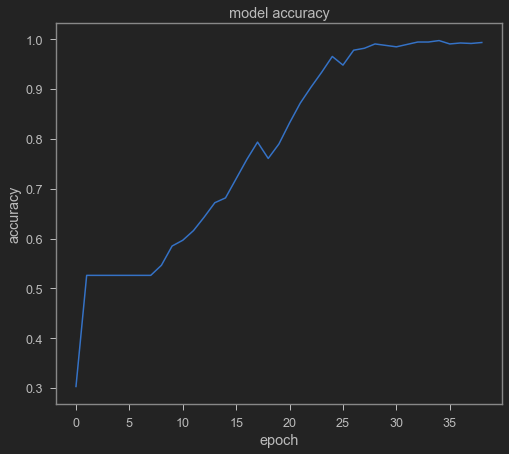

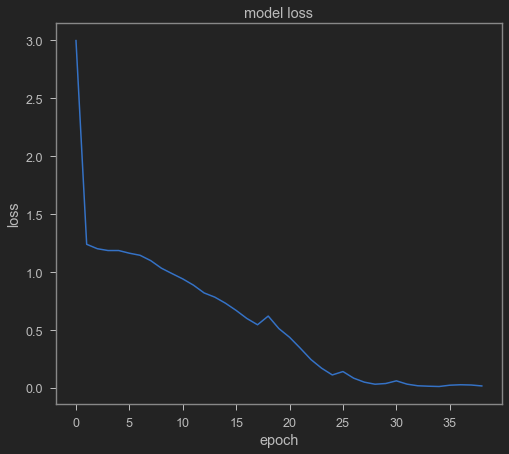

In [18]:
print(history2.history.keys())
# summarize history for accuracy
plt.plot(history2.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()
# summarize history for loss
plt.plot(history2.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

Accuracy: 0.6447876447876448
                 precision    recall  f1-score   support

           Tank       0.72      0.86      0.78       136
Armored_tracked       0.52      0.53      0.53        60
Armored_wheeled       0.62      0.38      0.47        40
      Artillery       0.38      0.13      0.19        23

      micro avg       0.65      0.64      0.65       259
      macro avg       0.56      0.47      0.49       259
   weighted avg       0.63      0.64      0.62       259
    samples avg       0.64      0.64      0.64       259



C:\Users\PC\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


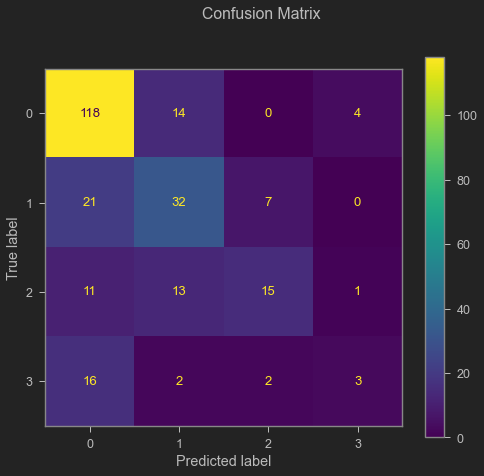

In [19]:
y_pred = baseline_model_2.predict(X_test).round()

print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(classification_report(y_test, y_pred, target_names=target_names))

conf_test = np.argmax(y_test, axis=1)
conf_pred = np.argmax(y_pred, axis=1)
disp = ConfusionMatrixDisplay.from_predictions(conf_test, conf_pred)
disp.figure_.suptitle("Confusion Matrix")

plt.show()

### 3. BASELINE MODEL - using oversampling

Imblearn library, can help us for handling imbalanced dataset problem. As we can see in previous steps, precision metric for the least numerous 3 class (with self-propeled artillery images) is low. Over-sampling/Under-sampling is the simplest solution. Idea of over-sampling is supplementing minoroty class with multiple copies of elements. On the other hand under-sampling (cutting majority class) is probably worse in our case because our majority class is relativly small. Mainly problem of over-sampling is high risk of over-fitting our model.

In [20]:
from imblearn.over_sampling import RandomOverSampler

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
ros = RandomOverSampler(random_state=42)
X_ros, y_ros = ros.fit_resample(X_train, y_train)
data_to_transform = np.array(X_ros)
data_to_transform_test = np.array(X_test)
X_ros = np.reshape(data_to_transform, (data_to_transform.shape[0], 64, 64, 3))
X_test = np.reshape(data_to_transform_test, (data_to_transform_test.shape[0], 64, 64, 3))
y_ros = np_utils.to_categorical(y_ros)
y_test = np_utils.to_categorical(y_test)

In [21]:
baseline_model_0_ros = Sequential()

baseline_model_0_ros.add(Conv2D(64, kernel_size=(4, 4), activation='relu',
                          input_shape=(64, 64, 3)))
baseline_model_0_ros.add(MaxPool2D(pool_size=(2, 2)))

baseline_model_0_ros.add(Conv2D(128, kernel_size=(4, 4), activation='relu'))
baseline_model_0_ros.add(MaxPool2D(pool_size=(2, 2)))

baseline_model_0_ros.add(Flatten())
baseline_model_0_ros.add(Dense(3200, activation='relu'))
baseline_model_0_ros.add(Dropout(0.25))
baseline_model_0_ros.add(Dense(2400, activation='relu'))
baseline_model_0_ros.add(Dropout(0.25))
baseline_model_0_ros.add(Dense(4, activation='softmax'))

es = EarlyStopping(patience=3, verbose=3, monitor='loss')
baseline_model_0_ros.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

baseline_model_0_ros.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 61, 61, 64)        3136      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 27, 27, 128)       131200    
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 13, 13, 128)      0         
 2D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 21632)             0         
                                                                 
 dense_9 (Dense)             (None, 3200)             

In [22]:
history0_ros = baseline_model_0_ros.fit(X_ros, y_ros, epochs=100, batch_size=200, callbacks=es)

Epoch 1/100
11/11 [==============================] - 24s 2s/step - loss: 2.2615 - accuracy: 0.2683
Epoch 2/100
11/11 [==============================] - 23s 2s/step - loss: 1.3152 - accuracy: 0.3775
Epoch 3/100
11/11 [==============================] - 25s 2s/step - loss: 1.1702 - accuracy: 0.4766
Epoch 4/100
11/11 [==============================] - 23s 2s/step - loss: 0.9356 - accuracy: 0.6133
Epoch 5/100
11/11 [==============================] - 23s 2s/step - loss: 0.7624 - accuracy: 0.6936
Epoch 6/100
11/11 [==============================] - 23s 2s/step - loss: 0.5570 - accuracy: 0.7890
Epoch 7/100
11/11 [==============================] - 23s 2s/step - loss: 0.3652 - accuracy: 0.8711
Epoch 8/100
11/11 [==============================] - 23s 2s/step - loss: 0.2352 - accuracy: 0.9197
Epoch 9/100
11/11 [==============================] - 23s 2s/step - loss: 0.1446 - accuracy: 0.9550
Epoch 10/100
11/11 [==============================] - 25s 2s/step - loss: 0.0888 - accuracy: 0.9729
Epoch 11/

dict_keys(['loss', 'accuracy'])


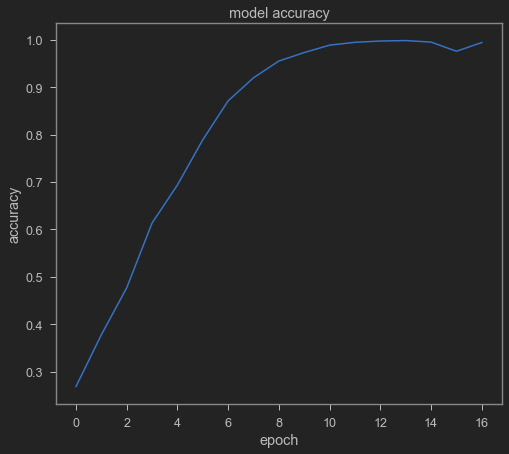

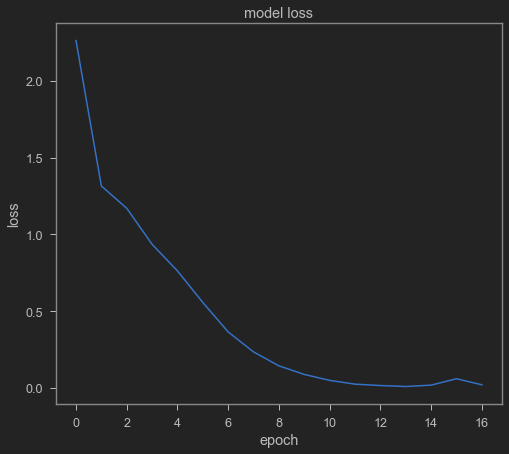

In [23]:
print(history0_ros.history.keys())
# summarize history for accuracy
plt.plot(history0_ros.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()
# summarize history for loss
plt.plot(history0_ros.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

Accuracy: 0.6061776061776062
                 precision    recall  f1-score   support

           Tank       0.76      0.73      0.74       136
Armored_tracked       0.47      0.42      0.44        60
Armored_wheeled       0.51      0.65      0.57        40
      Artillery       0.35      0.30      0.33        23

      micro avg       0.62      0.61      0.61       259
      macro avg       0.52      0.52      0.52       259
   weighted avg       0.62      0.61      0.61       259
    samples avg       0.61      0.61      0.61       259



C:\Users\PC\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


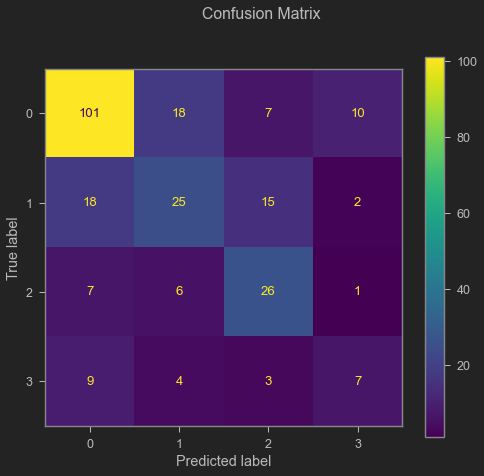

In [24]:
y_pred = baseline_model_0_ros.predict(X_test).round()

print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(classification_report(y_test, y_pred, target_names=target_names))

conf_test = np.argmax(y_test, axis=1)
conf_pred = np.argmax(y_pred, axis=1)
disp = ConfusionMatrixDisplay.from_predictions(conf_test, conf_pred)
disp.figure_.suptitle("Confusion Matrix")

plt.show()

### 4. BASELINE MODEL - using data augmentation

As we can see, result of over-sampling are not satysfing. The data augmentation is better way. We used random horizontal flip and change contrast of image.

In [25]:
from keras.layers import RandomContrast
from keras.layers import RandomFlip

data_augmentation = Sequential([
    RandomFlip("horizontal", input_shape=(64,64,3)),
    RandomContrast(factor=0.1) 
 ])

In [28]:
from keras.preprocessing.image import smart_resize
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import load_img


filenames = os.listdir('Data')
categories = []
for filename in filenames:
    category = filename.split(' ')[0]
    if category == 'Tank':
        categories.append(0)
    elif category == 'Tracked':
        categories.append(1)
    elif category == 'Wheeled':
        categories.append(2)
    else: 
        categories.append(3)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

X_list = []
for k in df.filename:
    path = 'Data//'
    img = load_img(path + k)
    img = smart_resize(img, (64, 64))
    array = img_to_array(img)
    array = np.resize(array, (12288,))
    array = array/255
    X_list.append(array)

y = df.category
X = df.filename

X = pd.DataFrame(np.vstack(X_list))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

data_to_transform = np.array(X_train)
data_to_transform_test = np.array(X_test)
X_train = np.reshape(data_to_transform, (data_to_transform.shape[0], 64, 64, 3))
X_test = np.reshape(data_to_transform_test, (data_to_transform_test.shape[0], 64, 64, 3))

y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)

In [29]:
from keras.layers import Input

input_shape = (64, 64, 3)
baseline_model_0_aug = Sequential([
    data_augmentation,
    Input(shape=(64, 64, 3)),
    Conv2D(64, kernel_size=(4, 4), activation='relu'),
    MaxPool2D(pool_size=(2, 2)),
    Conv2D(128, kernel_size=(4, 4), activation='relu'),
    MaxPool2D(pool_size=(2, 2)),
    Flatten(),
    Dense(2400, activation='relu'),
    Dropout(0.25),
    Dense(1600, activation='relu'),
    Dropout(0.25),
    Dense(4, activation='softmax')]
)

baseline_model_0_aug.compile(optimizer='adam', 
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
baseline_model_0_aug.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_4 (Sequential)   (None, 64, 64, 3)         0         
                                                                 
 input_2 (InputLayer)        multiple                  0         
                                                                 
 conv2d_12 (Conv2D)          (None, 61, 61, 64)        3136      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 30, 30, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 27, 27, 128)       131200    
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 13, 13, 128)      0         
 g2D)                                                 

In [30]:
history0_aug = baseline_model_0_aug.fit(X_train, y_train, epochs=100, batch_size=200, callbacks=es)

Epoch 1/100
6/6 [==============================] - 11s 2s/step - loss: 4.3662 - accuracy: 0.3089
Epoch 2/100
6/6 [==============================] - 10s 2s/step - loss: 1.2872 - accuracy: 0.5261
Epoch 3/100
6/6 [==============================] - 10s 2s/step - loss: 1.2245 - accuracy: 0.5261
Epoch 4/100
6/6 [==============================] - 10s 2s/step - loss: 1.1819 - accuracy: 0.5261
Epoch 5/100
6/6 [==============================] - 10s 2s/step - loss: 1.1732 - accuracy: 0.5261
Epoch 6/100
6/6 [==============================] - 10s 2s/step - loss: 1.1694 - accuracy: 0.5261
Epoch 7/100
6/6 [==============================] - 10s 2s/step - loss: 1.1599 - accuracy: 0.5261
Epoch 8/100
6/6 [==============================] - 10s 2s/step - loss: 1.1356 - accuracy: 0.5261
Epoch 9/100
6/6 [==============================] - 10s 2s/step - loss: 1.1069 - accuracy: 0.5290
Epoch 10/100
6/6 [==============================] - 10s 2s/step - loss: 1.0463 - accuracy: 0.5705
Epoch 11/100
6/6 [===========

dict_keys(['loss', 'accuracy'])


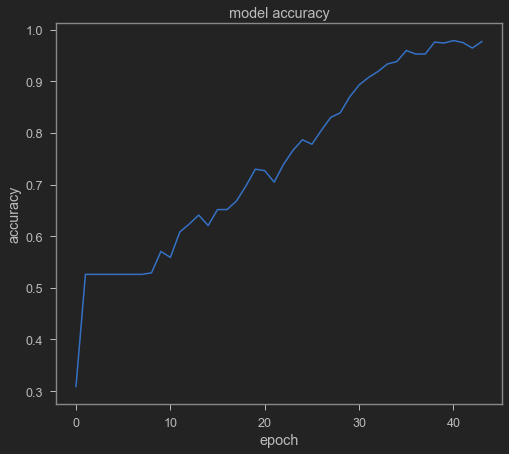

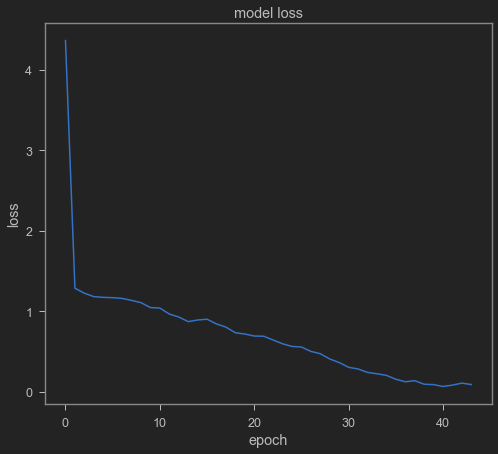

In [31]:
print(history0_aug.history.keys())
# summarize history for accuracy
plt.plot(history0_aug.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()
# summarize history for loss
plt.plot(history0_aug.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

Accuracy: 0.6911196911196911
                 precision    recall  f1-score   support

           Tank       0.76      0.89      0.82       136
Armored_tracked       0.77      0.33      0.47        60
Armored_wheeled       0.56      0.70      0.62        40
      Artillery       0.62      0.43      0.51        23

      micro avg       0.71      0.69      0.70       259
      macro avg       0.68      0.59      0.60       259
   weighted avg       0.72      0.69      0.68       259
    samples avg       0.69      0.69      0.69       259



C:\Users\PC\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


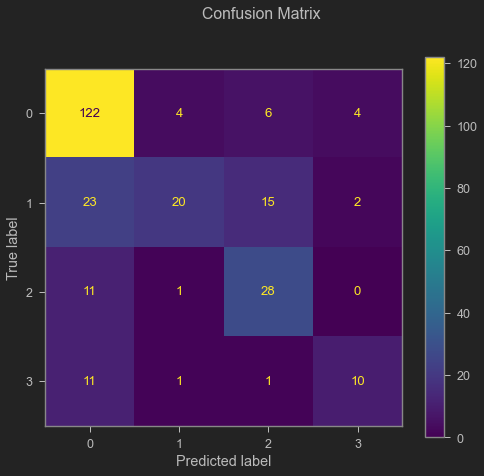

In [32]:
y_pred = baseline_model_0_aug.predict(X_test).round()

print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(classification_report(y_test, y_pred, target_names=target_names))

conf_test = np.argmax(y_test, axis=1)
conf_pred = np.argmax(y_pred, axis=1)
disp = ConfusionMatrixDisplay.from_predictions(conf_test, conf_pred)
disp.figure_.suptitle("Confusion Matrix")

plt.show()

### 5. IMPROVED MODEL - using grayscale images and higer resolution

Some problem of CNN arises from selection wrong features. For example if armored tracked vehicle are mainly in desert camouflage, our network learn wrong pattern. Story about problem: https://www.gwern.net/Tanks. Usi

In [33]:
from tensorflow.image import rgb_to_grayscale

X_list = []
for k in df.filename:
    path = 'Data//'
    img = load_img(path + k)
    img = rgb_to_grayscale(img)
    img = smart_resize(img, (100, 100))
    array = img_to_array(img)
    array = np.resize(array, (10000,))
    array = array/255
    X_list.append(array)

y = df.category
X = df.filename

X = pd.DataFrame(np.vstack(X_list))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

data_to_transform = np.array(X_train)
data_to_transform_test = np.array(X_test)
X_train = np.reshape(data_to_transform, (data_to_transform.shape[0], 100, 100, 1))
X_test = np.reshape(data_to_transform_test, (data_to_transform_test.shape[0], 100, 100, 1))

In [34]:
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)

In [35]:
baseline_model_1_gs = Sequential()

baseline_model_1_gs.add(Conv2D(100, kernel_size=(4, 4), activation='relu',
                          input_shape=(100, 100, 1), padding='same'))
baseline_model_1_gs.add(MaxPool2D(pool_size=(2, 2)))

baseline_model_1_gs.add(Conv2D(200, kernel_size=(4, 4), activation='relu', padding='same'))
baseline_model_1_gs.add(MaxPool2D(pool_size=(2, 2)))

baseline_model_1_gs.add(Flatten())
baseline_model_1_gs.add(Dense(3200, activation='relu'))
baseline_model_1_gs.add(Dropout(0.25))
baseline_model_1_gs.add(Dense(2400, activation='relu'))
baseline_model_1_gs.add(Dropout(0.25))
baseline_model_1_gs.add(Dense(4, activation='softmax'))

es = EarlyStopping(patience=3, verbose=3, monitor='loss')
baseline_model_1_gs.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

baseline_model_1_gs.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 100, 100, 100)     1700      
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 50, 50, 100)      0         
 g2D)                                                            
                                                                 
 conv2d_15 (Conv2D)          (None, 50, 50, 200)       320200    
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 25, 25, 200)      0         
 g2D)                                                            
                                                                 
 flatten_6 (Flatten)         (None, 125000)            0         
                                                                 
 dense_18 (Dense)            (None, 3200)             

In [37]:
history1_gs = baseline_model_1_gs.fit(X_train, y_train, epochs=100, batch_size=200, callbacks=es)

Epoch 1/100
6/6 [==============================] - 109s 14s/step - loss: 12.0142 - accuracy: 0.3166
Epoch 2/100
6/6 [==============================] - 69s 11s/step - loss: 1.3218 - accuracy: 0.5261
Epoch 3/100
6/6 [==============================] - 68s 11s/step - loss: 1.1816 - accuracy: 0.5261
Epoch 4/100
6/6 [==============================] - 76s 12s/step - loss: 1.1751 - accuracy: 0.5261
Epoch 5/100
6/6 [==============================] - 74s 12s/step - loss: 1.1477 - accuracy: 0.5261
Epoch 6/100
6/6 [==============================] - 74s 12s/step - loss: 1.1079 - accuracy: 0.5541
Epoch 7/100
6/6 [==============================] - 71s 11s/step - loss: 1.0587 - accuracy: 0.5763
Epoch 8/100
6/6 [==============================] - 66s 11s/step - loss: 0.9781 - accuracy: 0.5946
Epoch 9/100
6/6 [==============================] - 65s 11s/step - loss: 0.9042 - accuracy: 0.6380
Epoch 10/100
6/6 [==============================] - 67s 11s/step - loss: 0.8361 - accuracy: 0.6583
Epoch 11/100
6/6 

dict_keys(['loss', 'accuracy'])


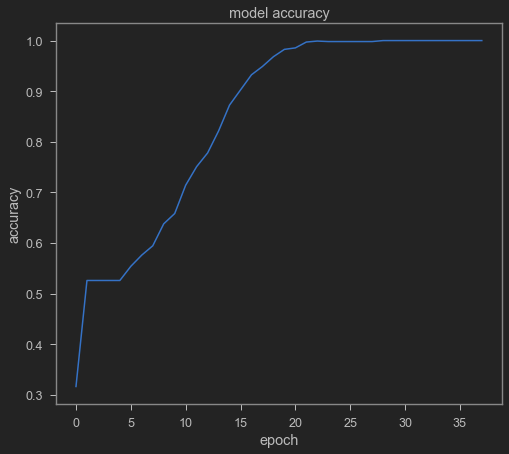

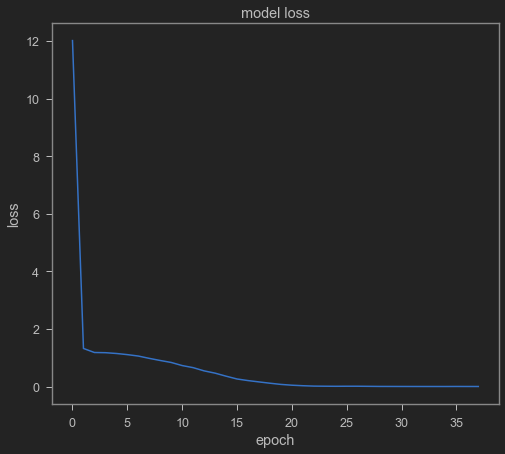

In [38]:
print(history1_gs.history.keys())
# summarize history for accuracy
plt.plot(history1_gs.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()
# summarize history for loss
plt.plot(history1_gs.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

Accuracy: 0.61003861003861
                 precision    recall  f1-score   support

           Tank       0.71      0.79      0.75       136
Armored_tracked       0.46      0.38      0.42        60
Armored_wheeled       0.56      0.57      0.57        40
      Artillery       0.36      0.17      0.24        23

      micro avg       0.62      0.61      0.62       259
      macro avg       0.52      0.48      0.49       259
   weighted avg       0.60      0.61      0.60       259
    samples avg       0.61      0.61      0.61       259



C:\Users\PC\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


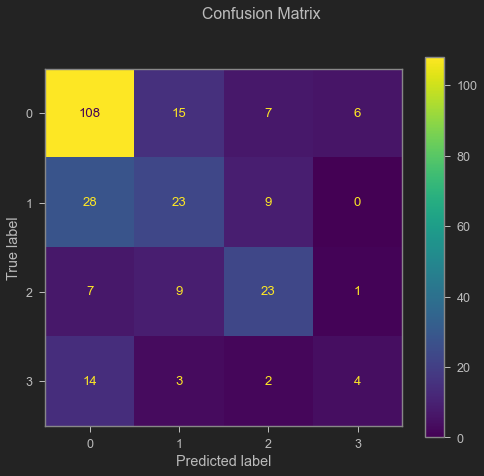

In [39]:
y_pred = baseline_model_1_gs.predict(X_test).round()

print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(classification_report(y_test, y_pred, target_names=target_names))

conf_test = np.argmax(y_test, axis=1)
conf_pred = np.argmax(y_pred, axis=1)
disp = ConfusionMatrixDisplay.from_predictions(conf_test, conf_pred)
disp.figure_.suptitle("Confusion Matrix")

plt.show()

#### Visualisation predicted probability.

In [40]:
y_name = np.argmax(y_test, axis=1)
vehicle_dict = {0:'Tank', 1:'Armored_tracked', 2:'Armored_wheeled', 3:'Artillery'}

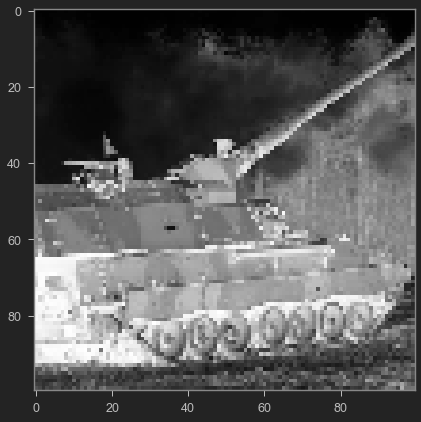

True class: Artillery
Predicted probability:
Tank: 0%, Armored_tracked: 71%, Armored_wheeled: 28%, Artillery: 0% 


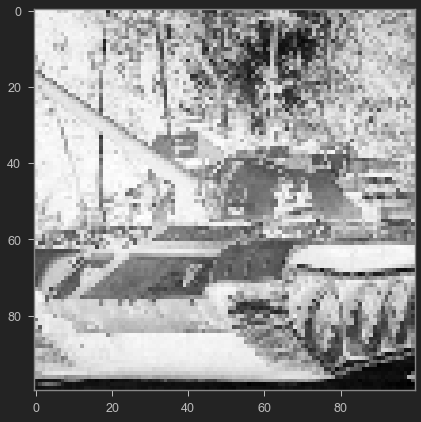

True class: Tank
Predicted probability:
Tank: 2%, Armored_tracked: 61%, Armored_wheeled: 35%, Artillery: 0% 


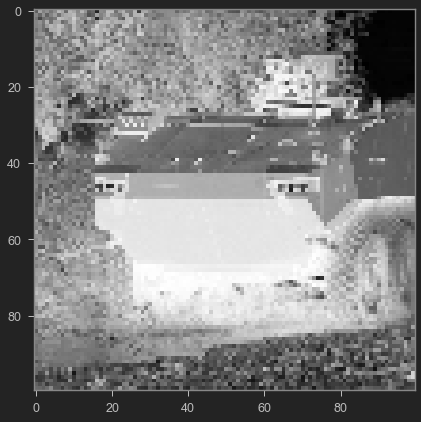

True class: Armored_wheeled
Predicted probability:
Tank: 88%, Armored_tracked: 11%, Armored_wheeled: 0%, Artillery: 0% 


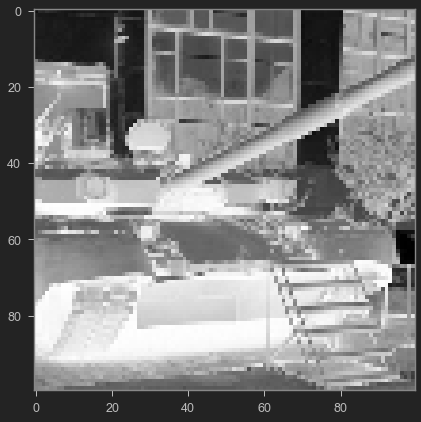

True class: Tank
Predicted probability:
Tank: 99%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 0% 


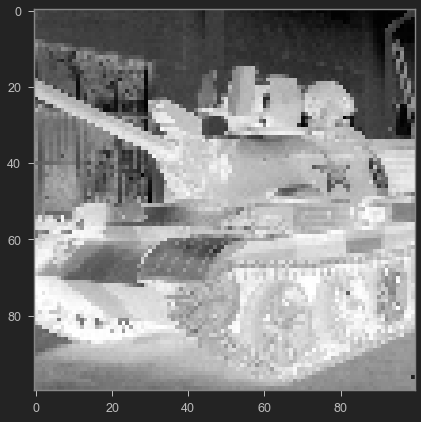

True class: Tank
Predicted probability:
Tank: 0%, Armored_tracked: 99%, Armored_wheeled: 0%, Artillery: 0% 


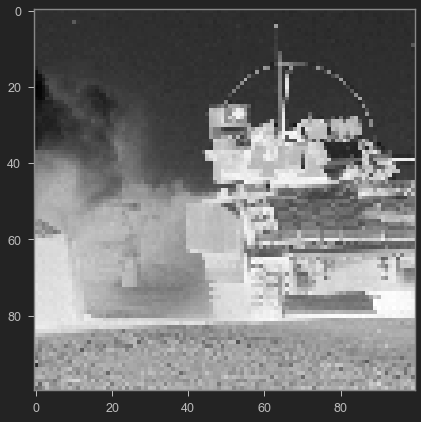

True class: Armored_tracked
Predicted probability:
Tank: 78%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 20% 


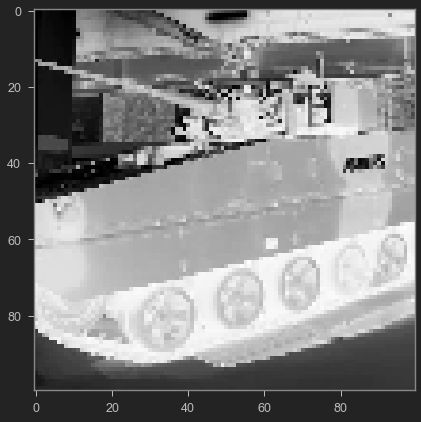

True class: Armored_tracked
Predicted probability:
Tank: 0%, Armored_tracked: 95%, Armored_wheeled: 4%, Artillery: 0% 


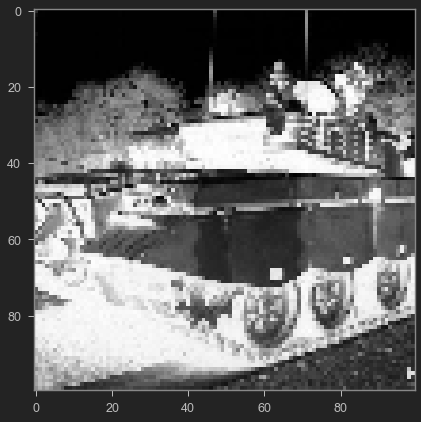

True class: Tank
Predicted probability:
Tank: 0%, Armored_tracked: 100%, Armored_wheeled: 0%, Artillery: 0% 


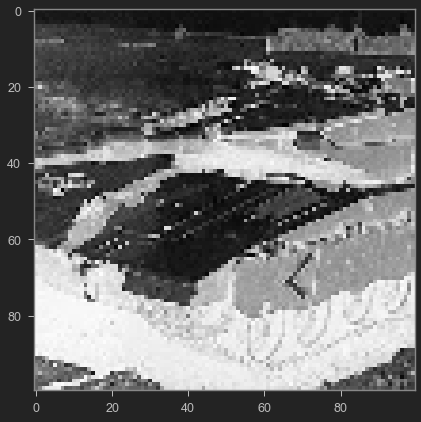

True class: Tank
Predicted probability:
Tank: 99%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 0% 


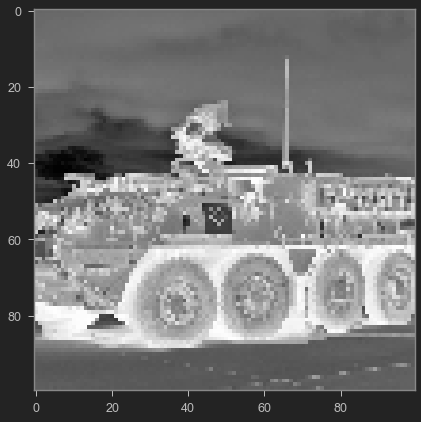

True class: Armored_wheeled
Predicted probability:
Tank: 0%, Armored_tracked: 0%, Armored_wheeled: 99%, Artillery: 0% 


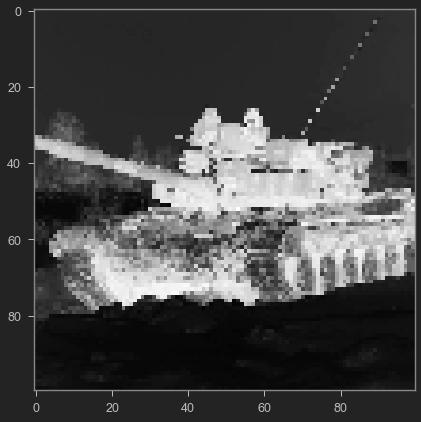

True class: Tank
Predicted probability:
Tank: 99%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 0% 


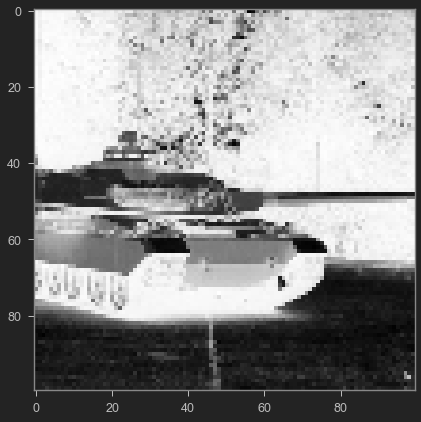

True class: Tank
Predicted probability:
Tank: 100%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 0% 


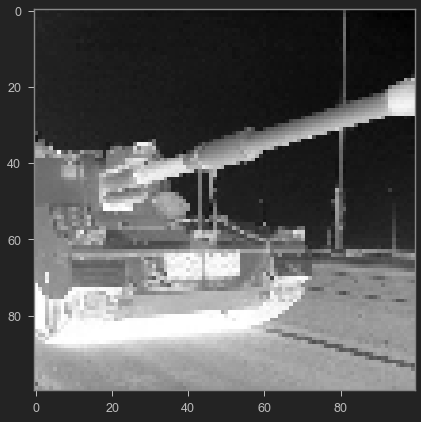

True class: Artillery
Predicted probability:
Tank: 99%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 0% 


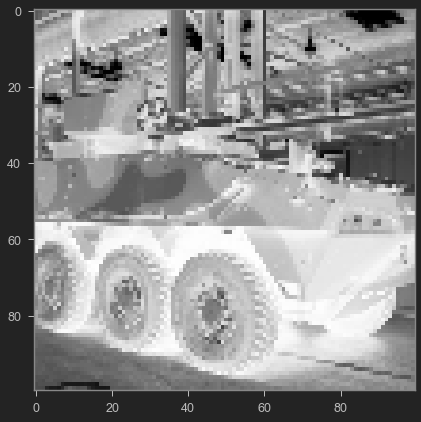

True class: Armored_wheeled
Predicted probability:
Tank: 0%, Armored_tracked: 0%, Armored_wheeled: 99%, Artillery: 0% 


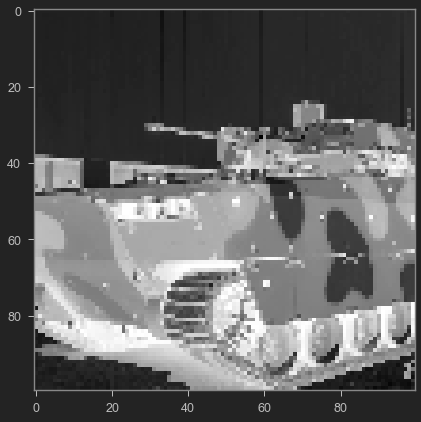

True class: Armored_tracked
Predicted probability:
Tank: 0%, Armored_tracked: 94%, Armored_wheeled: 5%, Artillery: 0% 


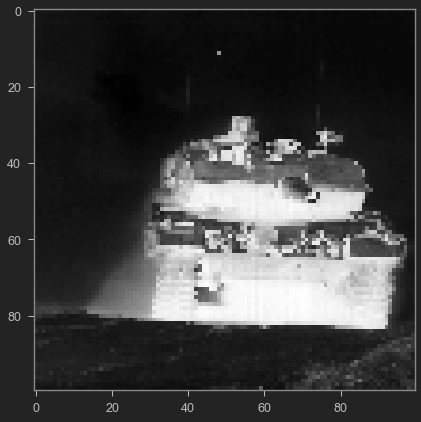

True class: Tank
Predicted probability:
Tank: 100%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 0% 


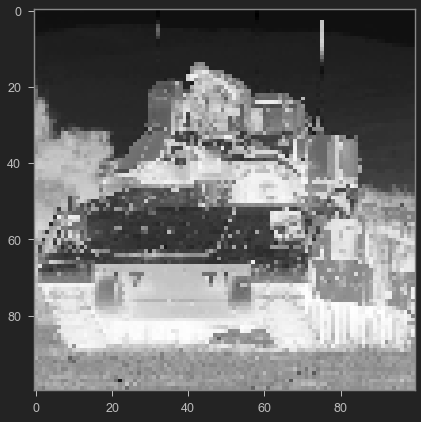

True class: Armored_tracked
Predicted probability:
Tank: 99%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 0% 


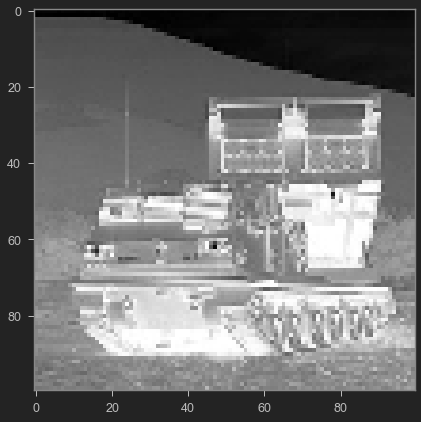

True class: Armored_tracked
Predicted probability:
Tank: 11%, Armored_tracked: 0%, Armored_wheeled: 75%, Artillery: 12% 


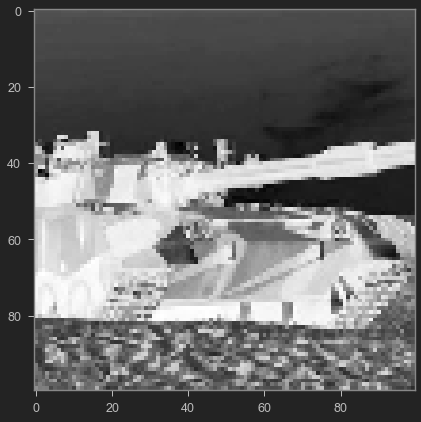

True class: Tank
Predicted probability:
Tank: 99%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 0% 


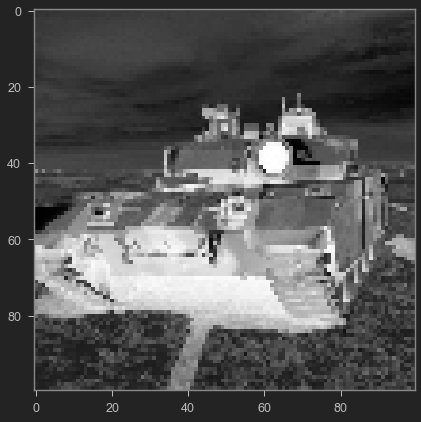

True class: Tank
Predicted probability:
Tank: 78%, Armored_tracked: 14%, Armored_wheeled: 0%, Artillery: 7% 


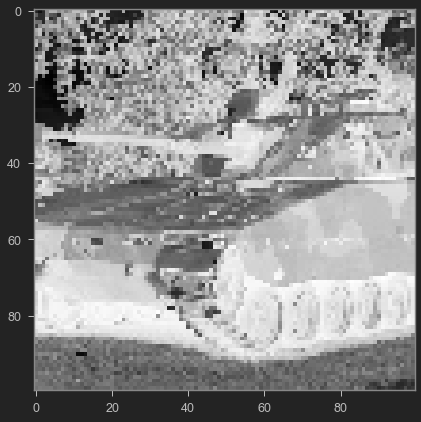

True class: Armored_tracked
Predicted probability:
Tank: 50%, Armored_tracked: 49%, Armored_wheeled: 0%, Artillery: 0% 


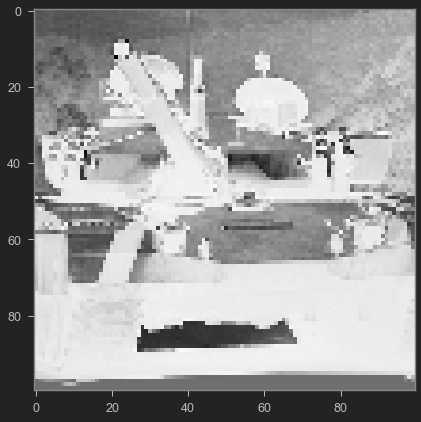

True class: Tank
Predicted probability:
Tank: 100%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 0% 


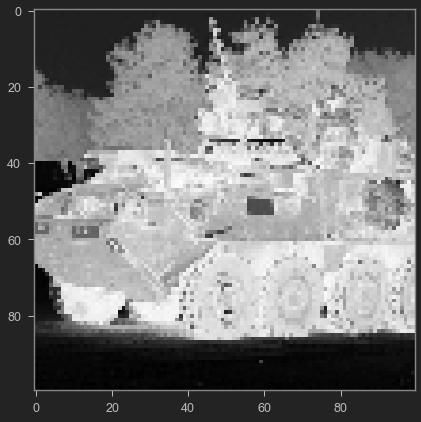

True class: Armored_wheeled
Predicted probability:
Tank: 0%, Armored_tracked: 99%, Armored_wheeled: 0%, Artillery: 0% 


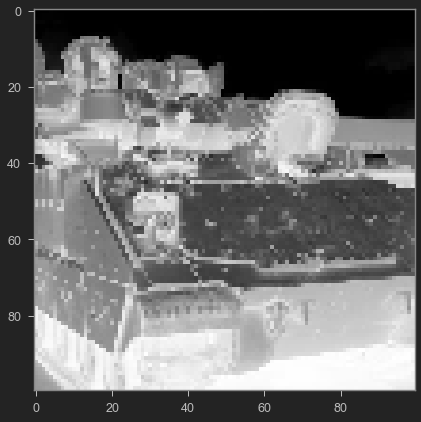

True class: Armored_tracked
Predicted probability:
Tank: 0%, Armored_tracked: 99%, Armored_wheeled: 0%, Artillery: 0% 


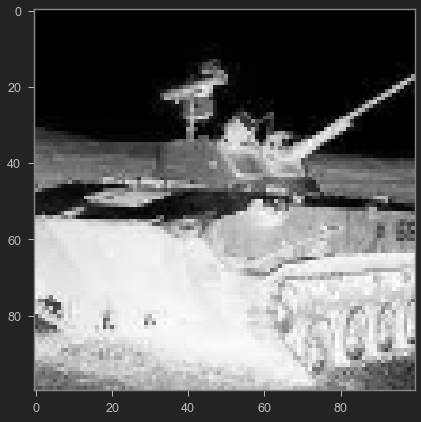

True class: Armored_tracked
Predicted probability:
Tank: 60%, Armored_tracked: 39%, Armored_wheeled: 0%, Artillery: 0% 


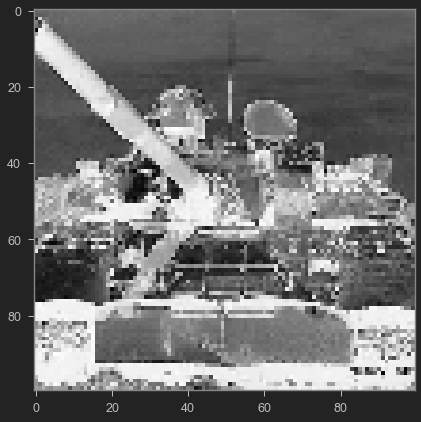

True class: Tank
Predicted probability:
Tank: 100%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 0% 


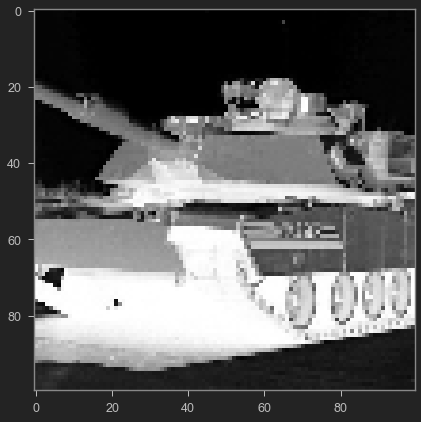

True class: Tank
Predicted probability:
Tank: 99%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 0% 


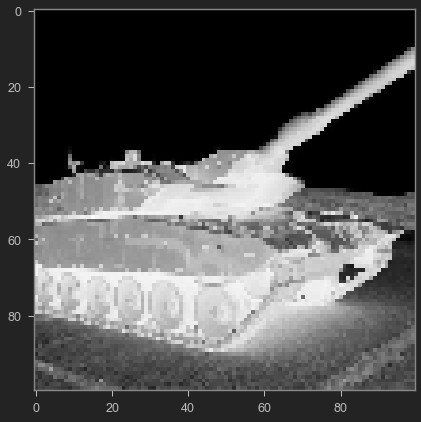

True class: Tank
Predicted probability:
Tank: 93%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 6% 


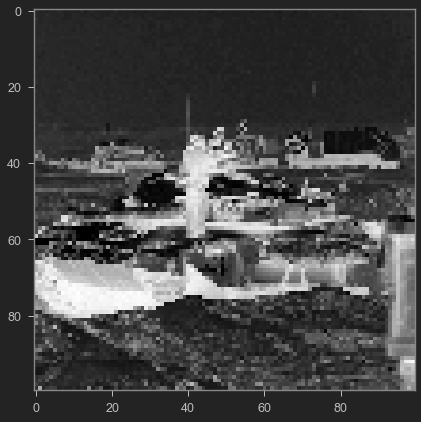

True class: Tank
Predicted probability:
Tank: 100%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 0% 


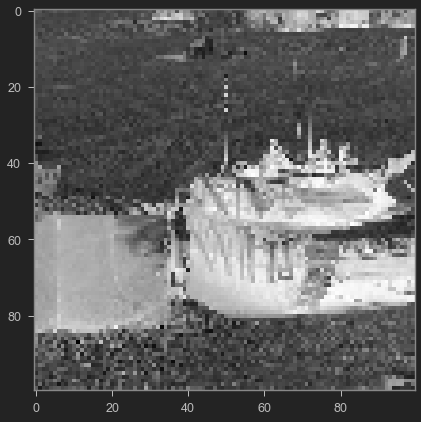

True class: Tank
Predicted probability:
Tank: 67%, Armored_tracked: 32%, Armored_wheeled: 0%, Artillery: 0% 


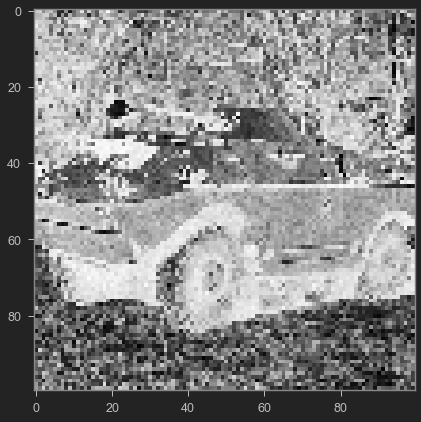

True class: Armored_wheeled
Predicted probability:
Tank: 0%, Armored_tracked: 0%, Armored_wheeled: 99%, Artillery: 0% 


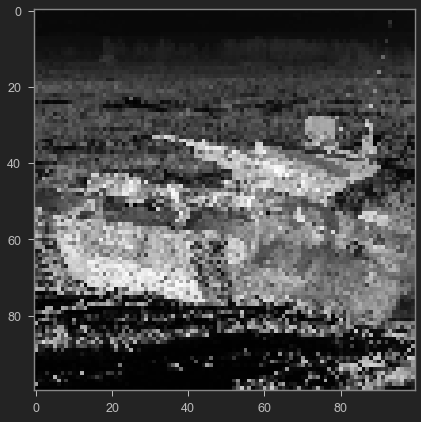

True class: Armored_tracked
Predicted probability:
Tank: 98%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 1% 


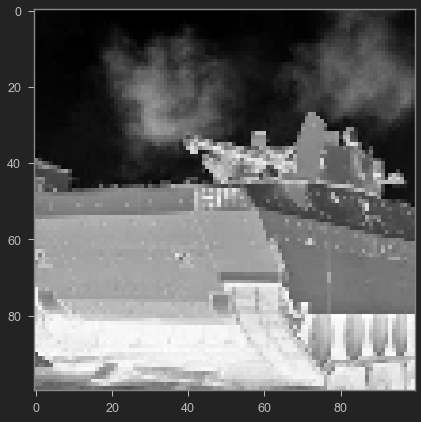

True class: Armored_tracked
Predicted probability:
Tank: 40%, Armored_tracked: 45%, Armored_wheeled: 13%, Artillery: 0% 


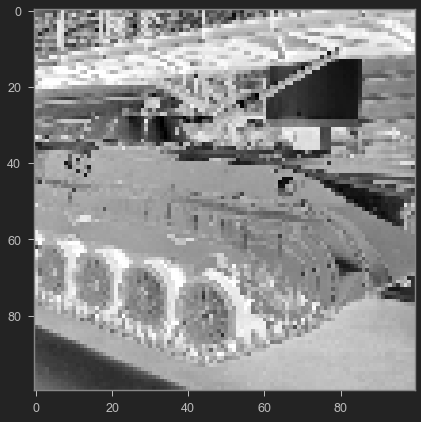

True class: Armored_tracked
Predicted probability:
Tank: 72%, Armored_tracked: 0%, Armored_wheeled: 26%, Artillery: 0% 


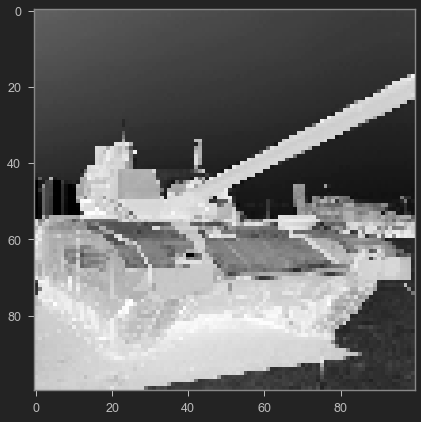

True class: Tank
Predicted probability:
Tank: 42%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 57% 


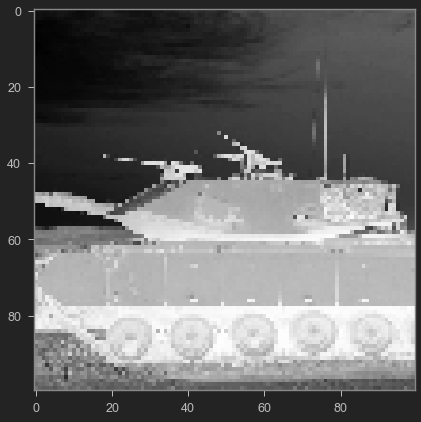

True class: Tank
Predicted probability:
Tank: 99%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 0% 


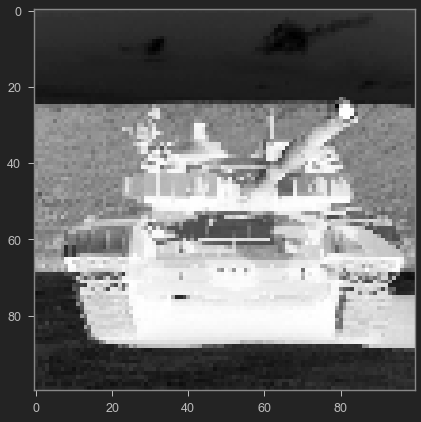

True class: Tank
Predicted probability:
Tank: 96%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 3% 


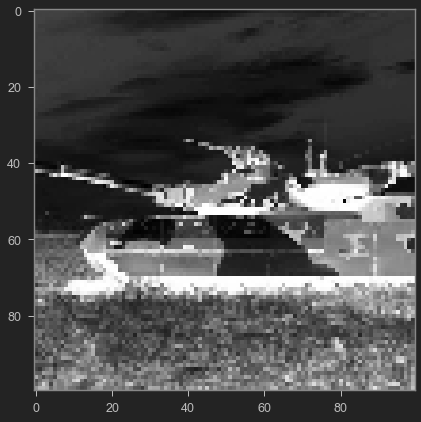

True class: Tank
Predicted probability:
Tank: 99%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 0% 


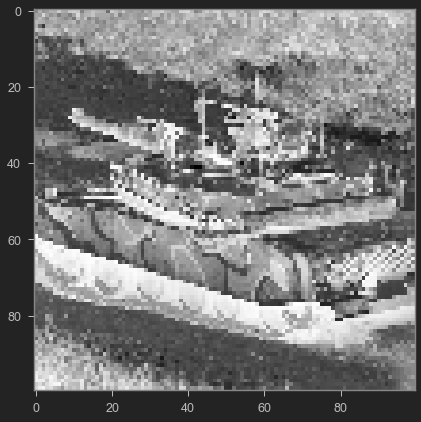

True class: Tank
Predicted probability:
Tank: 4%, Armored_tracked: 95%, Armored_wheeled: 0%, Artillery: 0% 


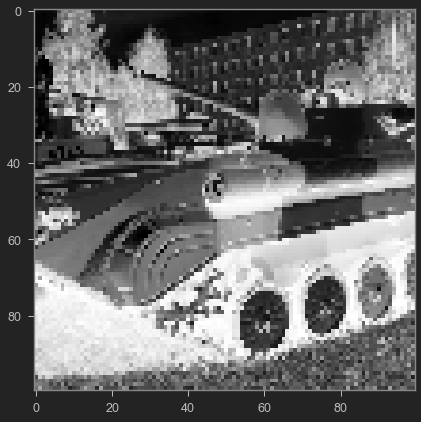

True class: Armored_tracked
Predicted probability:
Tank: 0%, Armored_tracked: 66%, Armored_wheeled: 18%, Artillery: 14% 


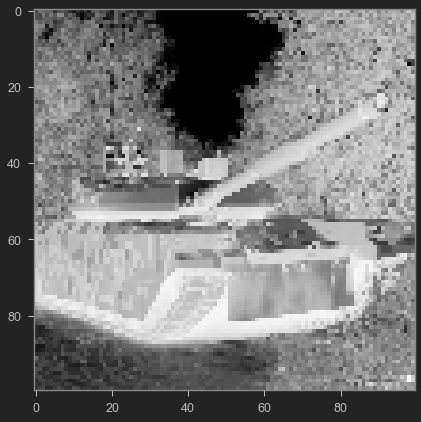

True class: Tank
Predicted probability:
Tank: 84%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 15% 


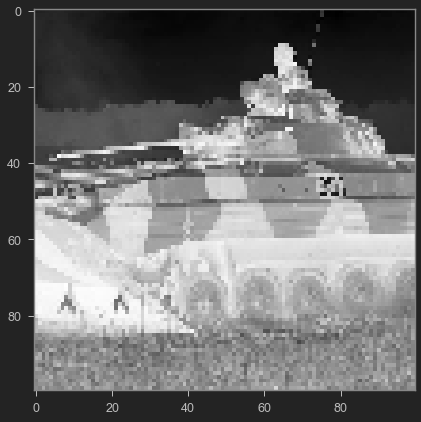

True class: Armored_tracked
Predicted probability:
Tank: 0%, Armored_tracked: 99%, Armored_wheeled: 0%, Artillery: 0% 


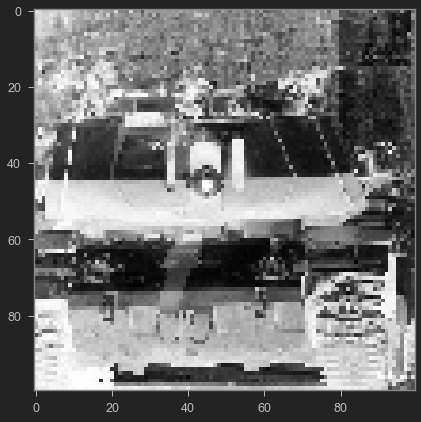

True class: Tank
Predicted probability:
Tank: 99%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 0% 


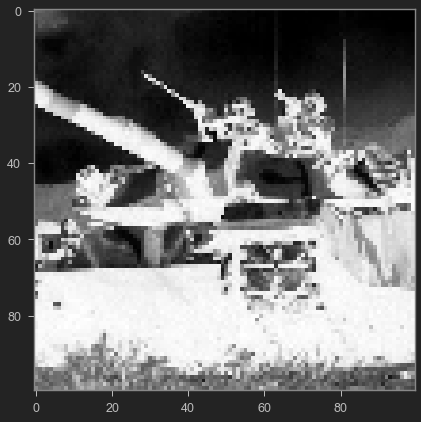

True class: Tank
Predicted probability:
Tank: 100%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 0% 


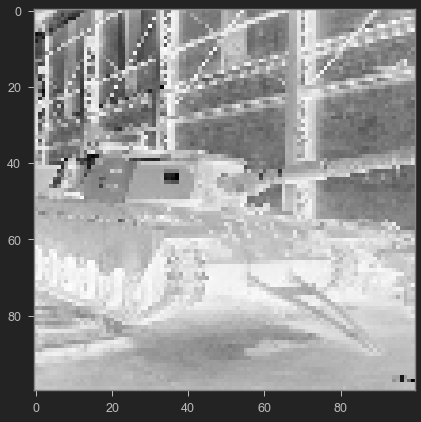

True class: Tank
Predicted probability:
Tank: 99%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 0% 


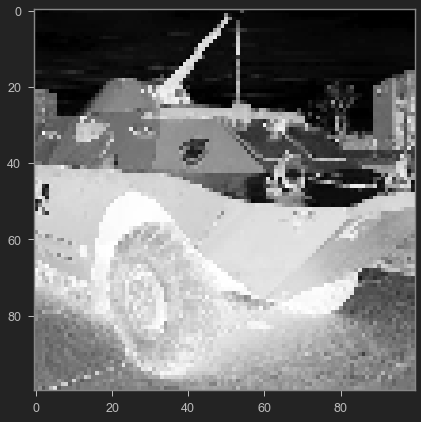

True class: Armored_wheeled
Predicted probability:
Tank: 0%, Armored_tracked: 0%, Armored_wheeled: 99%, Artillery: 0% 


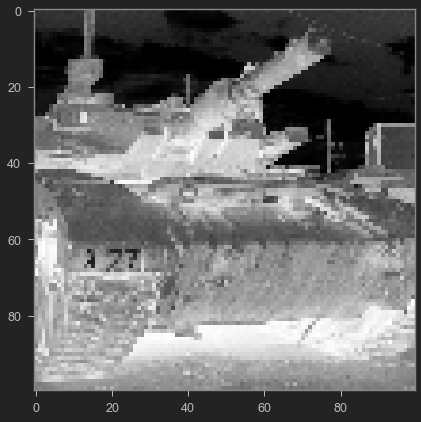

True class: Tank
Predicted probability:
Tank: 0%, Armored_tracked: 99%, Armored_wheeled: 0%, Artillery: 0% 


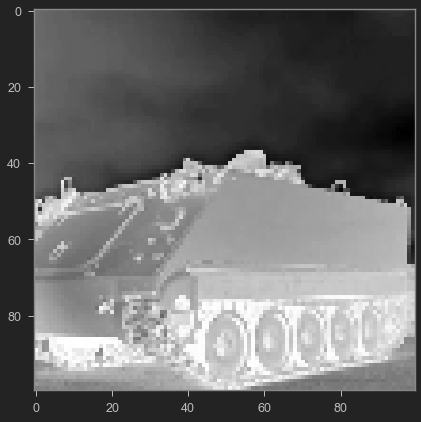

True class: Armored_tracked
Predicted probability:
Tank: 0%, Armored_tracked: 7%, Armored_wheeled: 91%, Artillery: 0% 


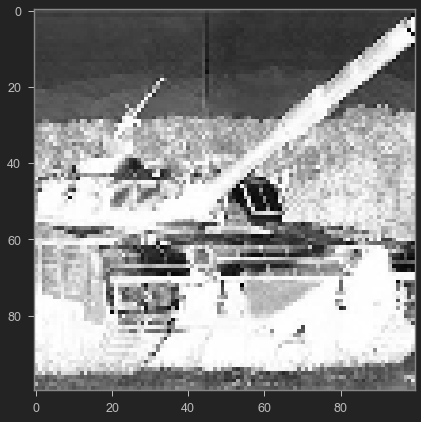

True class: Tank
Predicted probability:
Tank: 100%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 0% 


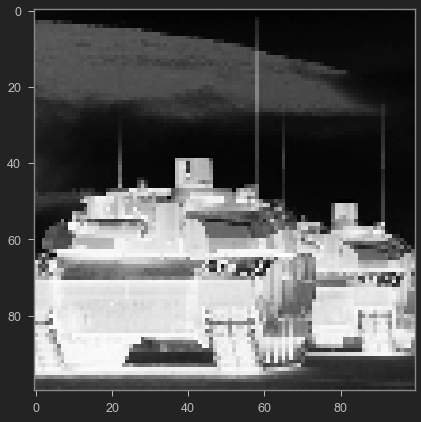

True class: Tank
Predicted probability:
Tank: 99%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 0% 


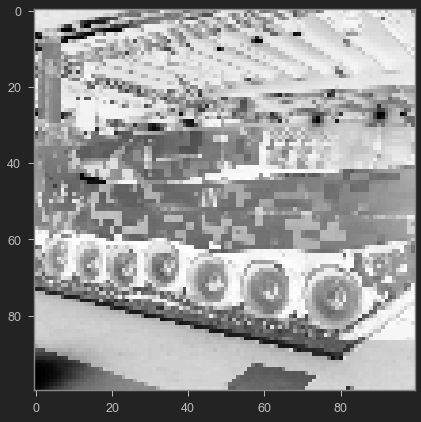

True class: Tank
Predicted probability:
Tank: 99%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 0% 


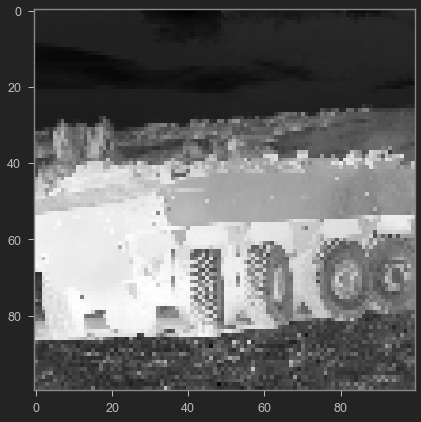

True class: Armored_wheeled
Predicted probability:
Tank: 0%, Armored_tracked: 15%, Armored_wheeled: 83%, Artillery: 0% 


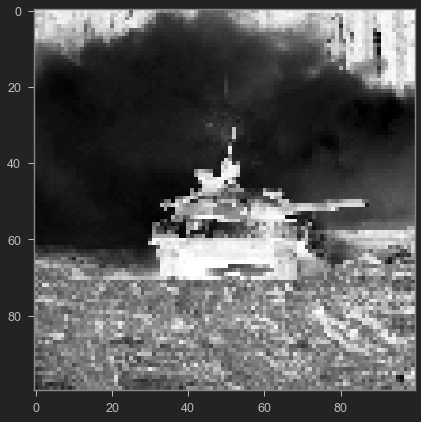

True class: Tank
Predicted probability:
Tank: 99%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 0% 


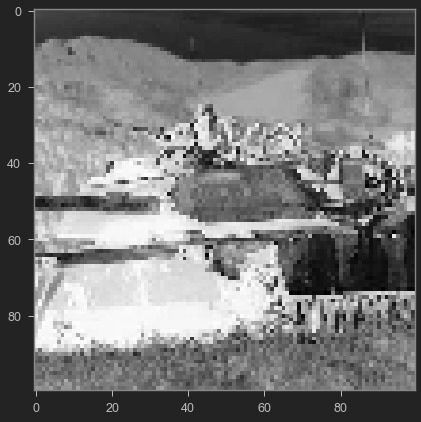

True class: Tank
Predicted probability:
Tank: 99%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 0% 


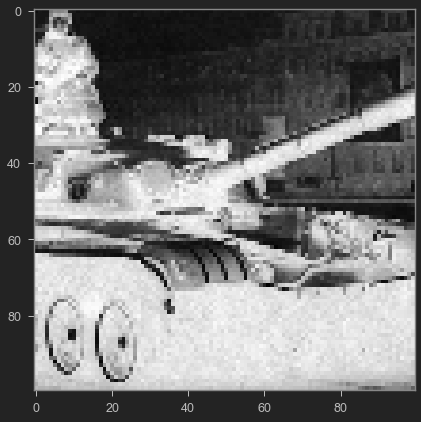

True class: Tank
Predicted probability:
Tank: 100%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 0% 


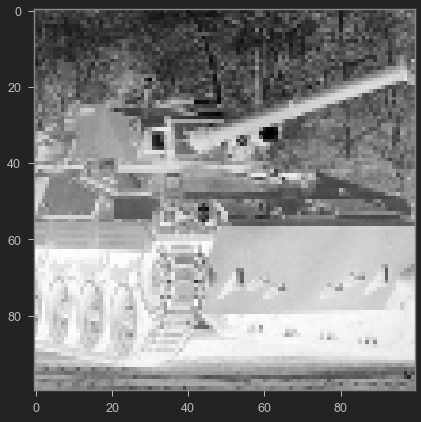

True class: Tank
Predicted probability:
Tank: 58%, Armored_tracked: 41%, Armored_wheeled: 0%, Artillery: 0% 


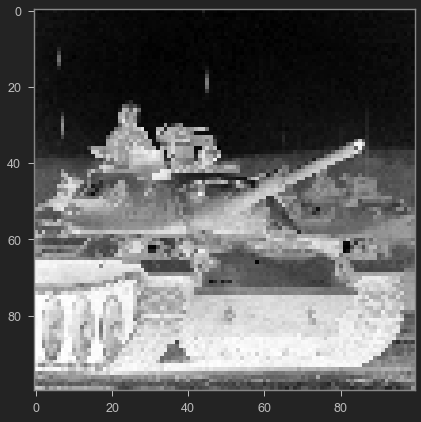

True class: Tank
Predicted probability:
Tank: 99%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 0% 


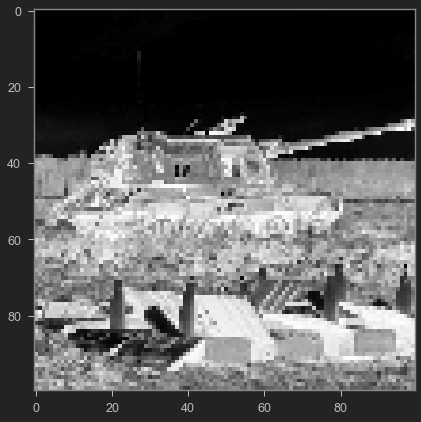

True class: Artillery
Predicted probability:
Tank: 94%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 5% 


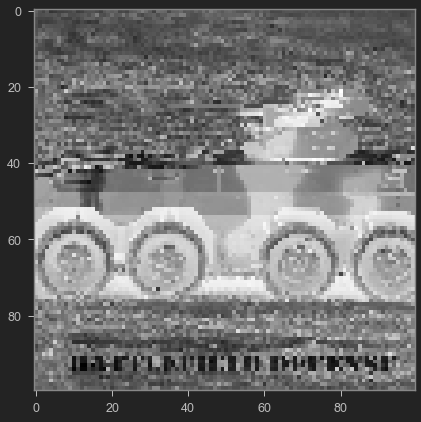

True class: Armored_wheeled
Predicted probability:
Tank: 71%, Armored_tracked: 24%, Armored_wheeled: 3%, Artillery: 0% 


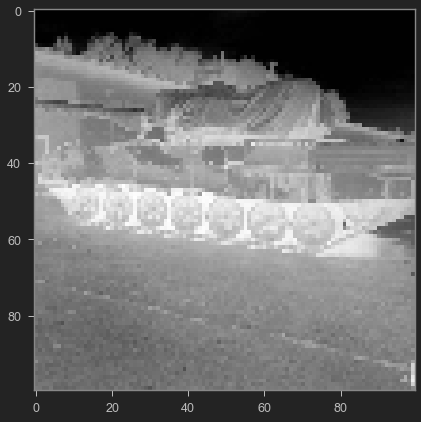

True class: Tank
Predicted probability:
Tank: 98%, Armored_tracked: 0%, Armored_wheeled: 1%, Artillery: 0% 


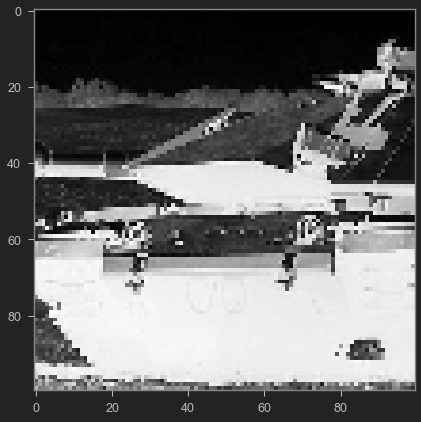

True class: Tank
Predicted probability:
Tank: 100%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 0% 


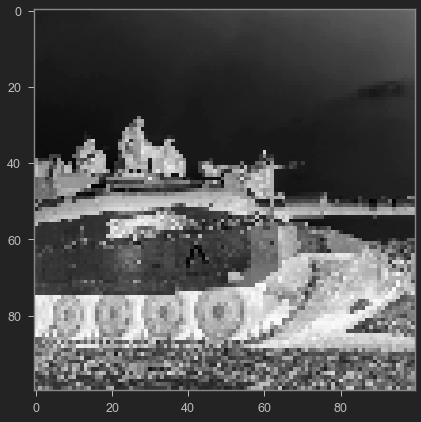

True class: Tank
Predicted probability:
Tank: 100%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 0% 


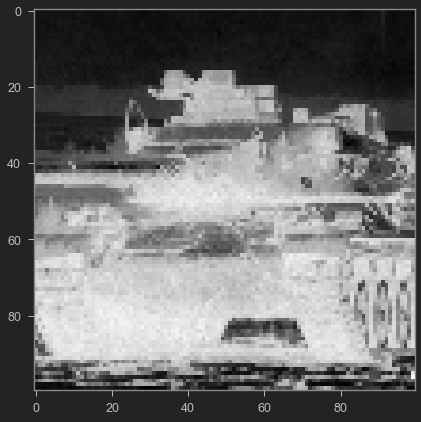

True class: Tank
Predicted probability:
Tank: 59%, Armored_tracked: 36%, Armored_wheeled: 4%, Artillery: 0% 


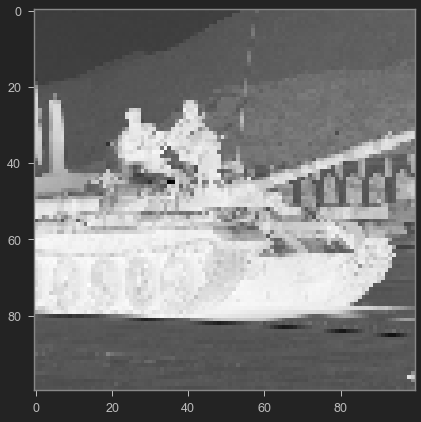

True class: Tank
Predicted probability:
Tank: 43%, Armored_tracked: 1%, Armored_wheeled: 0%, Artillery: 55% 


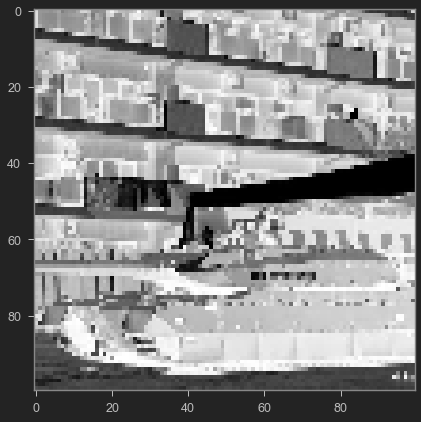

True class: Tank
Predicted probability:
Tank: 0%, Armored_tracked: 0%, Armored_wheeled: 99%, Artillery: 0% 


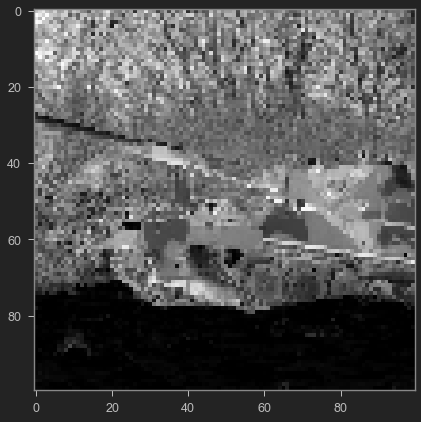

True class: Artillery
Predicted probability:
Tank: 99%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 0% 


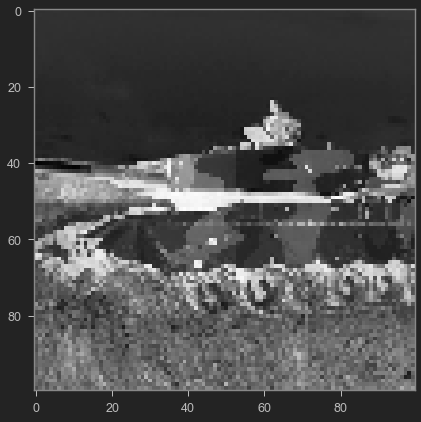

True class: Tank
Predicted probability:
Tank: 100%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 0% 


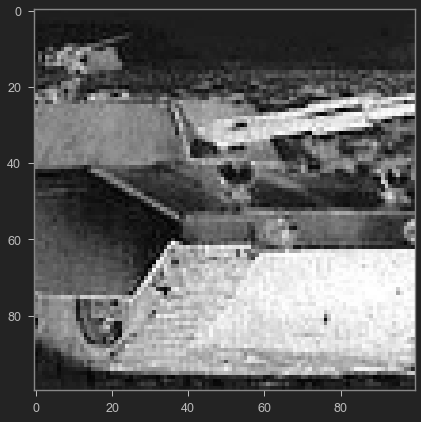

True class: Tank
Predicted probability:
Tank: 99%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 0% 


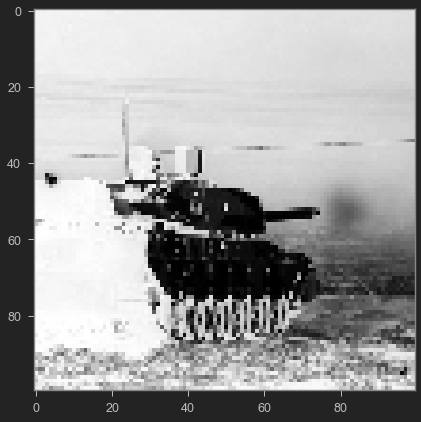

True class: Tank
Predicted probability:
Tank: 100%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 0% 


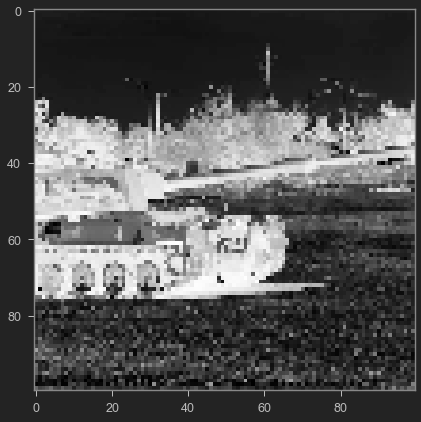

True class: Artillery
Predicted probability:
Tank: 99%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 0% 


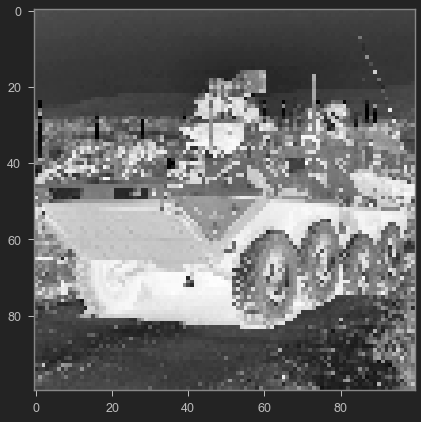

True class: Armored_wheeled
Predicted probability:
Tank: 1%, Armored_tracked: 4%, Armored_wheeled: 94%, Artillery: 0% 


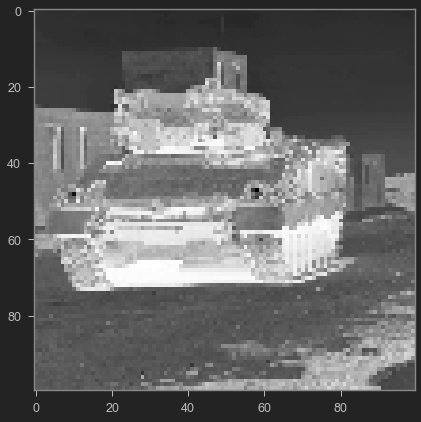

True class: Armored_tracked
Predicted probability:
Tank: 99%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 0% 


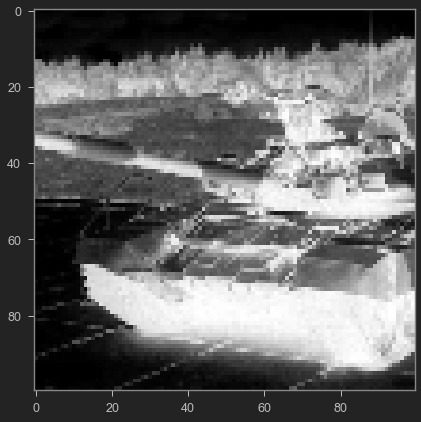

True class: Tank
Predicted probability:
Tank: 100%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 0% 


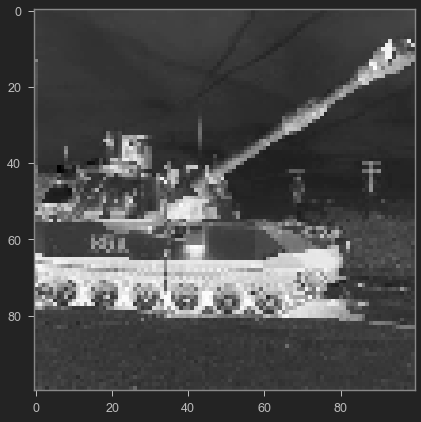

True class: Artillery
Predicted probability:
Tank: 14%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 85% 


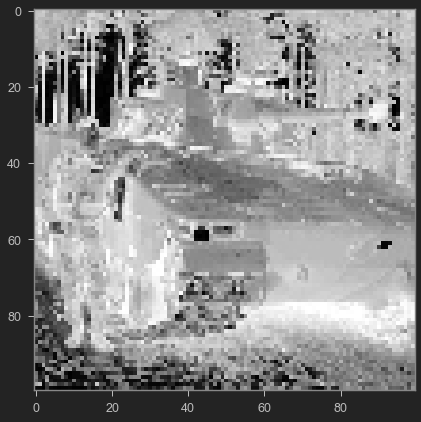

True class: Armored_tracked
Predicted probability:
Tank: 8%, Armored_tracked: 22%, Armored_wheeled: 69%, Artillery: 0% 


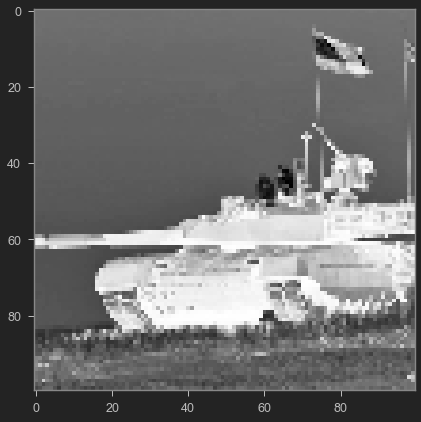

True class: Tank
Predicted probability:
Tank: 99%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 0% 


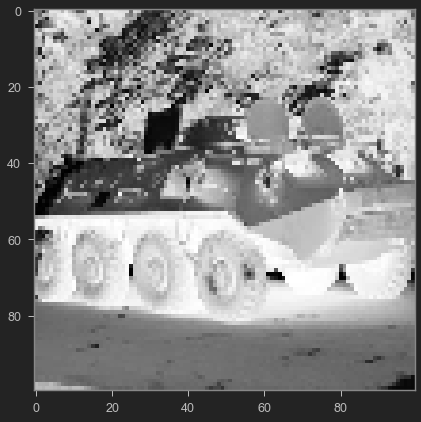

True class: Armored_wheeled
Predicted probability:
Tank: 9%, Armored_tracked: 78%, Armored_wheeled: 12%, Artillery: 0% 


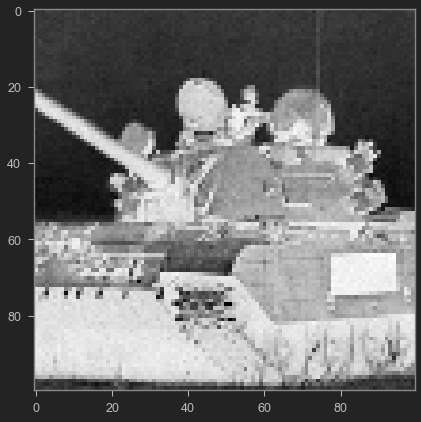

True class: Tank
Predicted probability:
Tank: 0%, Armored_tracked: 47%, Armored_wheeled: 52%, Artillery: 0% 


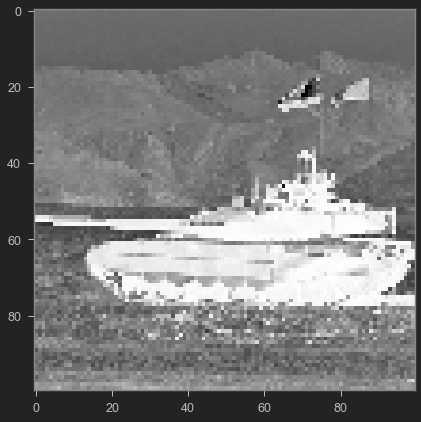

True class: Tank
Predicted probability:
Tank: 99%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 0% 


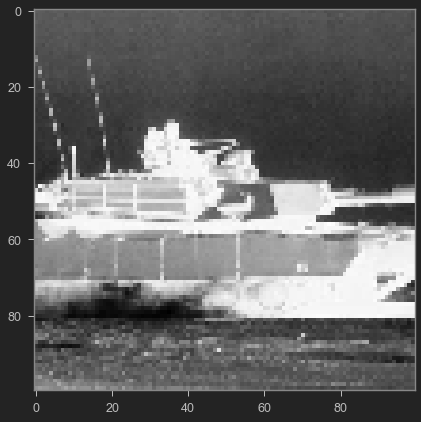

True class: Tank
Predicted probability:
Tank: 15%, Armored_tracked: 84%, Armored_wheeled: 0%, Artillery: 0% 


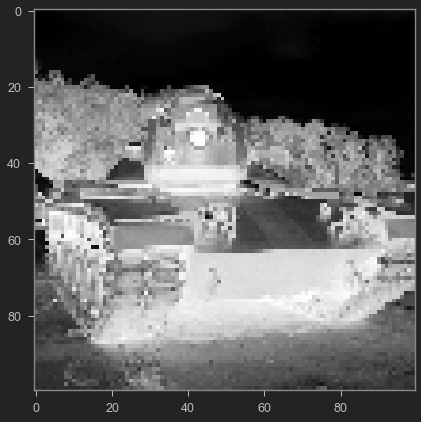

True class: Tank
Predicted probability:
Tank: 99%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 0% 


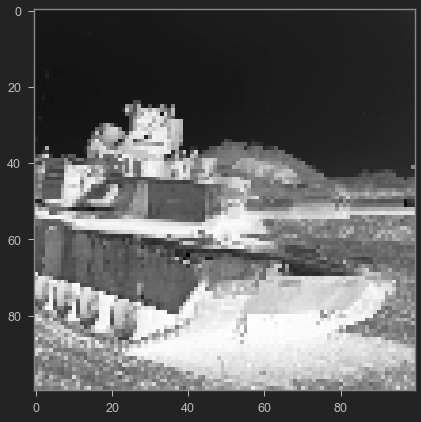

True class: Tank
Predicted probability:
Tank: 100%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 0% 


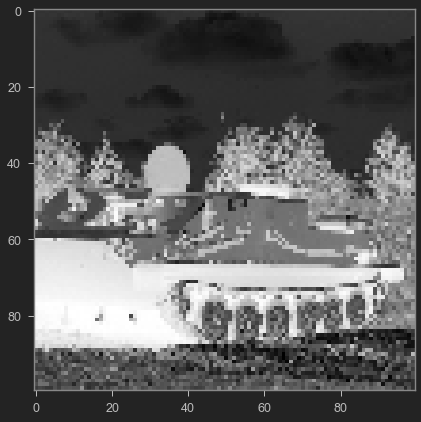

True class: Armored_tracked
Predicted probability:
Tank: 99%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 0% 


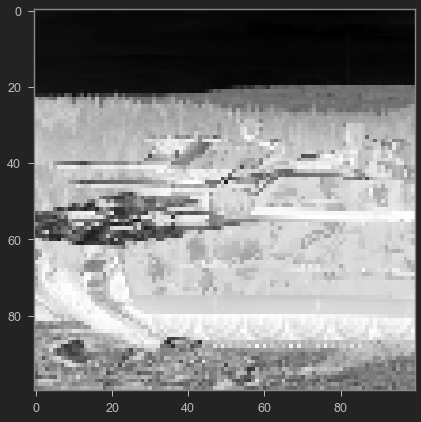

True class: Armored_tracked
Predicted probability:
Tank: 99%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 0% 


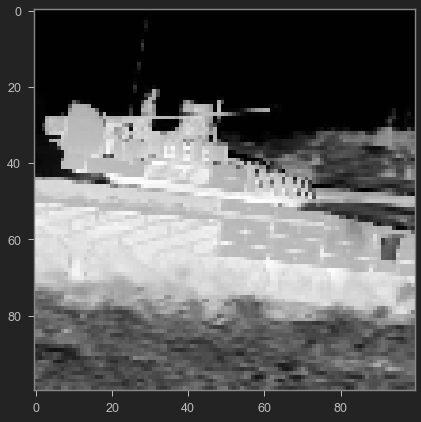

True class: Tank
Predicted probability:
Tank: 97%, Armored_tracked: 2%, Armored_wheeled: 0%, Artillery: 0% 


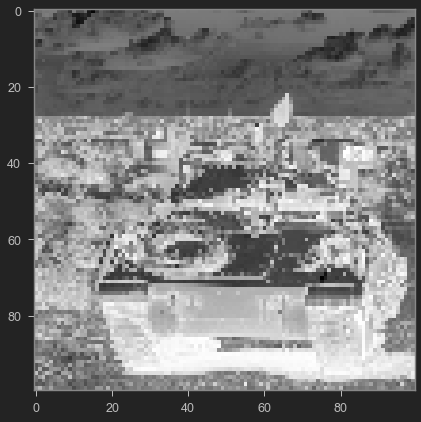

True class: Armored_tracked
Predicted probability:
Tank: 99%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 0% 


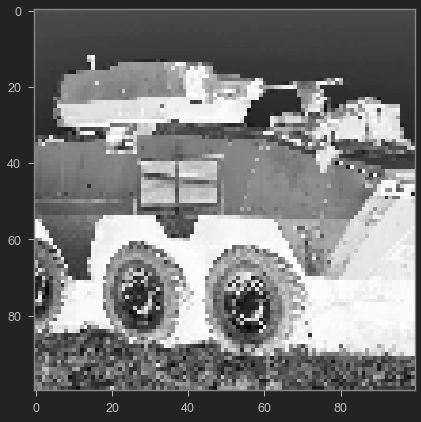

True class: Armored_wheeled
Predicted probability:
Tank: 0%, Armored_tracked: 0%, Armored_wheeled: 100%, Artillery: 0% 


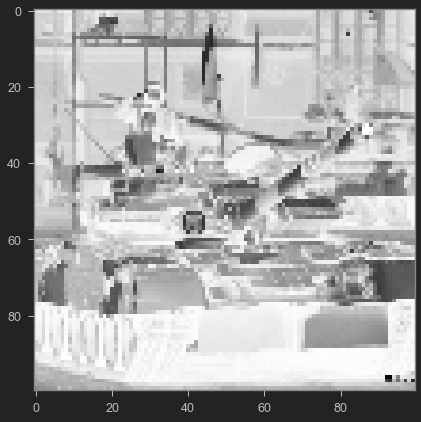

True class: Tank
Predicted probability:
Tank: 1%, Armored_tracked: 97%, Armored_wheeled: 0%, Artillery: 0% 


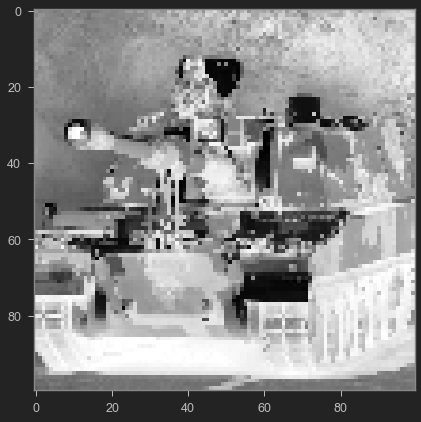

True class: Artillery
Predicted probability:
Tank: 22%, Armored_tracked: 49%, Armored_wheeled: 27%, Artillery: 0% 


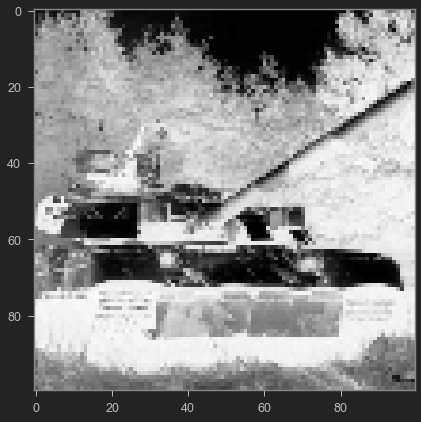

True class: Tank
Predicted probability:
Tank: 100%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 0% 


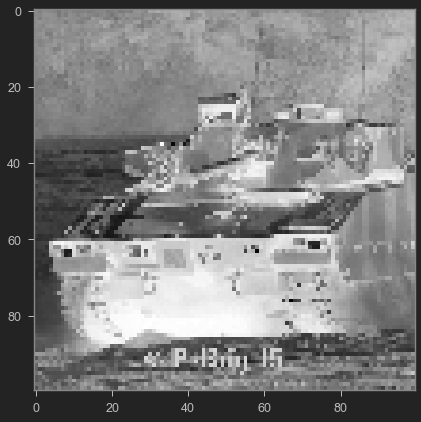

True class: Armored_tracked
Predicted probability:
Tank: 33%, Armored_tracked: 31%, Armored_wheeled: 29%, Artillery: 4% 


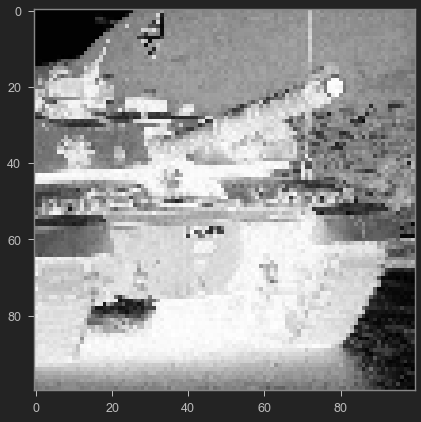

True class: Tank
Predicted probability:
Tank: 94%, Armored_tracked: 0%, Armored_wheeled: 5%, Artillery: 0% 


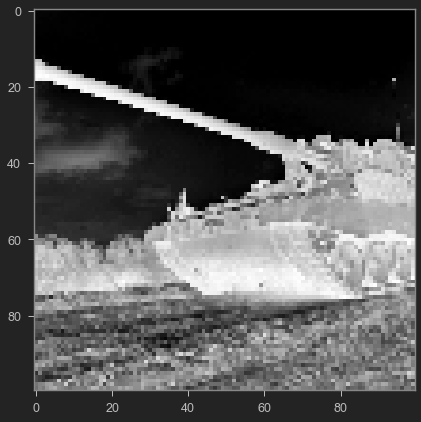

True class: Artillery
Predicted probability:
Tank: 0%, Armored_tracked: 0%, Armored_wheeled: 99%, Artillery: 0% 


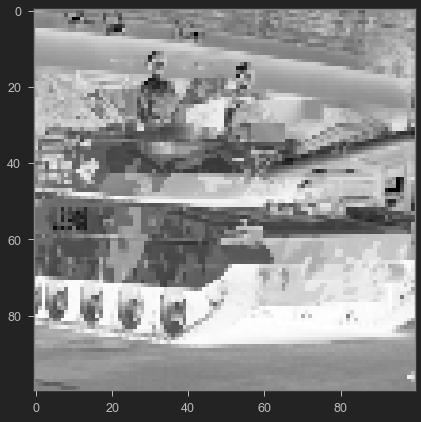

True class: Tank
Predicted probability:
Tank: 100%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 0% 


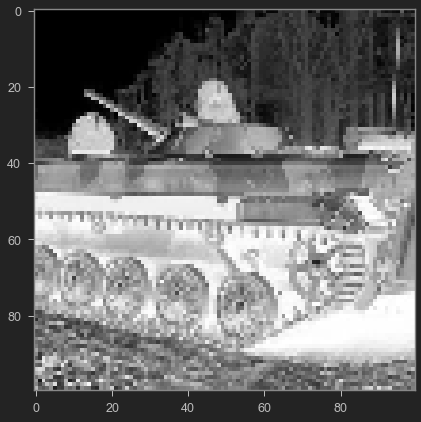

True class: Armored_tracked
Predicted probability:
Tank: 99%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 0% 


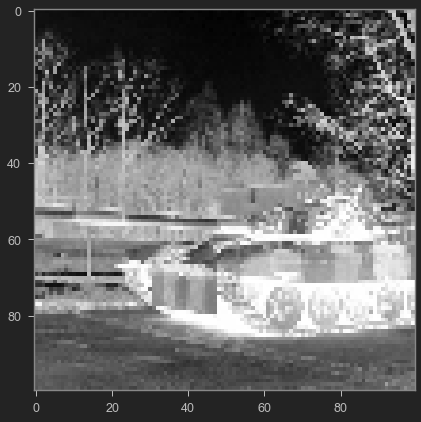

True class: Tank
Predicted probability:
Tank: 99%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 0% 


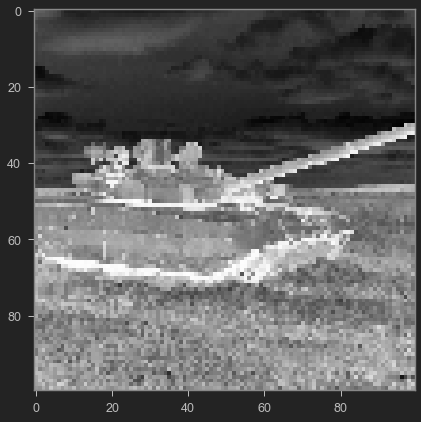

True class: Tank
Predicted probability:
Tank: 99%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 0% 


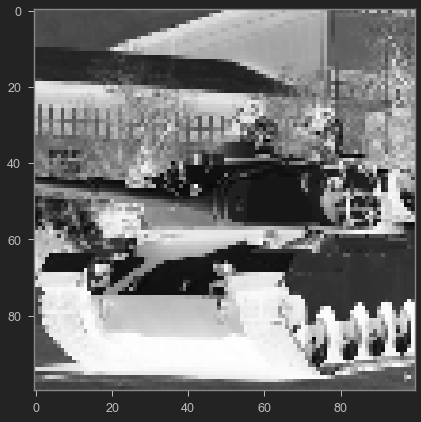

True class: Tank
Predicted probability:
Tank: 0%, Armored_tracked: 97%, Armored_wheeled: 2%, Artillery: 0% 


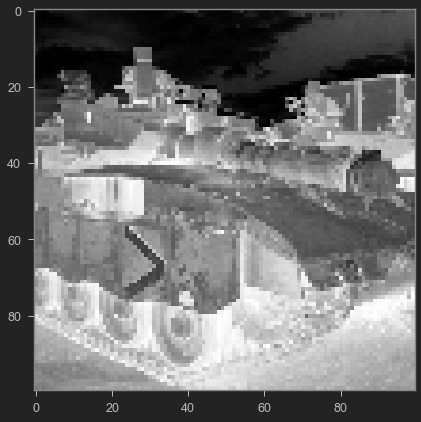

True class: Tank
Predicted probability:
Tank: 2%, Armored_tracked: 96%, Armored_wheeled: 0%, Artillery: 0% 


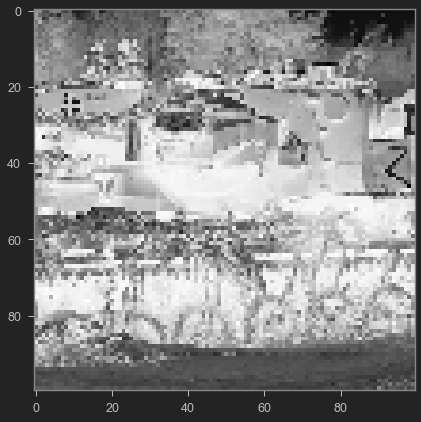

True class: Armored_tracked
Predicted probability:
Tank: 99%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 0% 


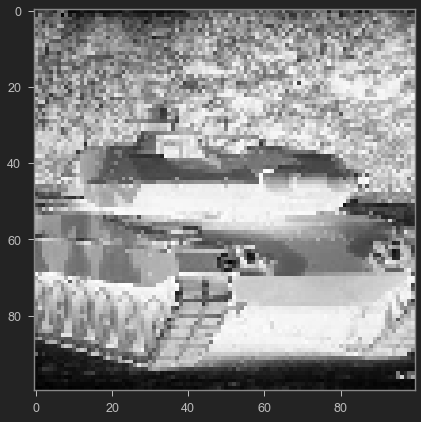

True class: Tank
Predicted probability:
Tank: 100%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 0% 


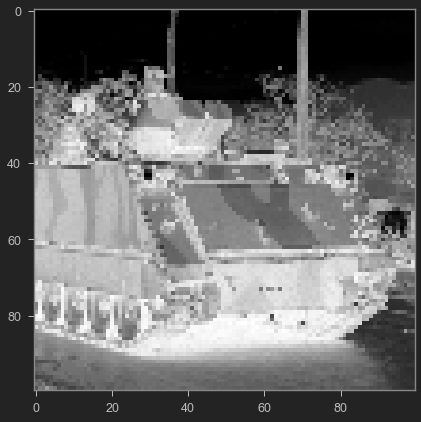

True class: Armored_tracked
Predicted probability:
Tank: 0%, Armored_tracked: 99%, Armored_wheeled: 0%, Artillery: 0% 


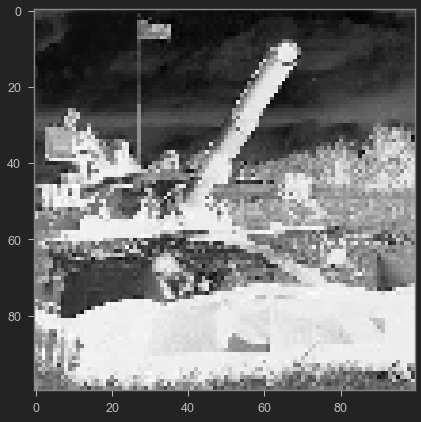

True class: Tank
Predicted probability:
Tank: 100%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 0% 


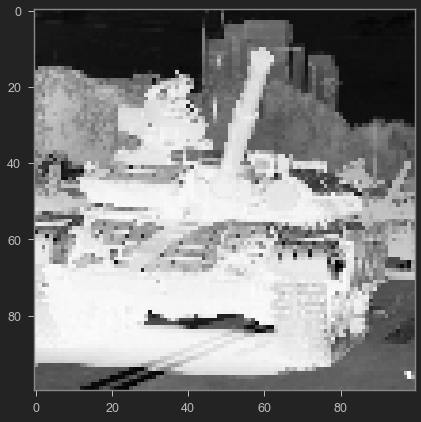

True class: Tank
Predicted probability:
Tank: 99%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 0% 


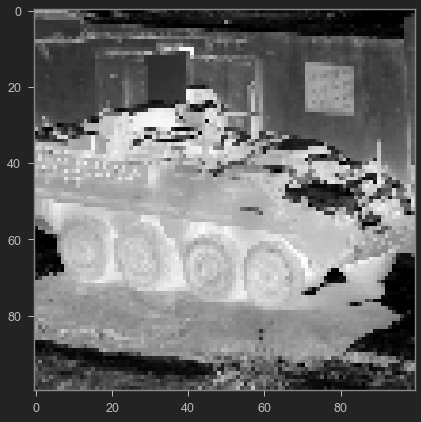

True class: Armored_wheeled
Predicted probability:
Tank: 0%, Armored_tracked: 95%, Armored_wheeled: 4%, Artillery: 0% 


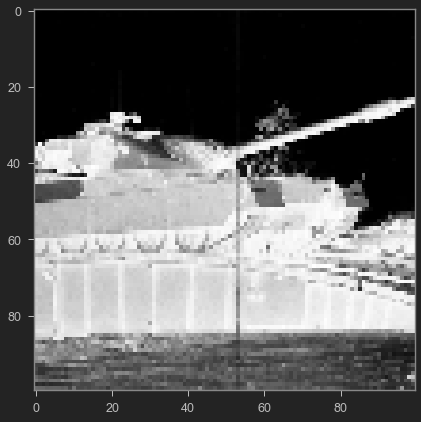

True class: Tank
Predicted probability:
Tank: 66%, Armored_tracked: 0%, Armored_wheeled: 28%, Artillery: 4% 


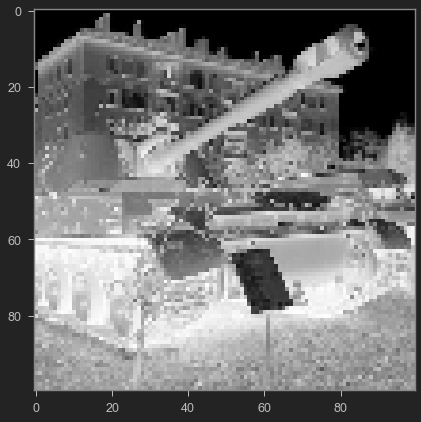

True class: Artillery
Predicted probability:
Tank: 0%, Armored_tracked: 99%, Armored_wheeled: 0%, Artillery: 0% 


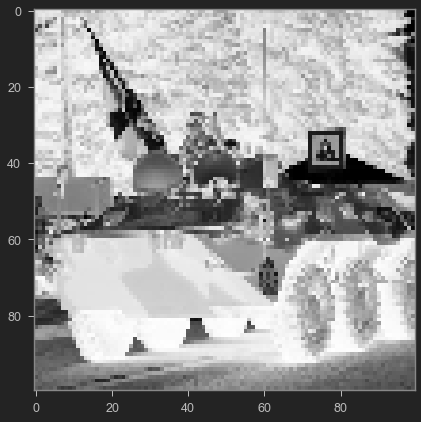

True class: Armored_wheeled
Predicted probability:
Tank: 0%, Armored_tracked: 100%, Armored_wheeled: 0%, Artillery: 0% 


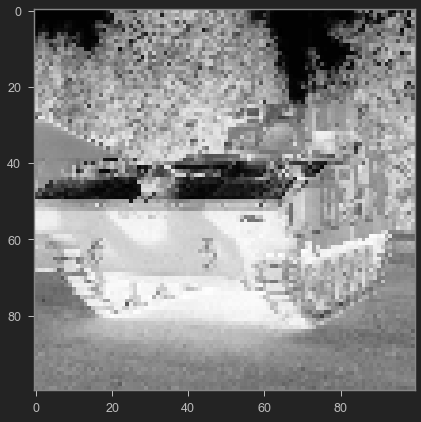

True class: Armored_tracked
Predicted probability:
Tank: 0%, Armored_tracked: 0%, Armored_wheeled: 99%, Artillery: 0% 


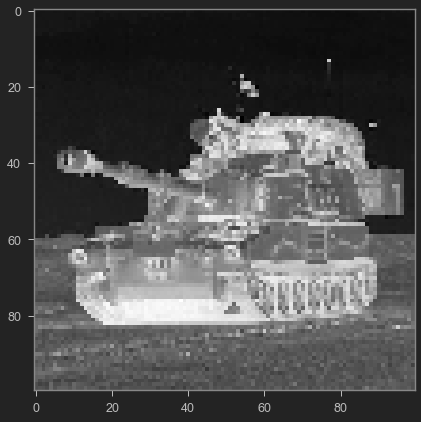

True class: Artillery
Predicted probability:
Tank: 99%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 0% 


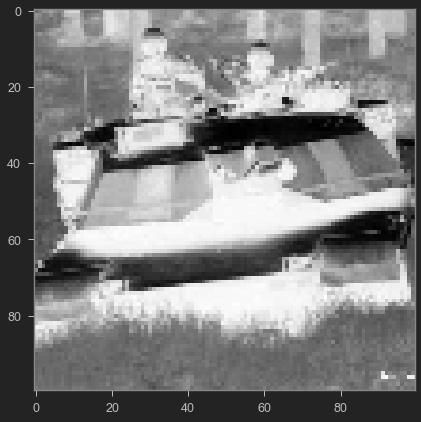

True class: Tank
Predicted probability:
Tank: 100%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 0% 


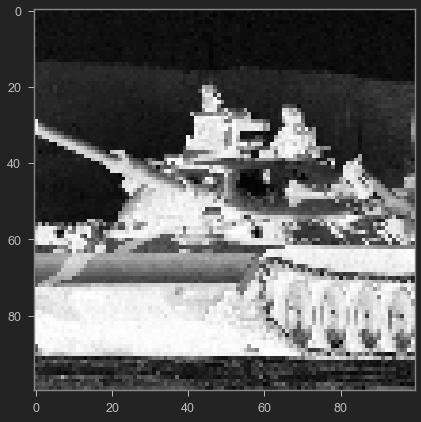

True class: Tank
Predicted probability:
Tank: 0%, Armored_tracked: 0%, Armored_wheeled: 99%, Artillery: 0% 


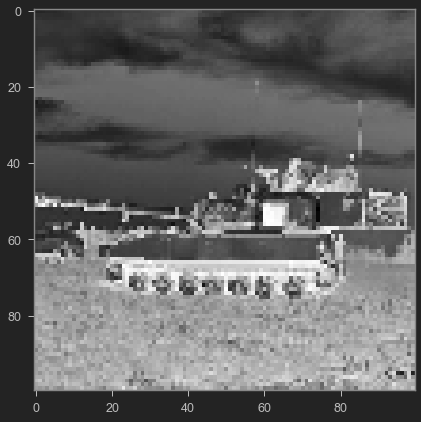

True class: Artillery
Predicted probability:
Tank: 99%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 0% 


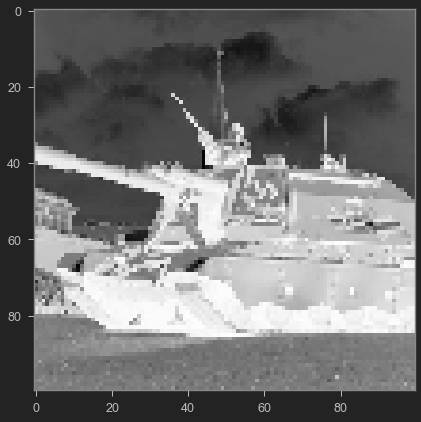

True class: Artillery
Predicted probability:
Tank: 100%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 0% 


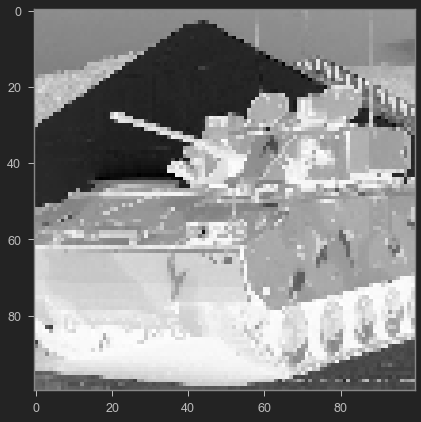

True class: Armored_tracked
Predicted probability:
Tank: 0%, Armored_tracked: 99%, Armored_wheeled: 0%, Artillery: 0% 


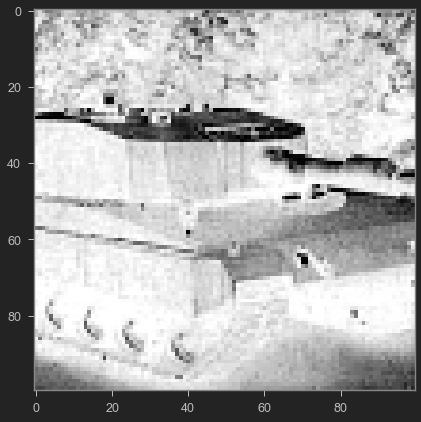

True class: Tank
Predicted probability:
Tank: 100%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 0% 


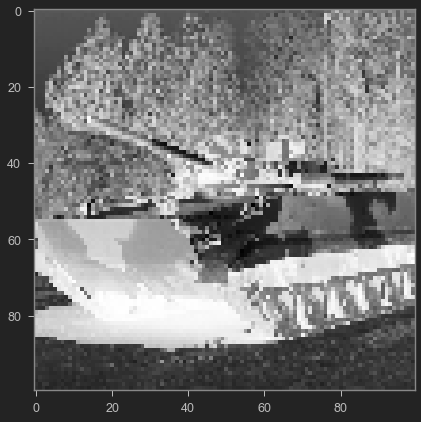

True class: Armored_tracked
Predicted probability:
Tank: 0%, Armored_tracked: 100%, Armored_wheeled: 0%, Artillery: 0% 


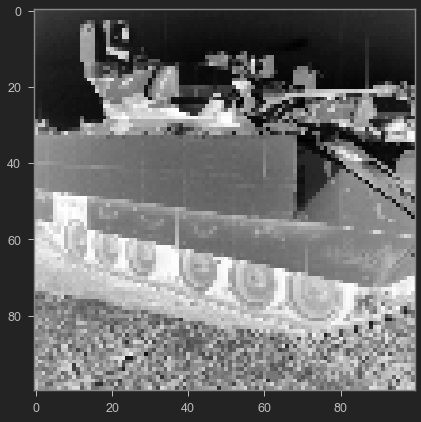

True class: Armored_tracked
Predicted probability:
Tank: 1%, Armored_tracked: 50%, Armored_wheeled: 39%, Artillery: 9% 


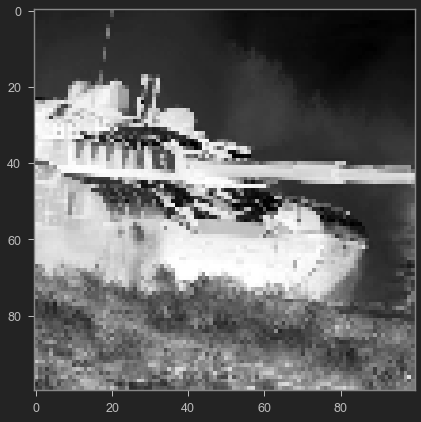

True class: Tank
Predicted probability:
Tank: 100%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 0% 


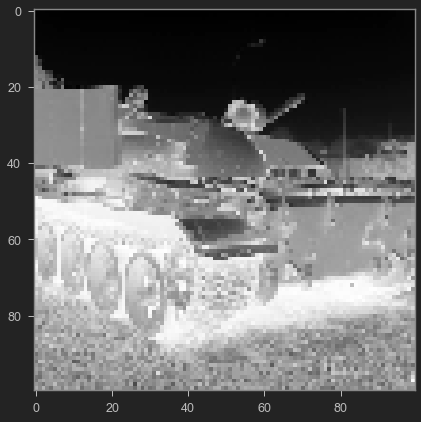

True class: Tank
Predicted probability:
Tank: 4%, Armored_tracked: 95%, Armored_wheeled: 0%, Artillery: 0% 


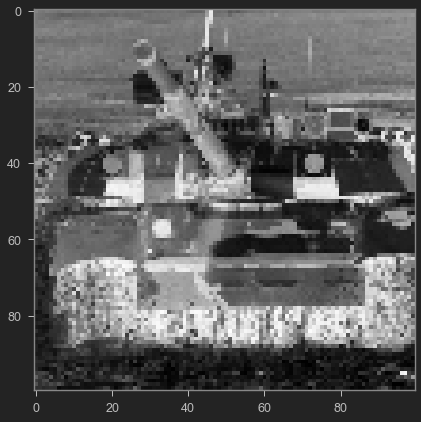

True class: Tank
Predicted probability:
Tank: 99%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 0% 


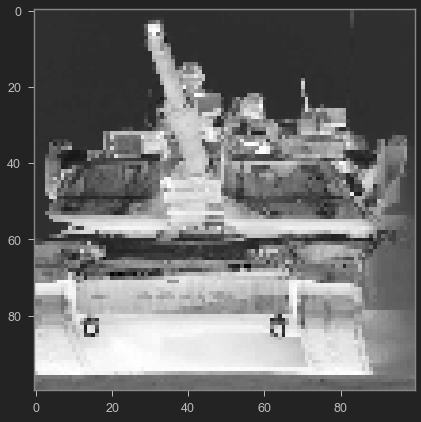

True class: Tank
Predicted probability:
Tank: 100%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 0% 


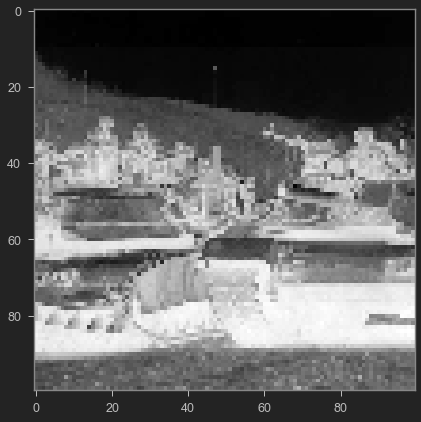

True class: Tank
Predicted probability:
Tank: 99%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 0% 


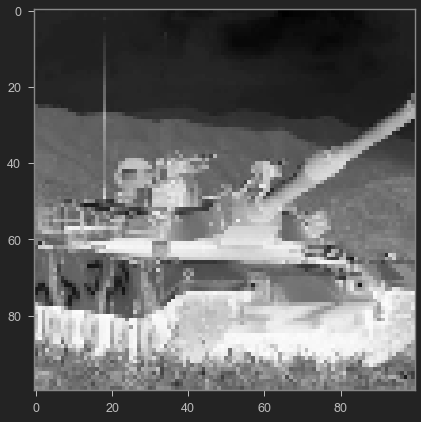

True class: Tank
Predicted probability:
Tank: 99%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 0% 


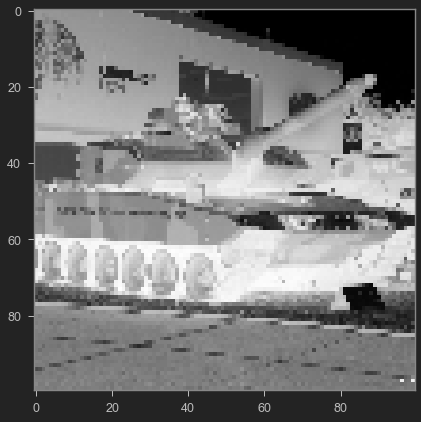

True class: Tank
Predicted probability:
Tank: 99%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 0% 


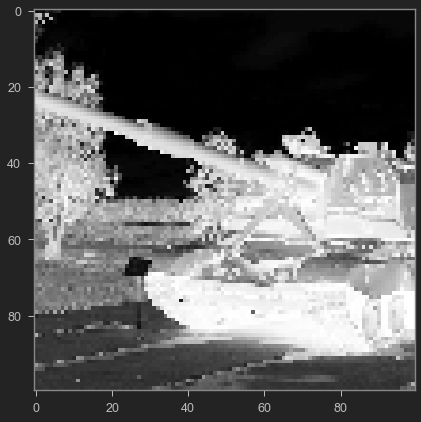

True class: Artillery
Predicted probability:
Tank: 0%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 99% 


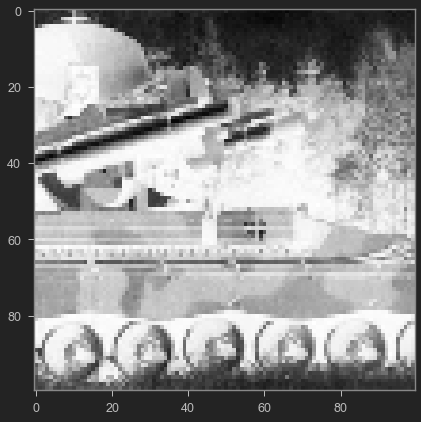

True class: Armored_tracked
Predicted probability:
Tank: 99%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 0% 


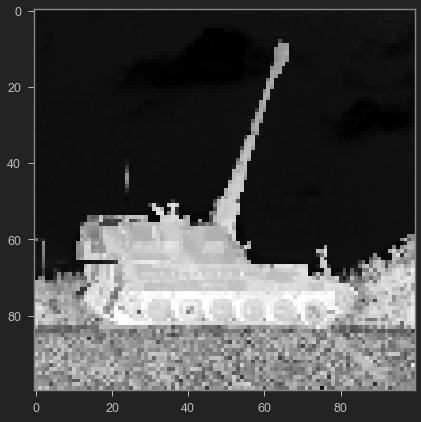

True class: Artillery
Predicted probability:
Tank: 83%, Armored_tracked: 16%, Armored_wheeled: 0%, Artillery: 0% 


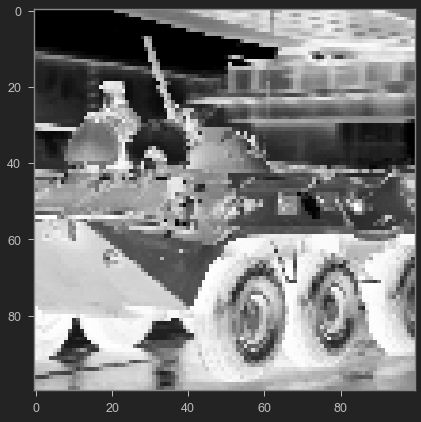

True class: Armored_wheeled
Predicted probability:
Tank: 1%, Armored_tracked: 0%, Armored_wheeled: 97%, Artillery: 0% 


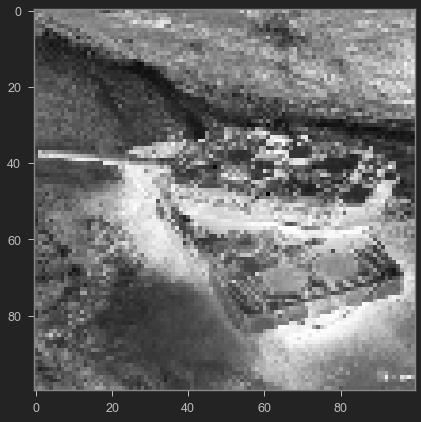

True class: Tank
Predicted probability:
Tank: 99%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 0% 


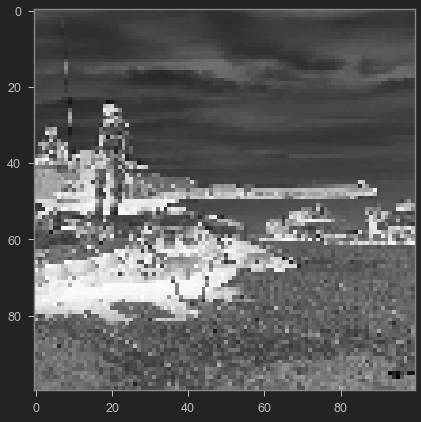

True class: Tank
Predicted probability:
Tank: 99%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 0% 


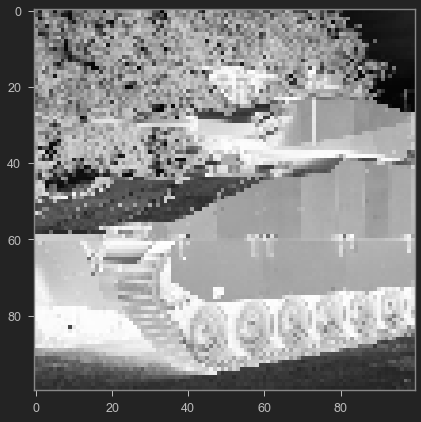

True class: Armored_tracked
Predicted probability:
Tank: 0%, Armored_tracked: 99%, Armored_wheeled: 0%, Artillery: 0% 


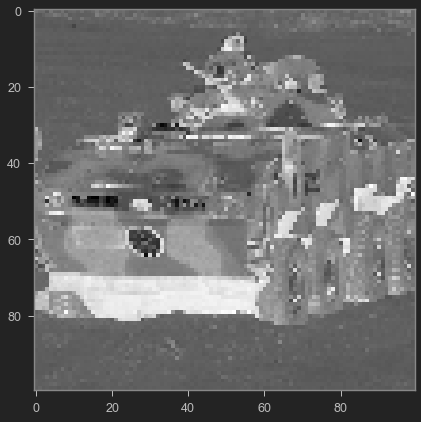

True class: Armored_wheeled
Predicted probability:
Tank: 89%, Armored_tracked: 9%, Armored_wheeled: 0%, Artillery: 0% 


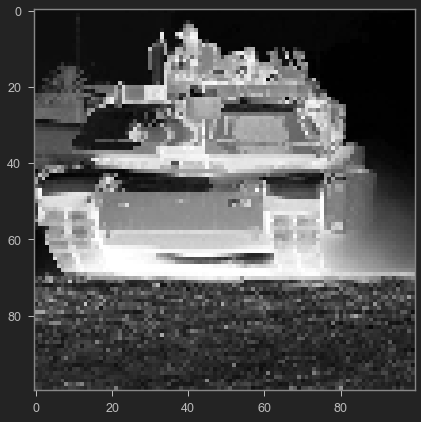

True class: Tank
Predicted probability:
Tank: 34%, Armored_tracked: 61%, Armored_wheeled: 4%, Artillery: 0% 


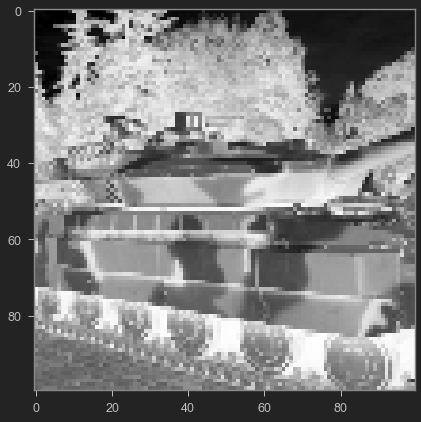

True class: Tank
Predicted probability:
Tank: 100%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 0% 


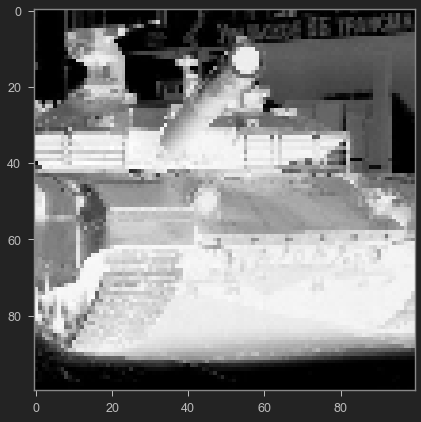

True class: Tank
Predicted probability:
Tank: 57%, Armored_tracked: 41%, Armored_wheeled: 0%, Artillery: 0% 


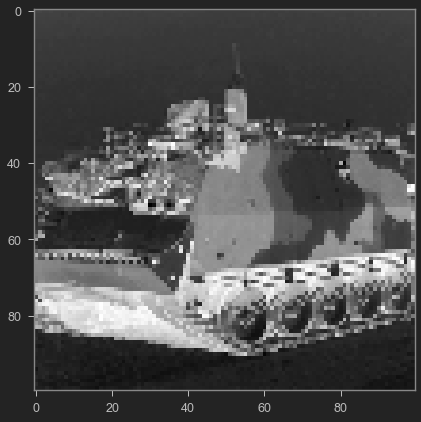

True class: Armored_tracked
Predicted probability:
Tank: 89%, Armored_tracked: 10%, Armored_wheeled: 0%, Artillery: 0% 


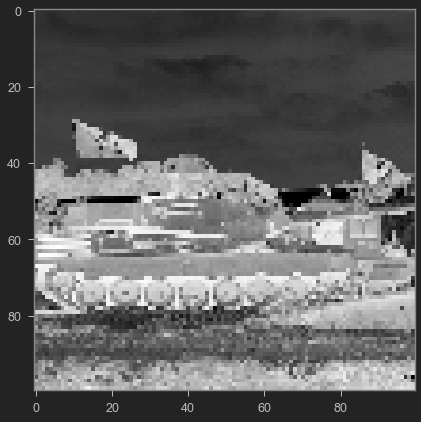

True class: Tank
Predicted probability:
Tank: 99%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 0% 


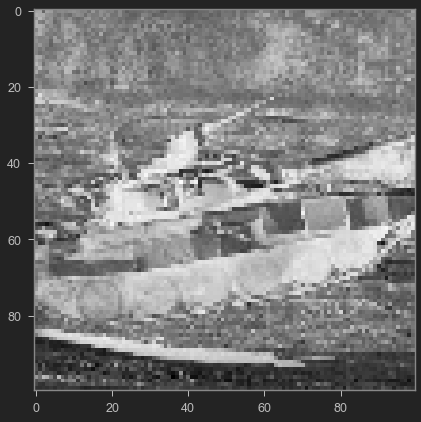

True class: Tank
Predicted probability:
Tank: 23%, Armored_tracked: 18%, Armored_wheeled: 54%, Artillery: 4% 


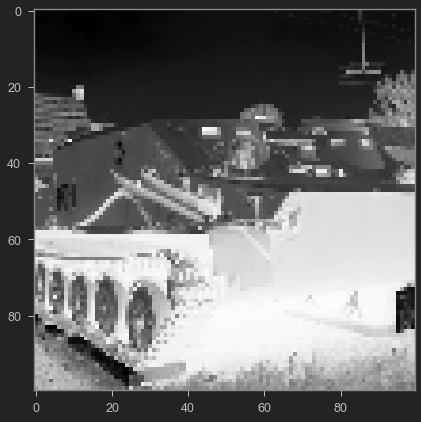

True class: Armored_tracked
Predicted probability:
Tank: 0%, Armored_tracked: 0%, Armored_wheeled: 99%, Artillery: 0% 


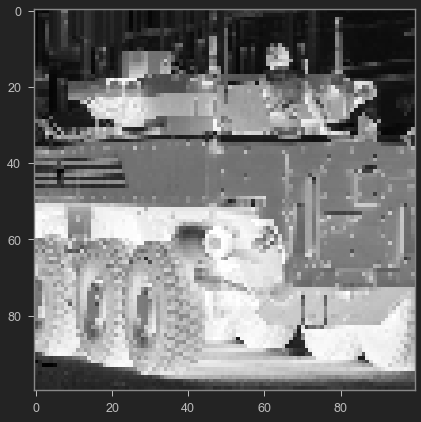

True class: Armored_wheeled
Predicted probability:
Tank: 9%, Armored_tracked: 0%, Armored_wheeled: 90%, Artillery: 0% 


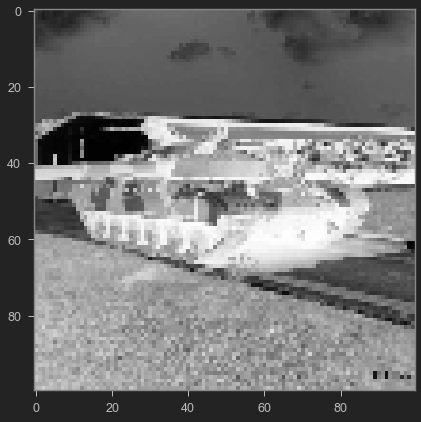

True class: Tank
Predicted probability:
Tank: 99%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 0% 


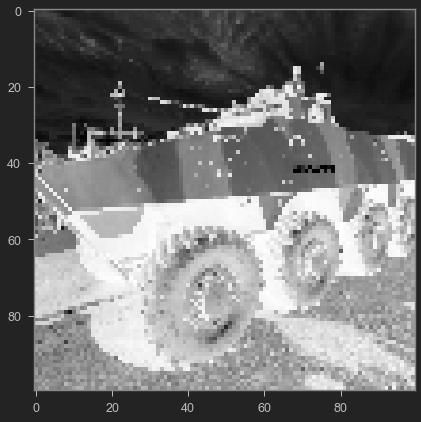

True class: Armored_wheeled
Predicted probability:
Tank: 0%, Armored_tracked: 0%, Armored_wheeled: 99%, Artillery: 0% 


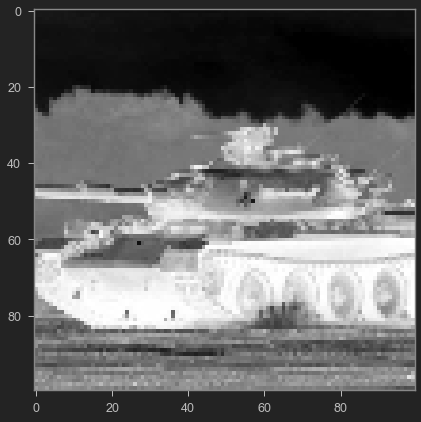

True class: Tank
Predicted probability:
Tank: 100%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 0% 


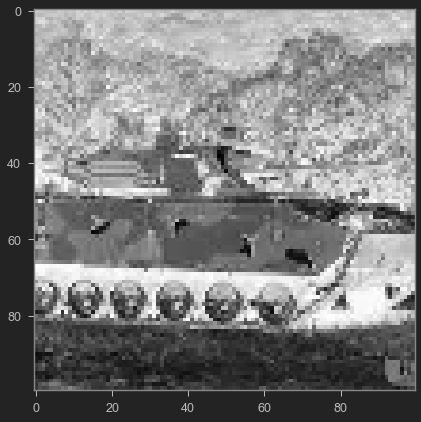

True class: Armored_tracked
Predicted probability:
Tank: 47%, Armored_tracked: 52%, Armored_wheeled: 0%, Artillery: 0% 


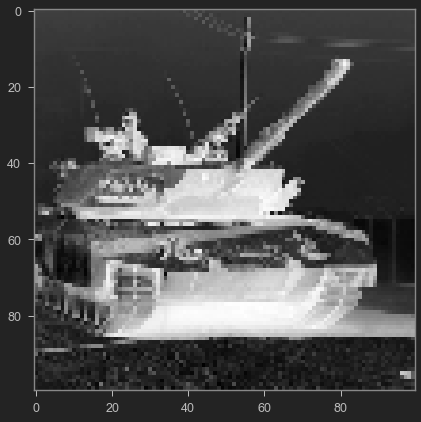

True class: Tank
Predicted probability:
Tank: 100%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 0% 


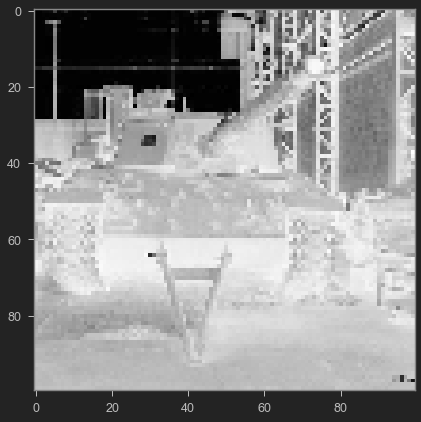

True class: Tank
Predicted probability:
Tank: 99%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 0% 


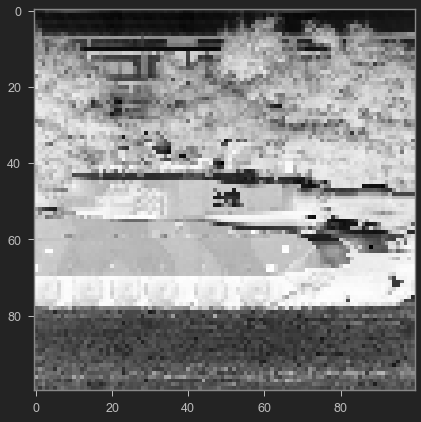

True class: Tank
Predicted probability:
Tank: 100%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 0% 


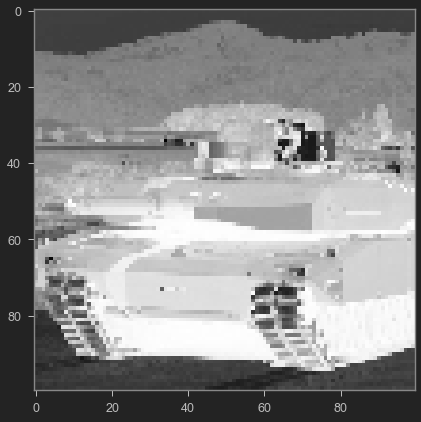

True class: Tank
Predicted probability:
Tank: 29%, Armored_tracked: 0%, Armored_wheeled: 69%, Artillery: 0% 


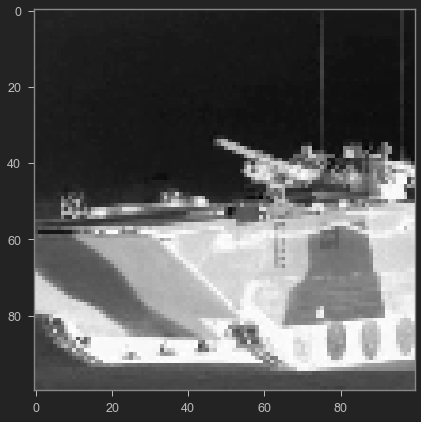

True class: Armored_tracked
Predicted probability:
Tank: 0%, Armored_tracked: 98%, Armored_wheeled: 1%, Artillery: 0% 


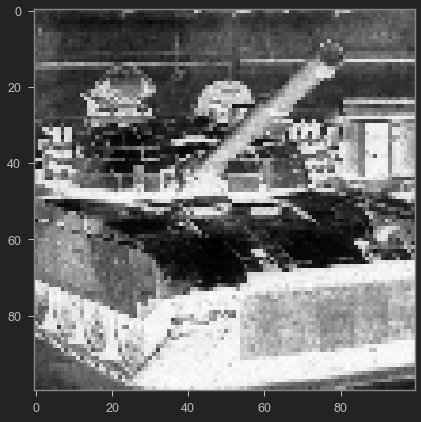

True class: Tank
Predicted probability:
Tank: 100%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 0% 


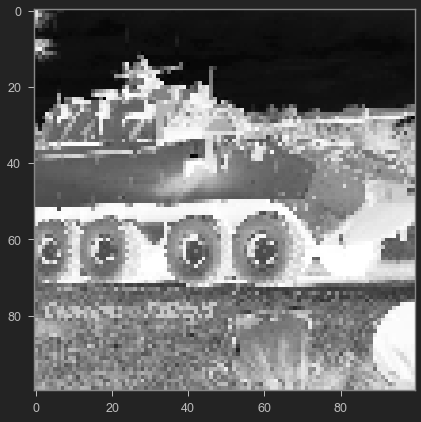

True class: Armored_wheeled
Predicted probability:
Tank: 0%, Armored_tracked: 0%, Armored_wheeled: 99%, Artillery: 0% 


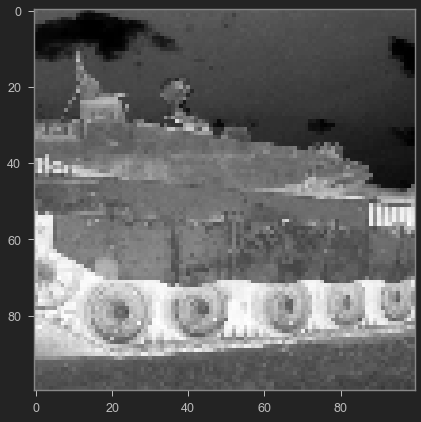

True class: Tank
Predicted probability:
Tank: 0%, Armored_tracked: 99%, Armored_wheeled: 0%, Artillery: 0% 


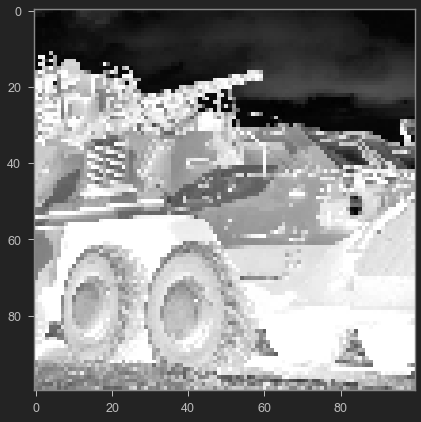

True class: Armored_wheeled
Predicted probability:
Tank: 0%, Armored_tracked: 0%, Armored_wheeled: 100%, Artillery: 0% 


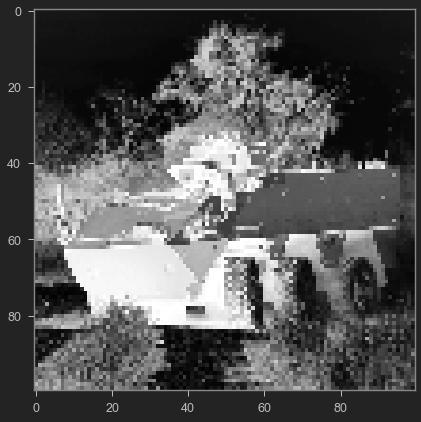

True class: Armored_wheeled
Predicted probability:
Tank: 31%, Armored_tracked: 68%, Armored_wheeled: 0%, Artillery: 0% 


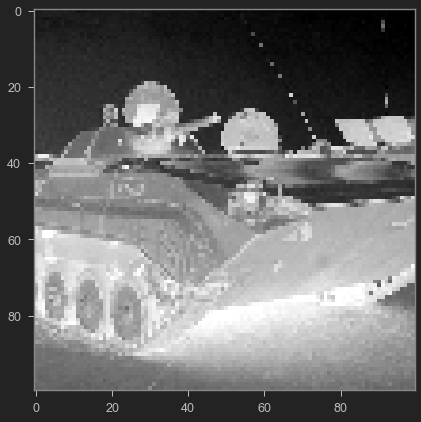

True class: Armored_tracked
Predicted probability:
Tank: 0%, Armored_tracked: 98%, Armored_wheeled: 1%, Artillery: 0% 


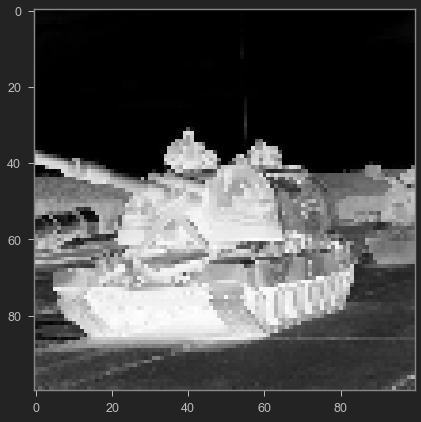

True class: Artillery
Predicted probability:
Tank: 99%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 0% 


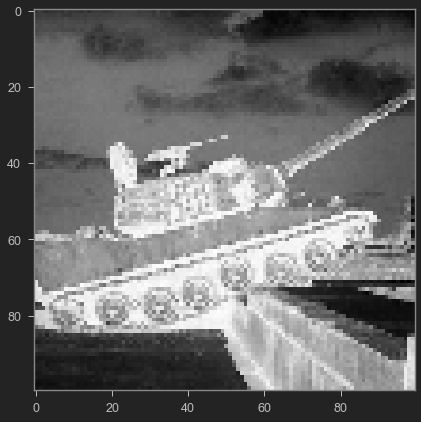

True class: Tank
Predicted probability:
Tank: 0%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 99% 


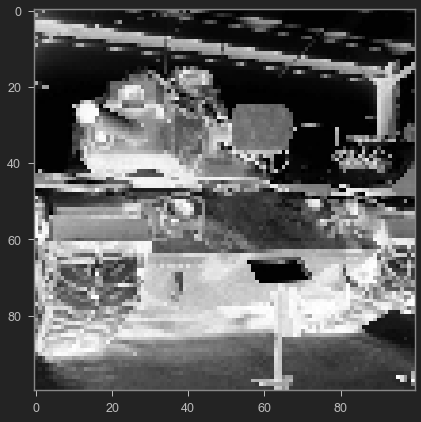

True class: Tank
Predicted probability:
Tank: 100%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 0% 


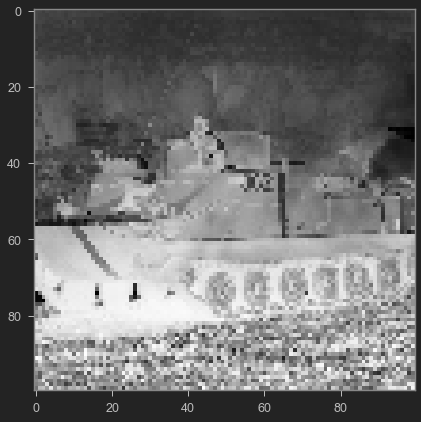

True class: Armored_tracked
Predicted probability:
Tank: 0%, Armored_tracked: 99%, Armored_wheeled: 0%, Artillery: 0% 


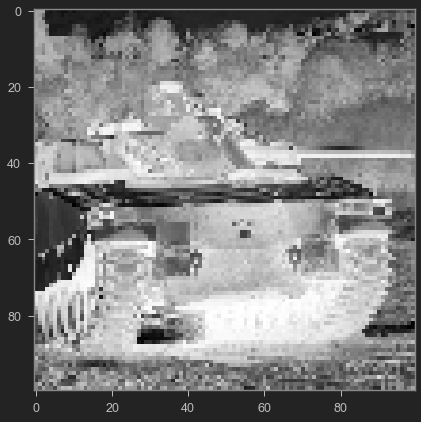

True class: Armored_tracked
Predicted probability:
Tank: 84%, Armored_tracked: 15%, Armored_wheeled: 0%, Artillery: 0% 


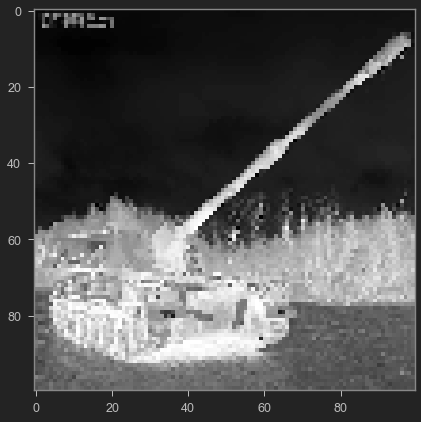

True class: Artillery
Predicted probability:
Tank: 0%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 99% 


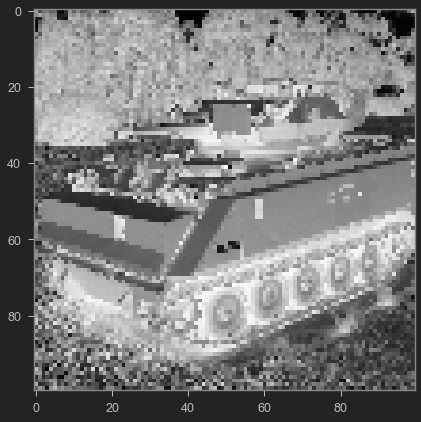

True class: Armored_tracked
Predicted probability:
Tank: 0%, Armored_tracked: 98%, Armored_wheeled: 1%, Artillery: 0% 


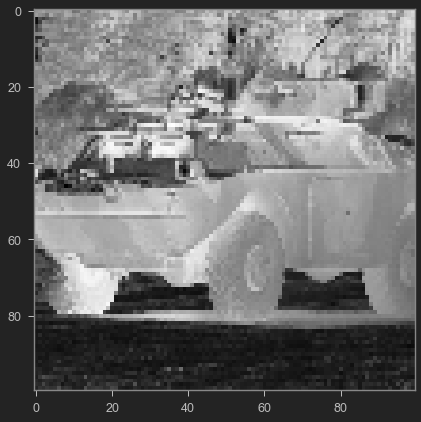

True class: Armored_wheeled
Predicted probability:
Tank: 97%, Armored_tracked: 1%, Armored_wheeled: 0%, Artillery: 0% 


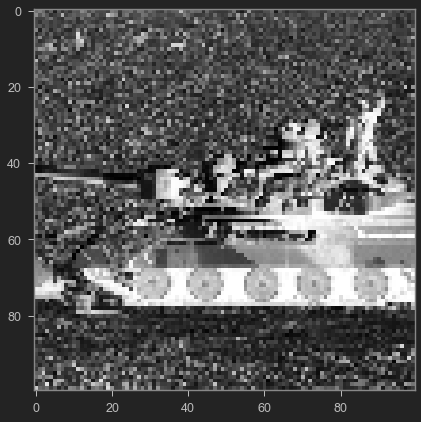

True class: Tank
Predicted probability:
Tank: 99%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 0% 


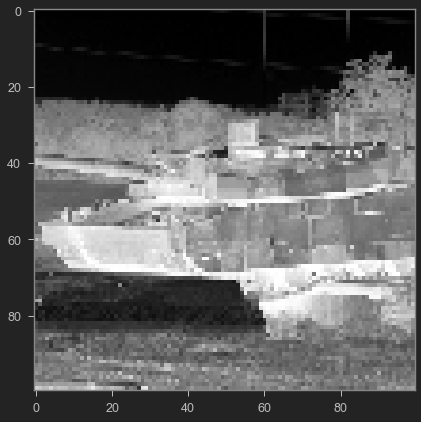

True class: Tank
Predicted probability:
Tank: 99%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 0% 


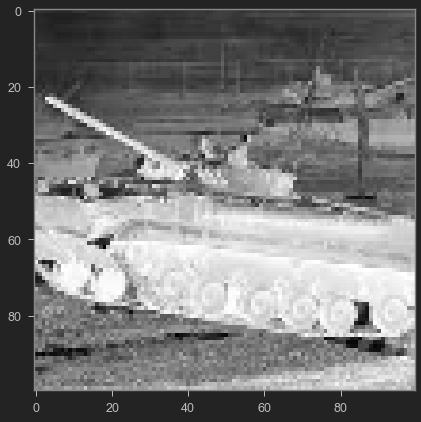

True class: Armored_tracked
Predicted probability:
Tank: 0%, Armored_tracked: 49%, Armored_wheeled: 49%, Artillery: 0% 


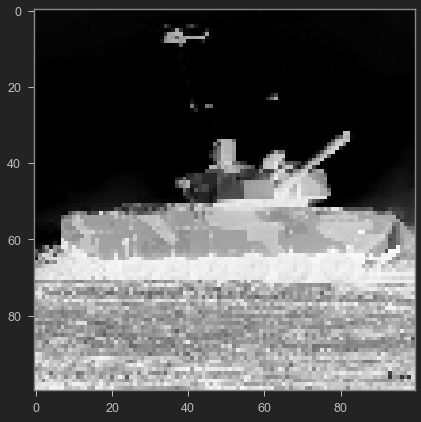

True class: Tank
Predicted probability:
Tank: 99%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 0% 


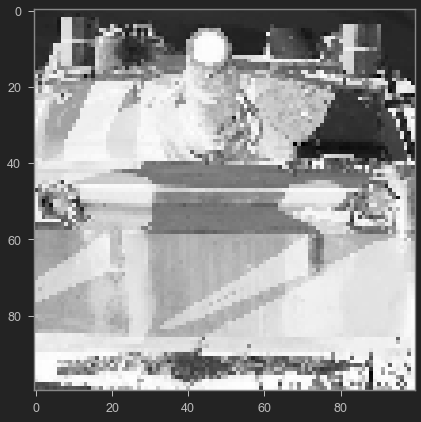

True class: Tank
Predicted probability:
Tank: 6%, Armored_tracked: 0%, Armored_wheeled: 93%, Artillery: 0% 


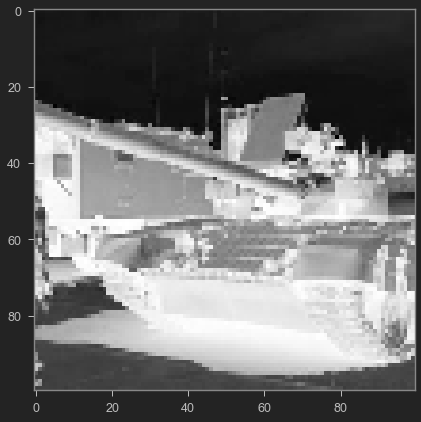

True class: Tank
Predicted probability:
Tank: 16%, Armored_tracked: 83%, Armored_wheeled: 0%, Artillery: 0% 


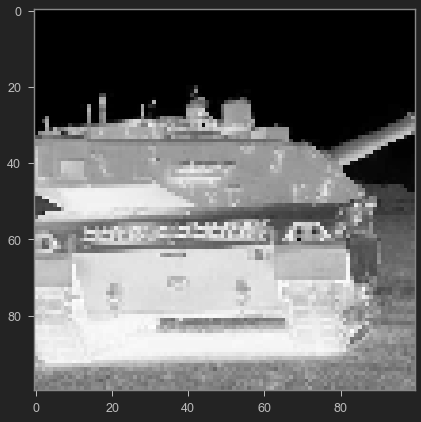

True class: Tank
Predicted probability:
Tank: 99%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 0% 


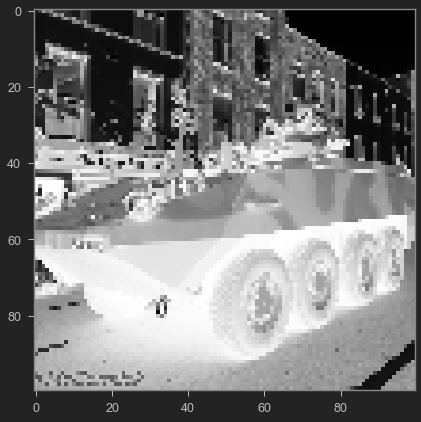

True class: Armored_wheeled
Predicted probability:
Tank: 0%, Armored_tracked: 99%, Armored_wheeled: 0%, Artillery: 0% 


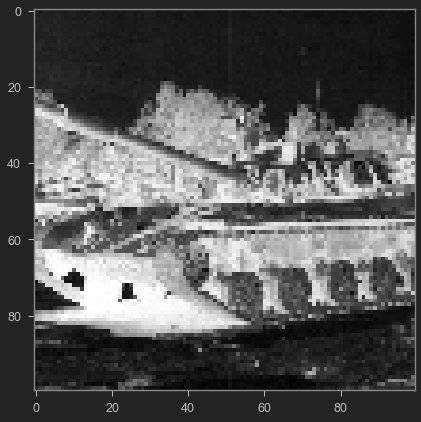

True class: Tank
Predicted probability:
Tank: 99%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 0% 


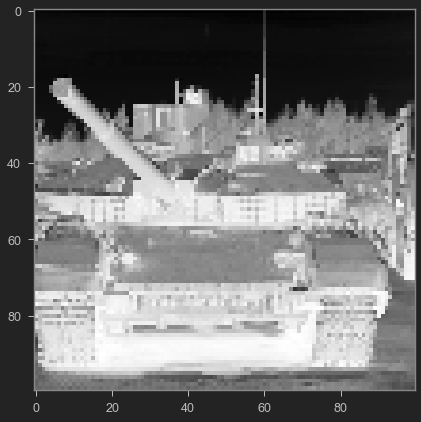

True class: Tank
Predicted probability:
Tank: 34%, Armored_tracked: 62%, Armored_wheeled: 3%, Artillery: 0% 


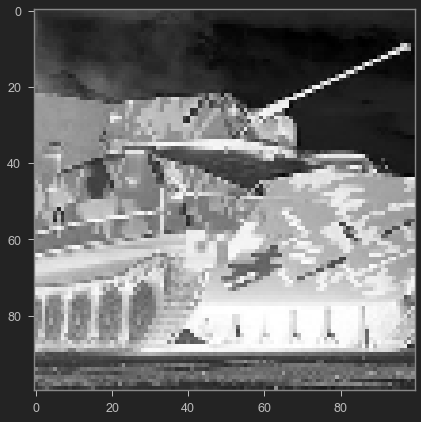

True class: Armored_tracked
Predicted probability:
Tank: 0%, Armored_tracked: 8%, Armored_wheeled: 84%, Artillery: 7% 


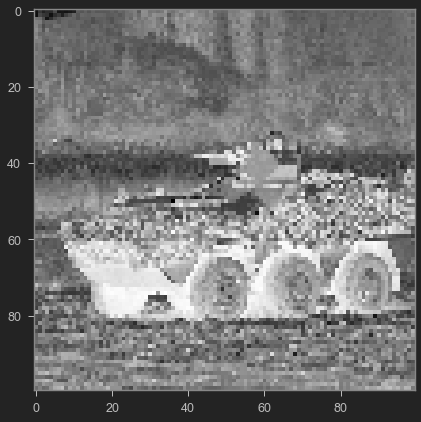

True class: Armored_wheeled
Predicted probability:
Tank: 0%, Armored_tracked: 1%, Armored_wheeled: 98%, Artillery: 0% 


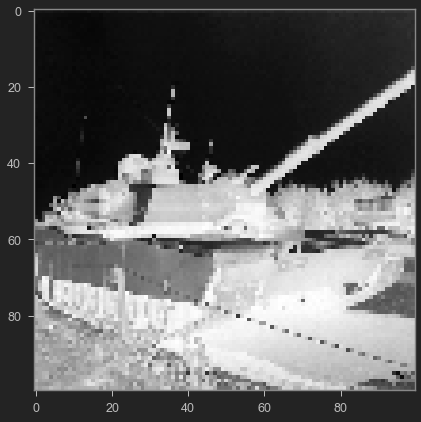

True class: Tank
Predicted probability:
Tank: 100%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 0% 


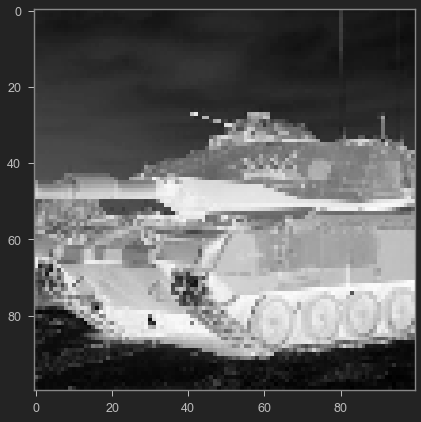

True class: Tank
Predicted probability:
Tank: 100%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 0% 


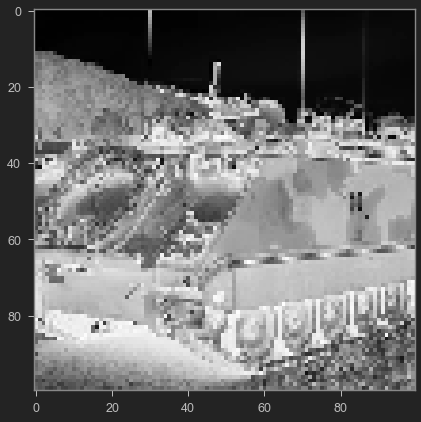

True class: Armored_tracked
Predicted probability:
Tank: 0%, Armored_tracked: 96%, Armored_wheeled: 0%, Artillery: 2% 


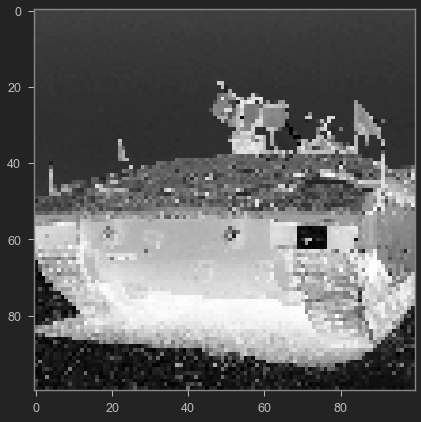

True class: Armored_tracked
Predicted probability:
Tank: 0%, Armored_tracked: 99%, Armored_wheeled: 0%, Artillery: 0% 


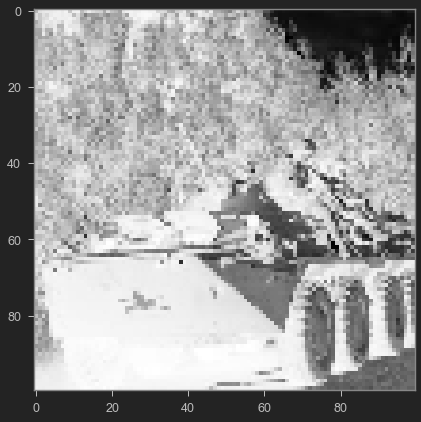

True class: Armored_wheeled
Predicted probability:
Tank: 0%, Armored_tracked: 99%, Armored_wheeled: 0%, Artillery: 0% 


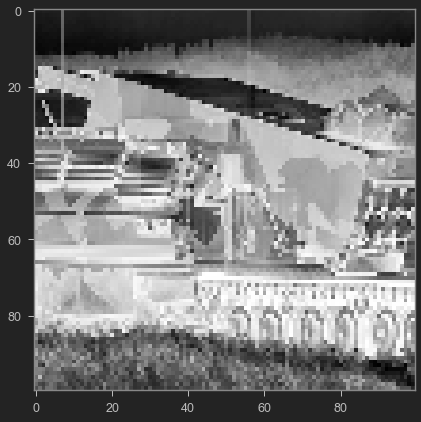

True class: Armored_tracked
Predicted probability:
Tank: 0%, Armored_tracked: 0%, Armored_wheeled: 99%, Artillery: 0% 


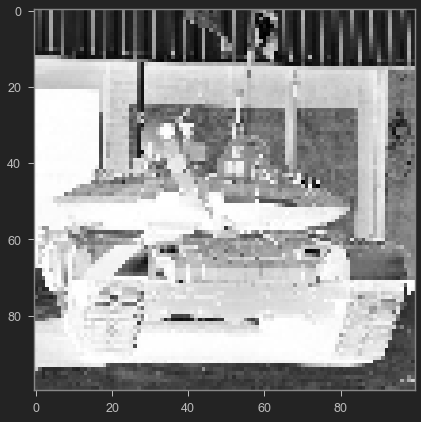

True class: Tank
Predicted probability:
Tank: 98%, Armored_tracked: 0%, Armored_wheeled: 1%, Artillery: 0% 


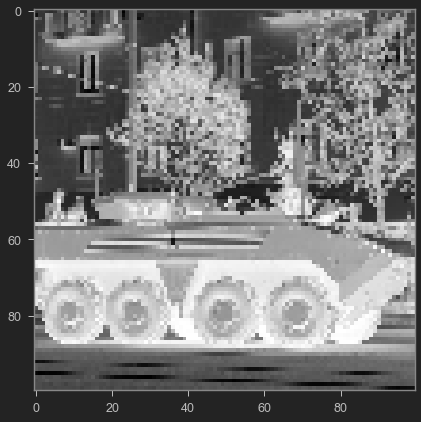

True class: Armored_wheeled
Predicted probability:
Tank: 0%, Armored_tracked: 0%, Armored_wheeled: 99%, Artillery: 0% 


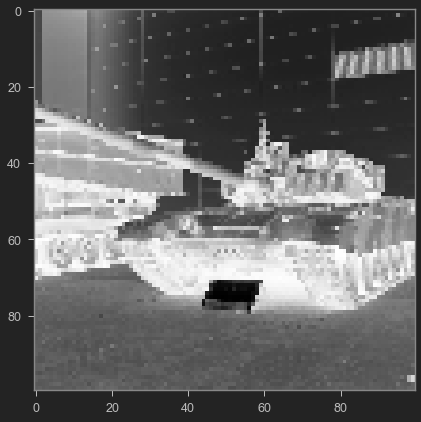

True class: Tank
Predicted probability:
Tank: 99%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 0% 


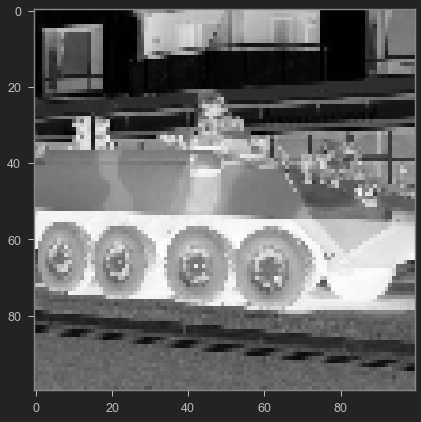

True class: Armored_wheeled
Predicted probability:
Tank: 99%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 0% 


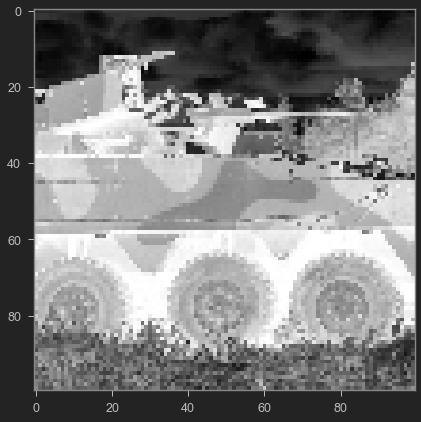

True class: Armored_wheeled
Predicted probability:
Tank: 0%, Armored_tracked: 0%, Armored_wheeled: 99%, Artillery: 0% 


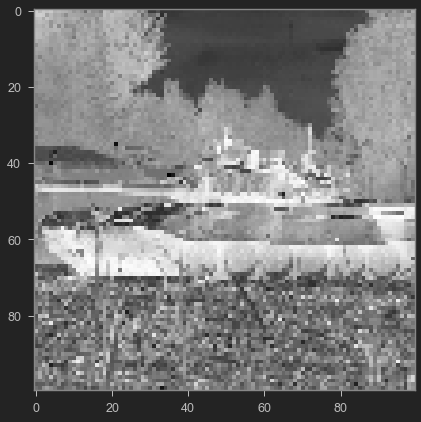

True class: Tank
Predicted probability:
Tank: 81%, Armored_tracked: 1%, Armored_wheeled: 17%, Artillery: 0% 


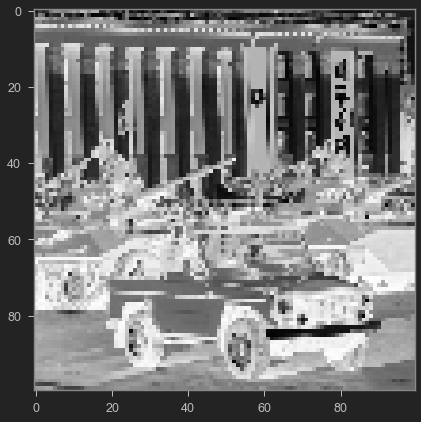

True class: Tank
Predicted probability:
Tank: 94%, Armored_tracked: 4%, Armored_wheeled: 1%, Artillery: 0% 


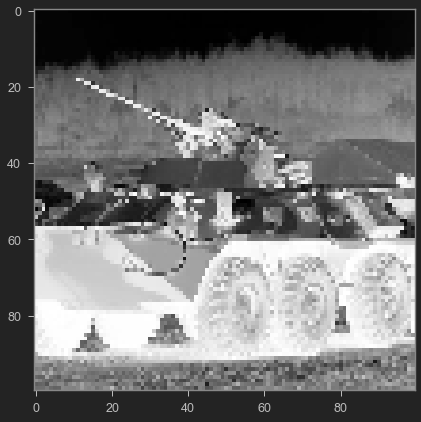

True class: Armored_wheeled
Predicted probability:
Tank: 0%, Armored_tracked: 0%, Armored_wheeled: 99%, Artillery: 0% 


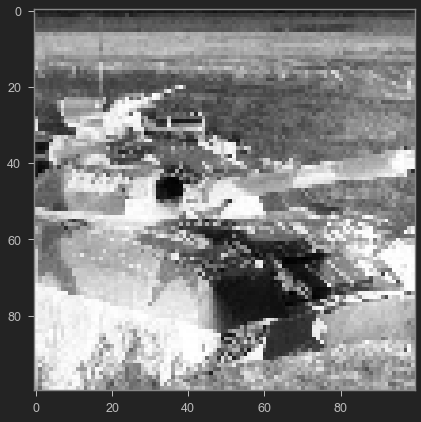

True class: Tank
Predicted probability:
Tank: 99%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 0% 


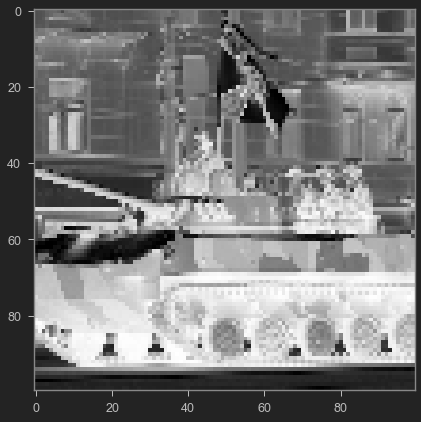

True class: Armored_tracked
Predicted probability:
Tank: 100%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 0% 


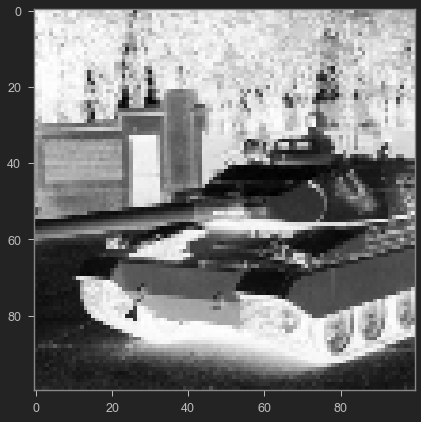

True class: Tank
Predicted probability:
Tank: 99%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 0% 


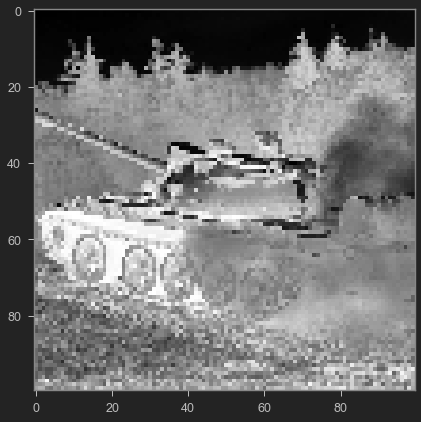

True class: Tank
Predicted probability:
Tank: 99%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 0% 


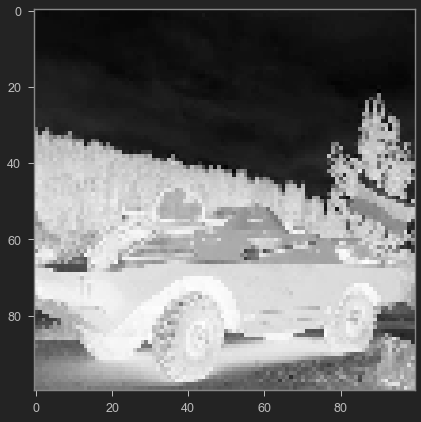

True class: Armored_wheeled
Predicted probability:
Tank: 1%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 97% 


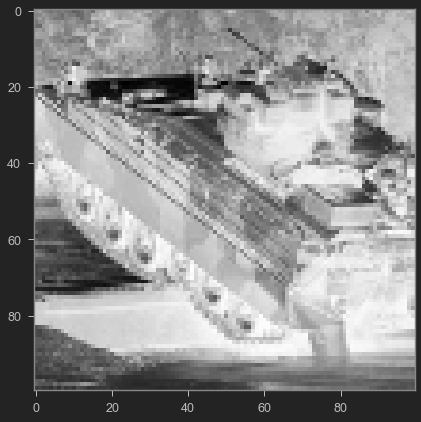

True class: Armored_tracked
Predicted probability:
Tank: 0%, Armored_tracked: 99%, Armored_wheeled: 0%, Artillery: 0% 


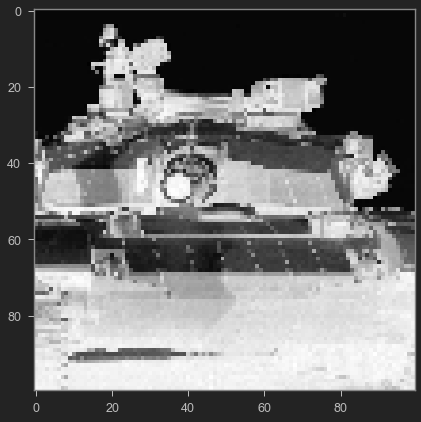

True class: Tank
Predicted probability:
Tank: 100%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 0% 


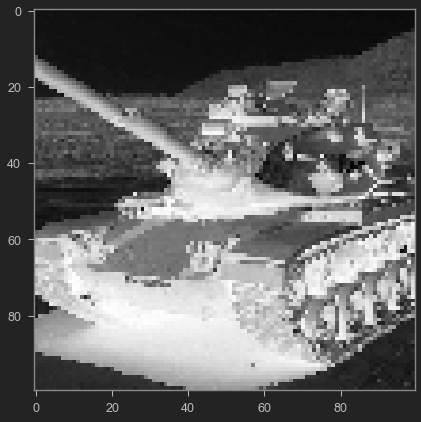

True class: Tank
Predicted probability:
Tank: 100%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 0% 


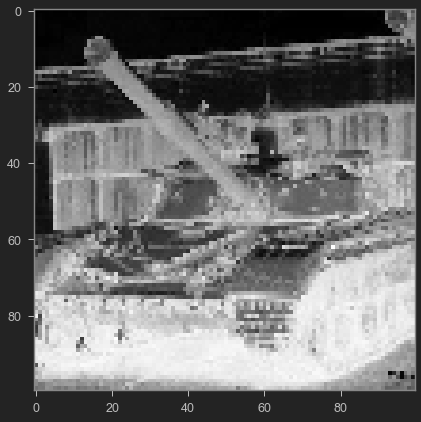

True class: Tank
Predicted probability:
Tank: 99%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 0% 


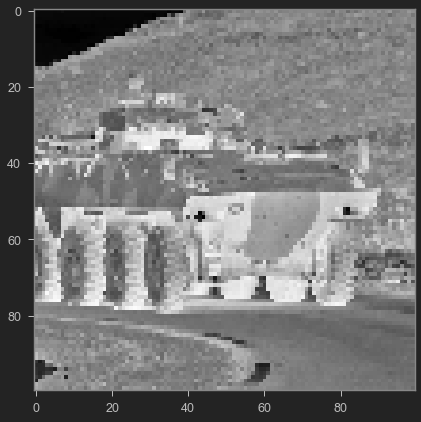

True class: Armored_wheeled
Predicted probability:
Tank: 0%, Armored_tracked: 91%, Armored_wheeled: 8%, Artillery: 0% 


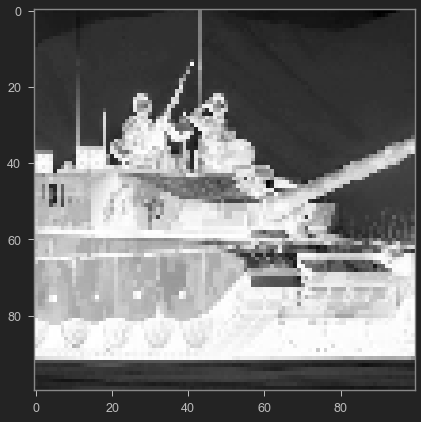

True class: Tank
Predicted probability:
Tank: 99%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 0% 


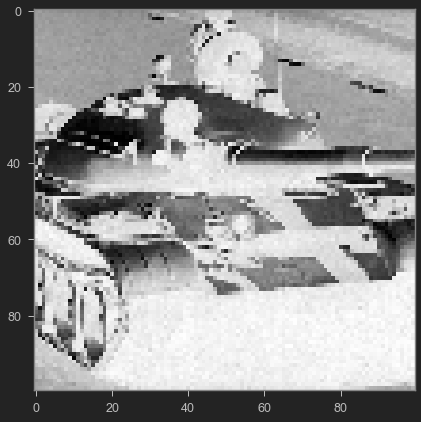

True class: Tank
Predicted probability:
Tank: 100%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 0% 


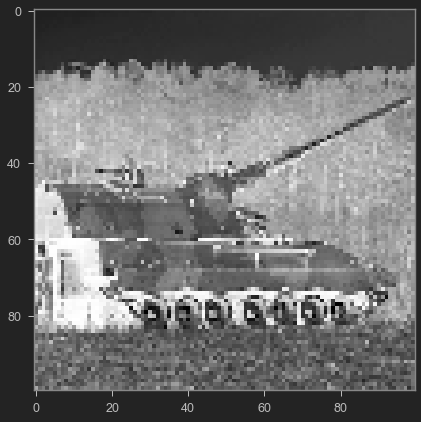

True class: Artillery
Predicted probability:
Tank: 11%, Armored_tracked: 21%, Armored_wheeled: 66%, Artillery: 0% 


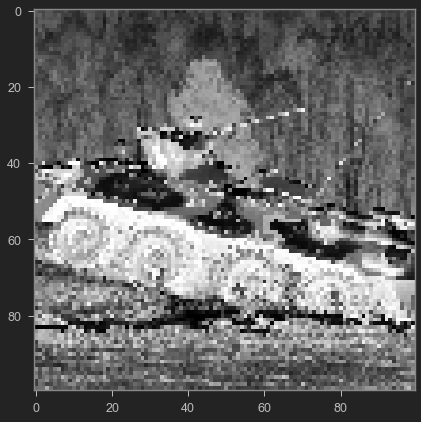

True class: Armored_wheeled
Predicted probability:
Tank: 0%, Armored_tracked: 0%, Armored_wheeled: 99%, Artillery: 0% 


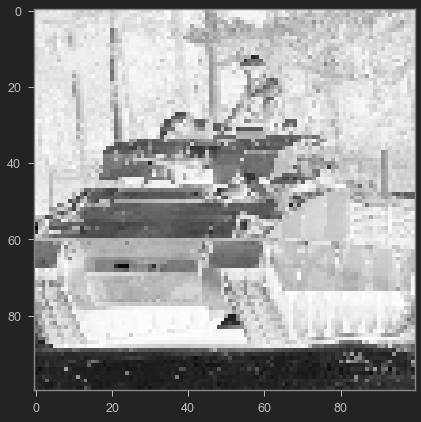

True class: Armored_tracked
Predicted probability:
Tank: 0%, Armored_tracked: 0%, Armored_wheeled: 99%, Artillery: 0% 


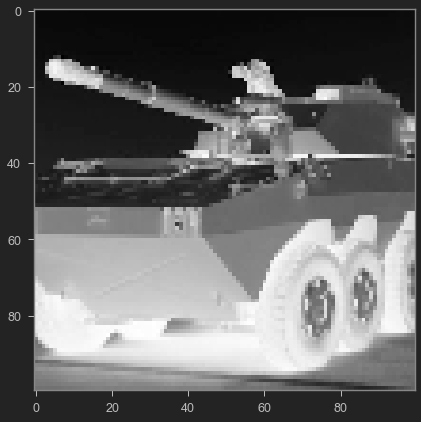

True class: Armored_wheeled
Predicted probability:
Tank: 1%, Armored_tracked: 57%, Armored_wheeled: 41%, Artillery: 0% 


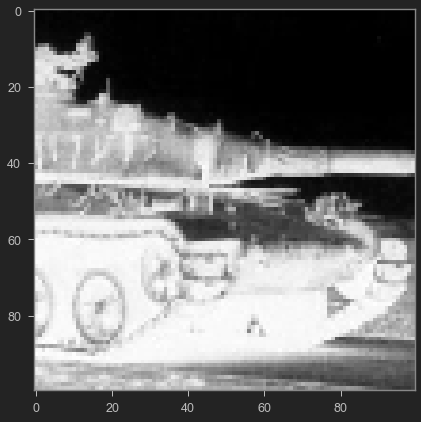

True class: Tank
Predicted probability:
Tank: 87%, Armored_tracked: 12%, Armored_wheeled: 0%, Artillery: 0% 


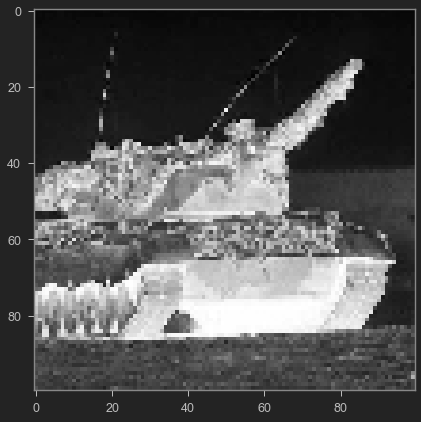

True class: Tank
Predicted probability:
Tank: 10%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 89% 


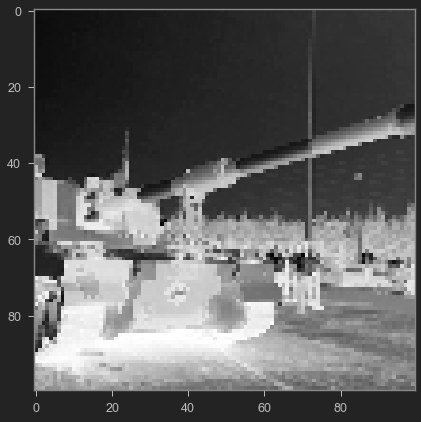

True class: Artillery
Predicted probability:
Tank: 99%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 0% 


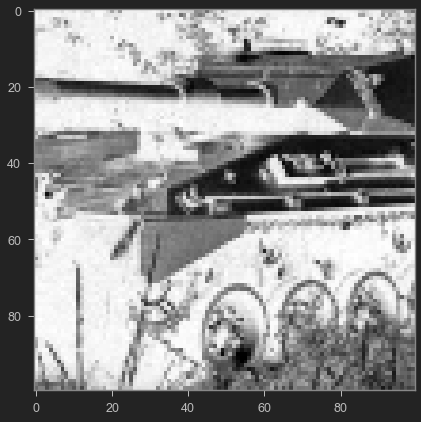

True class: Tank
Predicted probability:
Tank: 23%, Armored_tracked: 0%, Armored_wheeled: 76%, Artillery: 0% 


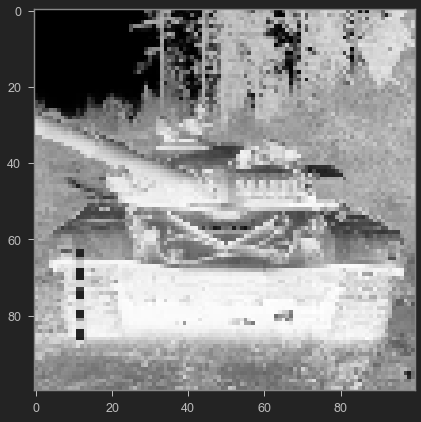

True class: Tank
Predicted probability:
Tank: 100%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 0% 


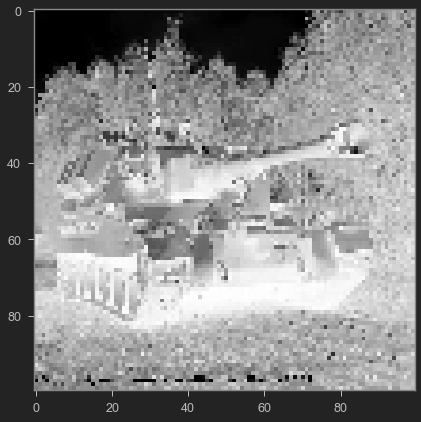

True class: Artillery
Predicted probability:
Tank: 99%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 0% 


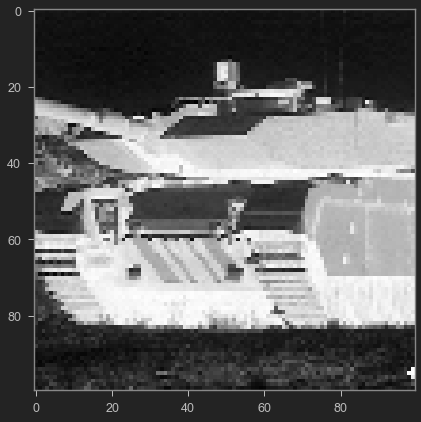

True class: Tank
Predicted probability:
Tank: 99%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 0% 


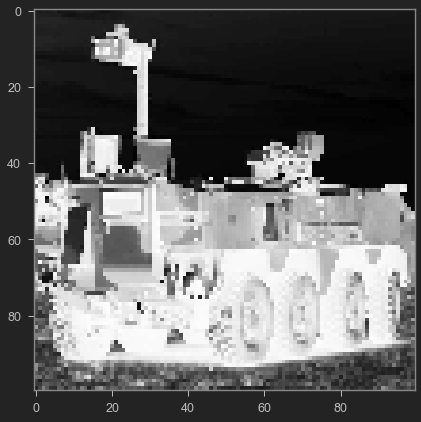

True class: Armored_wheeled
Predicted probability:
Tank: 0%, Armored_tracked: 0%, Armored_wheeled: 99%, Artillery: 0% 


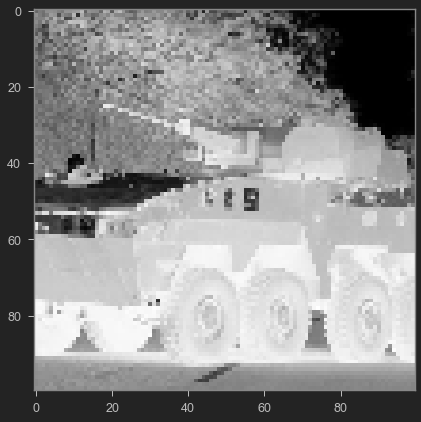

True class: Armored_wheeled
Predicted probability:
Tank: 0%, Armored_tracked: 0%, Armored_wheeled: 99%, Artillery: 0% 


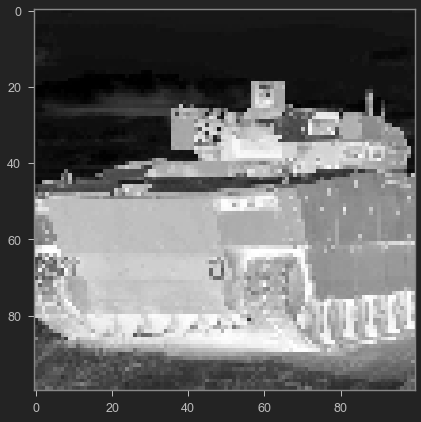

True class: Armored_tracked
Predicted probability:
Tank: 0%, Armored_tracked: 99%, Armored_wheeled: 0%, Artillery: 0% 


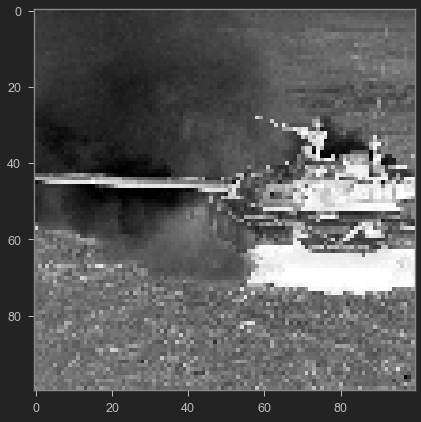

True class: Tank
Predicted probability:
Tank: 100%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 0% 


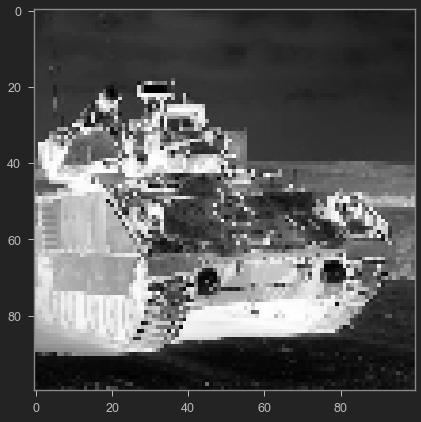

True class: Armored_tracked
Predicted probability:
Tank: 0%, Armored_tracked: 93%, Armored_wheeled: 3%, Artillery: 3% 


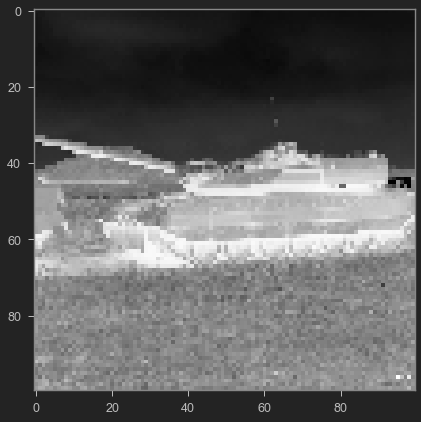

True class: Tank
Predicted probability:
Tank: 99%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 0% 


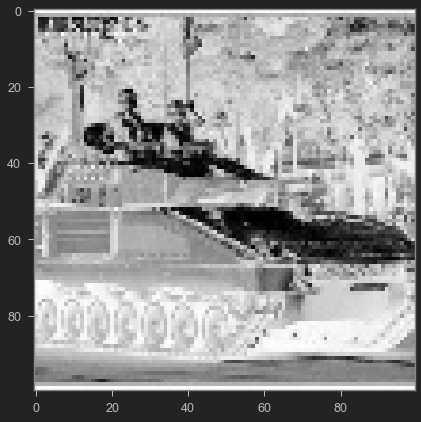

True class: Armored_tracked
Predicted probability:
Tank: 92%, Armored_tracked: 7%, Armored_wheeled: 0%, Artillery: 0% 


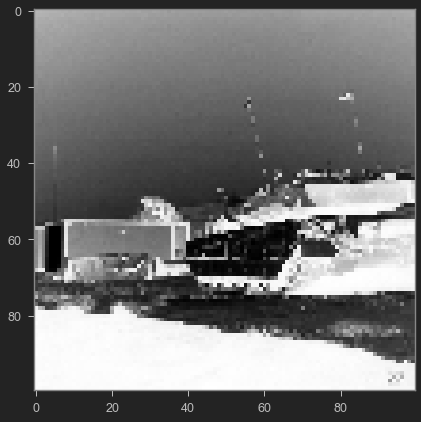

True class: Tank
Predicted probability:
Tank: 99%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 0% 


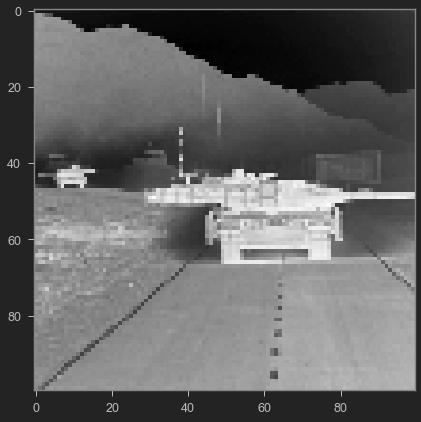

True class: Tank
Predicted probability:
Tank: 99%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 0% 


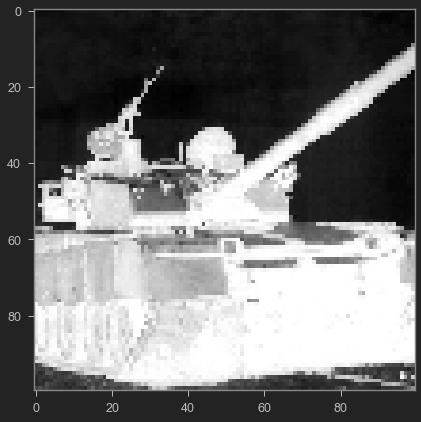

True class: Tank
Predicted probability:
Tank: 100%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 0% 


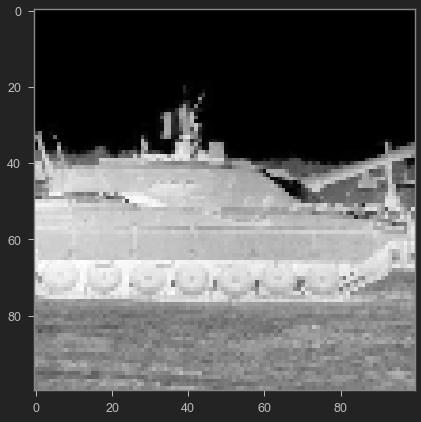

True class: Tank
Predicted probability:
Tank: 66%, Armored_tracked: 33%, Armored_wheeled: 0%, Artillery: 0% 


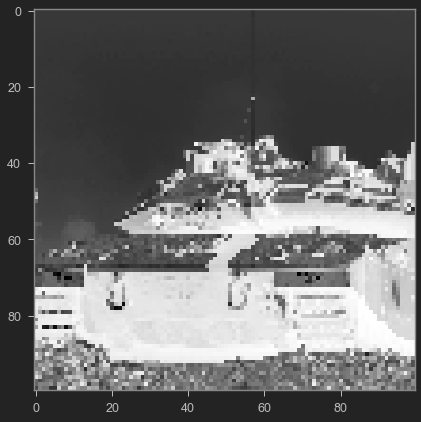

True class: Tank
Predicted probability:
Tank: 99%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 0% 


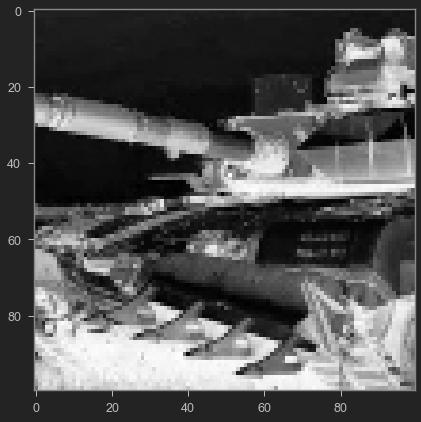

True class: Tank
Predicted probability:
Tank: 5%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 94% 


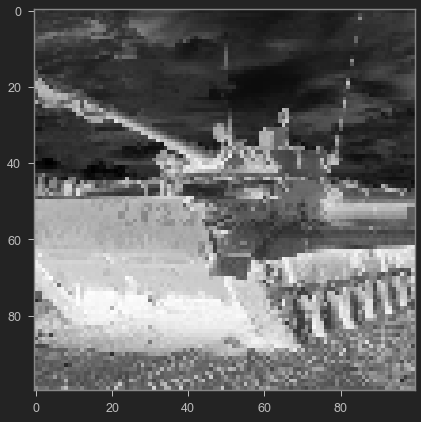

True class: Armored_tracked
Predicted probability:
Tank: 0%, Armored_tracked: 99%, Armored_wheeled: 0%, Artillery: 0% 


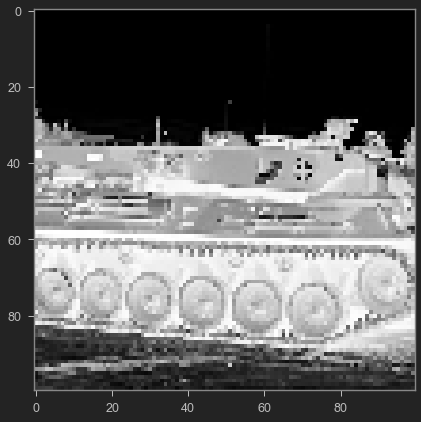

True class: Armored_tracked
Predicted probability:
Tank: 100%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 0% 


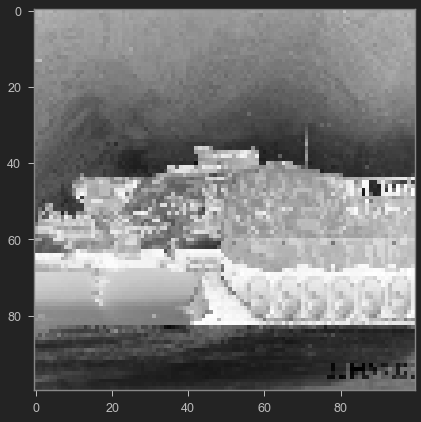

True class: Armored_tracked
Predicted probability:
Tank: 0%, Armored_tracked: 98%, Armored_wheeled: 0%, Artillery: 0% 


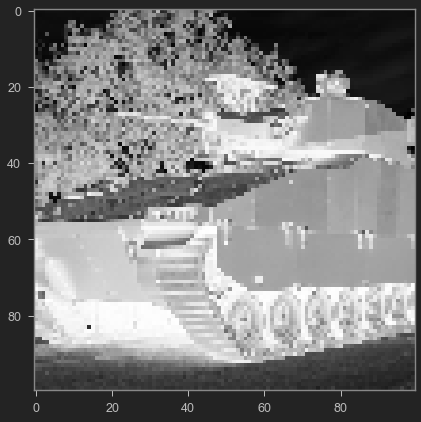

True class: Armored_tracked
Predicted probability:
Tank: 0%, Armored_tracked: 99%, Armored_wheeled: 0%, Artillery: 0% 


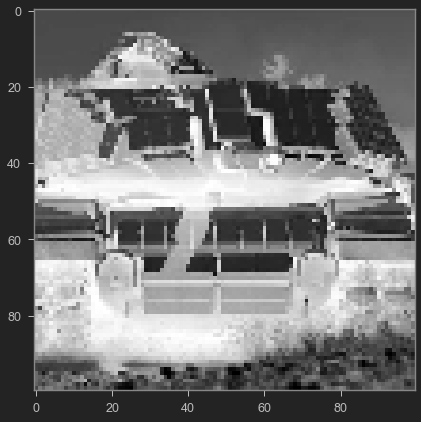

True class: Tank
Predicted probability:
Tank: 100%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 0% 


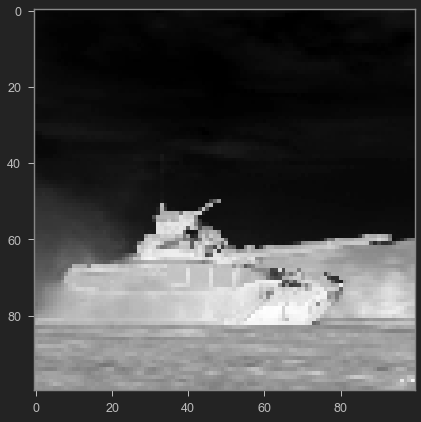

True class: Tank
Predicted probability:
Tank: 85%, Armored_tracked: 12%, Armored_wheeled: 1%, Artillery: 0% 


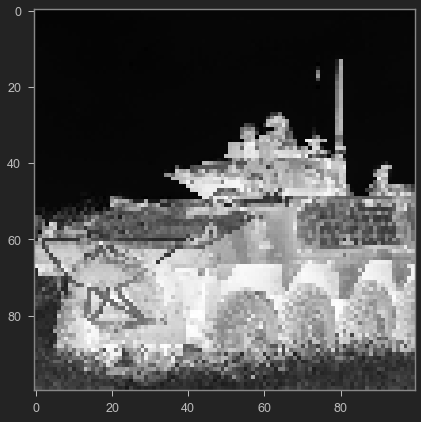

True class: Armored_wheeled
Predicted probability:
Tank: 96%, Armored_tracked: 2%, Armored_wheeled: 0%, Artillery: 0% 


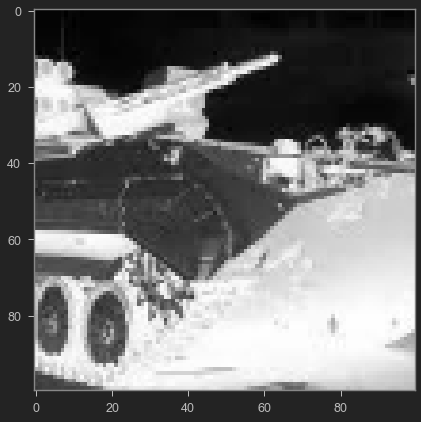

True class: Armored_tracked
Predicted probability:
Tank: 0%, Armored_tracked: 0%, Armored_wheeled: 100%, Artillery: 0% 


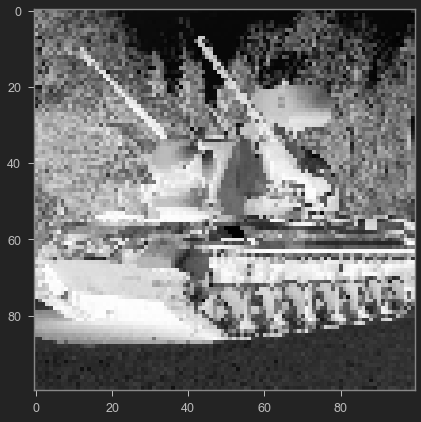

True class: Armored_tracked
Predicted probability:
Tank: 100%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 0% 


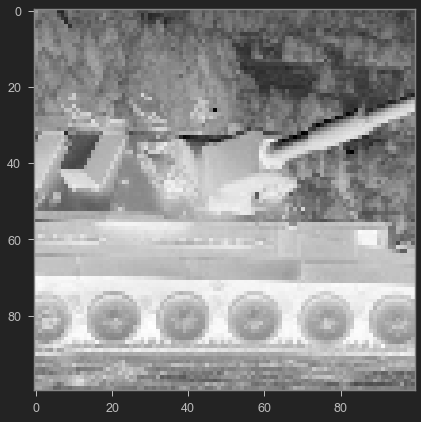

True class: Artillery
Predicted probability:
Tank: 38%, Armored_tracked: 0%, Armored_wheeled: 16%, Artillery: 45% 


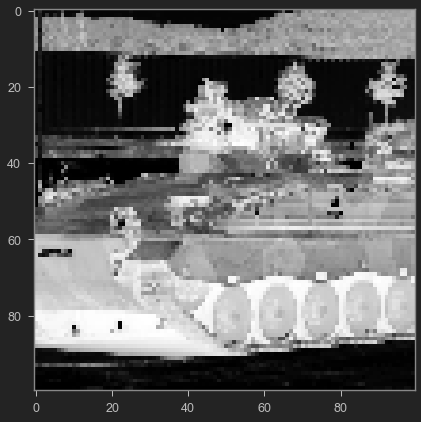

True class: Armored_tracked
Predicted probability:
Tank: 99%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 0% 


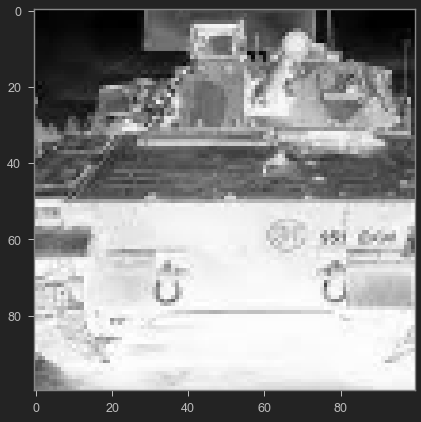

True class: Armored_tracked
Predicted probability:
Tank: 55%, Armored_tracked: 7%, Armored_wheeled: 37%, Artillery: 0% 


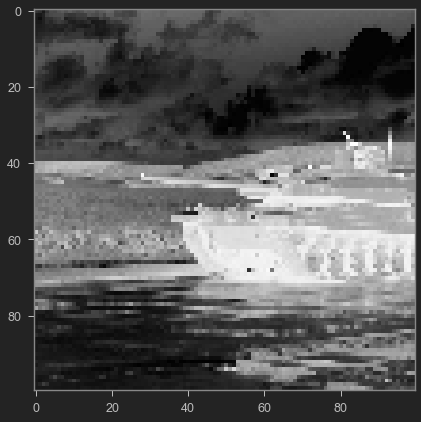

True class: Tank
Predicted probability:
Tank: 93%, Armored_tracked: 6%, Armored_wheeled: 0%, Artillery: 0% 


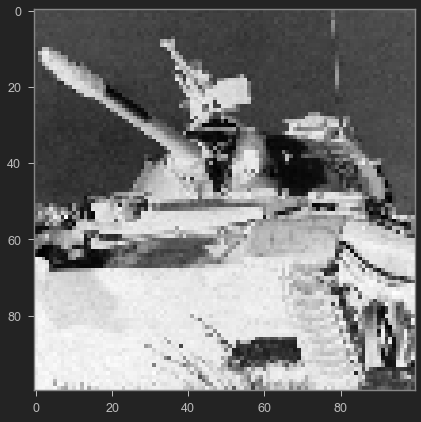

True class: Tank
Predicted probability:
Tank: 100%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 0% 


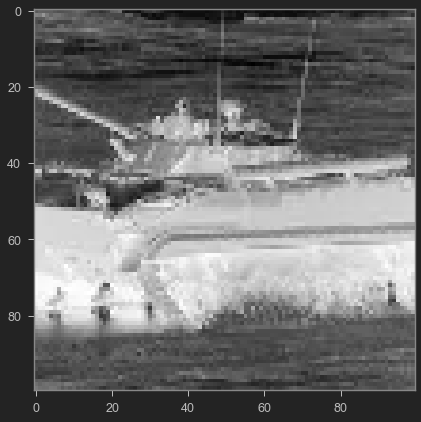

True class: Armored_tracked
Predicted probability:
Tank: 97%, Armored_tracked: 0%, Armored_wheeled: 2%, Artillery: 0% 


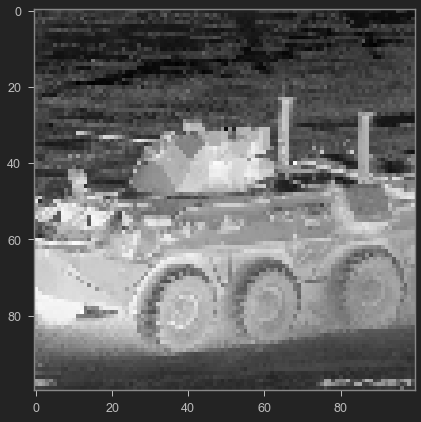

True class: Armored_wheeled
Predicted probability:
Tank: 4%, Armored_tracked: 21%, Armored_wheeled: 73%, Artillery: 0% 


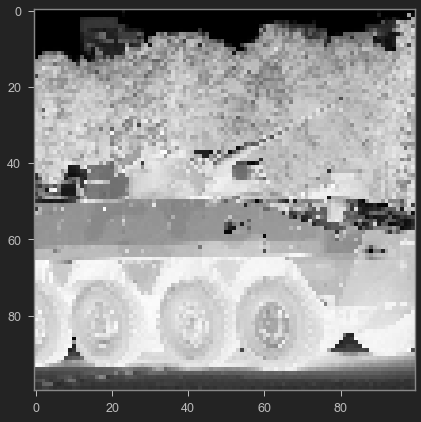

True class: Armored_wheeled
Predicted probability:
Tank: 0%, Armored_tracked: 0%, Armored_wheeled: 99%, Artillery: 0% 


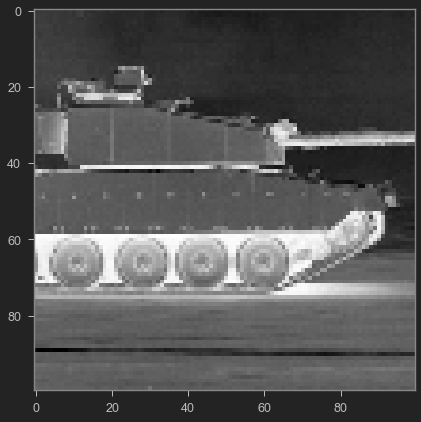

True class: Tank
Predicted probability:
Tank: 7%, Armored_tracked: 0%, Armored_wheeled: 30%, Artillery: 61% 


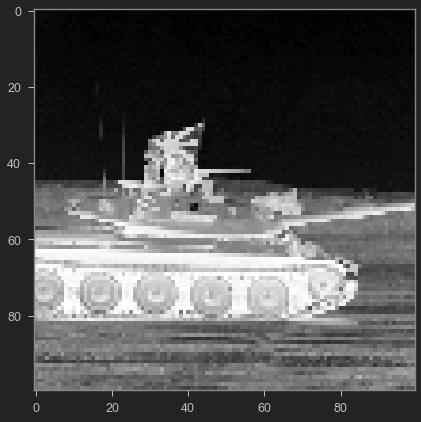

True class: Tank
Predicted probability:
Tank: 91%, Armored_tracked: 8%, Armored_wheeled: 0%, Artillery: 0% 


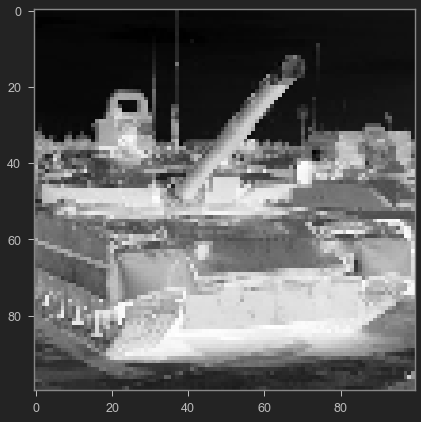

True class: Tank
Predicted probability:
Tank: 99%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 0% 


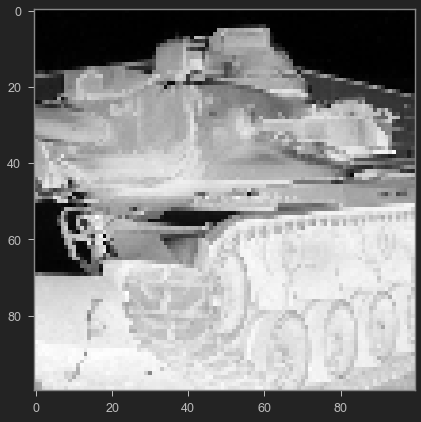

True class: Tank
Predicted probability:
Tank: 99%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 0% 


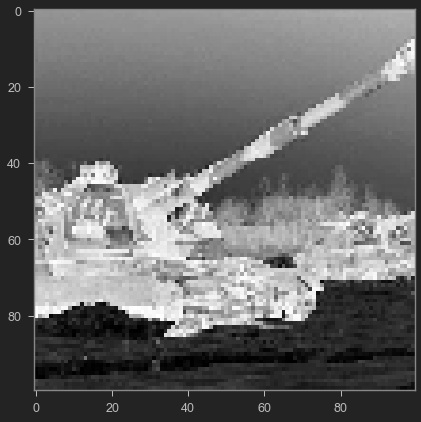

True class: Artillery
Predicted probability:
Tank: 0%, Armored_tracked: 98%, Armored_wheeled: 0%, Artillery: 0% 


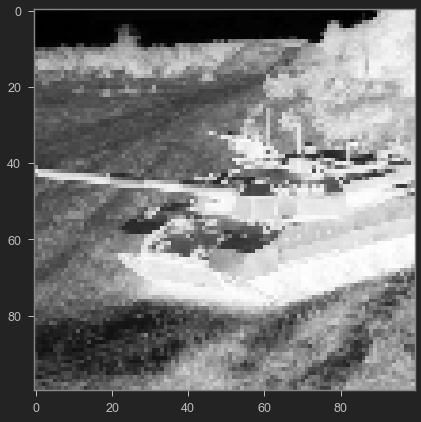

True class: Tank
Predicted probability:
Tank: 99%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 0% 


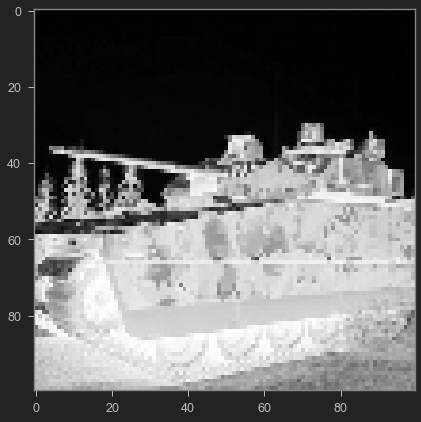

True class: Armored_tracked
Predicted probability:
Tank: 99%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 0% 


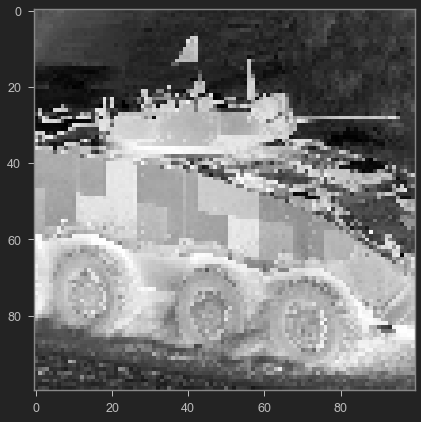

True class: Armored_wheeled
Predicted probability:
Tank: 0%, Armored_tracked: 6%, Armored_wheeled: 92%, Artillery: 0% 


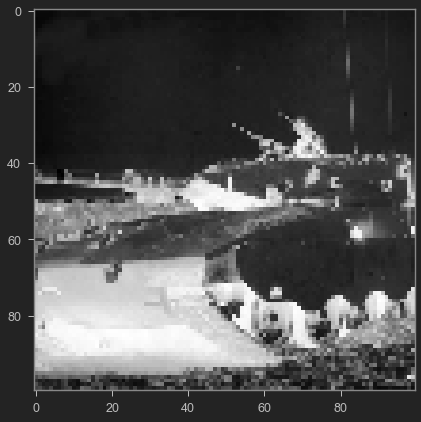

True class: Tank
Predicted probability:
Tank: 99%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 0% 


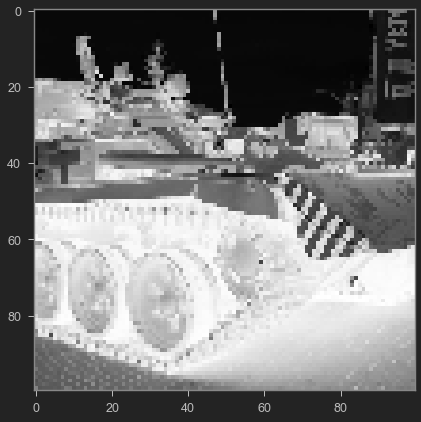

True class: Armored_tracked
Predicted probability:
Tank: 98%, Armored_tracked: 0%, Armored_wheeled: 1%, Artillery: 0% 


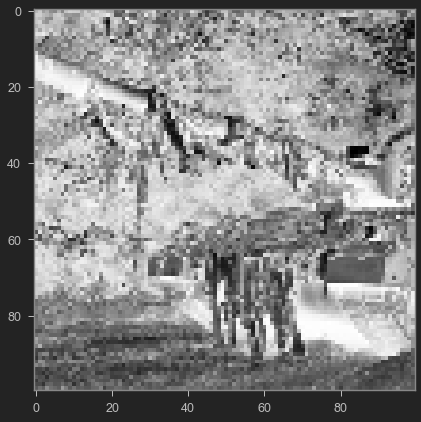

True class: Artillery
Predicted probability:
Tank: 94%, Armored_tracked: 5%, Armored_wheeled: 0%, Artillery: 0% 


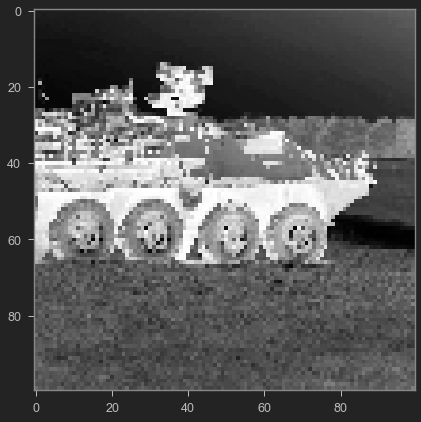

True class: Armored_wheeled
Predicted probability:
Tank: 99%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 0% 


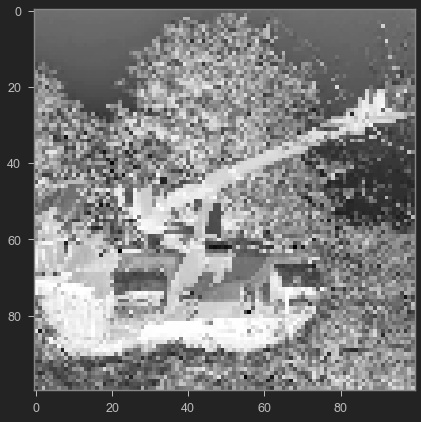

True class: Artillery
Predicted probability:
Tank: 0%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 99% 


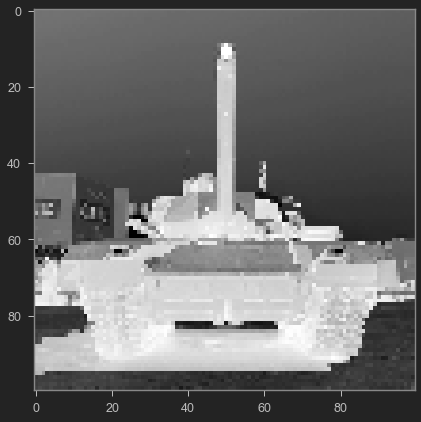

True class: Tank
Predicted probability:
Tank: 0%, Armored_tracked: 99%, Armored_wheeled: 0%, Artillery: 0% 


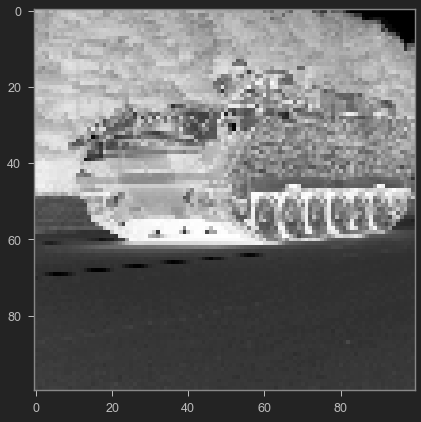

True class: Armored_tracked
Predicted probability:
Tank: 99%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 0% 


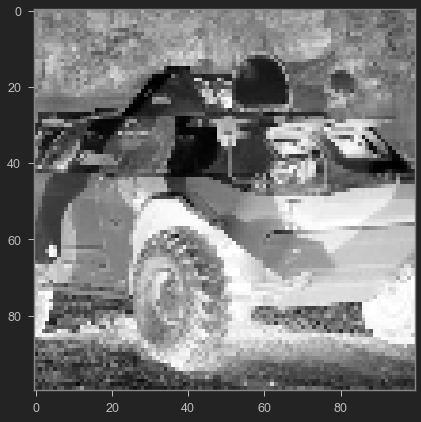

True class: Armored_wheeled
Predicted probability:
Tank: 0%, Armored_tracked: 0%, Armored_wheeled: 99%, Artillery: 0% 


In [41]:
from keras.preprocessing.image import array_to_img

for k in range(len(X_test)):
    image = array_to_img(X_test[k])
    plt.imshow(image, cmap='binary')
    plt.show()
    data = X_test[k].reshape(1, 100, 100, 1)
    y_pred = baseline_model_1_gs.predict(data)
    print(f'True class: {vehicle_dict[y_name[k]]}')
    print('Predicted probability:')
    print(f'Tank: {round(int(y_pred.take(0)*100))}%, Armored_tracked: {int(y_pred.take(1)*100)}%, Armored_wheeled: {int(y_pred.take(2)*100)}%, Artillery: {int(y_pred.take(3)*100)}% ')

### 6. CONCLUSIONS

As we can see, the best result (about 70% accuracy) we achieved by baseline model, supplemented by data augmentation whereas over-sampling is not properly approach - data set is imbalanced, but too small and over-sampling induces over-fitting.

Project has potiential for few next steps - especially combine improved models with data augmentation aproach, and use more data augementation techniques. From last step we have conclusion, that augmentation by grayscale is interesting step.

Next potential step is attempt with "classical" ML algorithm such as SGD.

The last one is using more powerfull CNN, especially from keras.applications, run it with GPU.